In [2]:
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import distributions, nn, optim
import argparse
import torchsde

In [13]:
# check if the gpu is available or not, if yes, use gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
# set up the tuple for data, 
Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])

In [29]:
# output values from 0 to maxval with iters steps
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1,iters)
        self._val = maxval/self._iters
        self._maxval = maxval
    
    def step(self):
        self._val = min(self._maxval, self._val+self._maxval/self._iters)
        
    @property
    def val(self):
        return self._val

In [30]:
class EMAMetric(object):
    def __init__(self, gamma: Optional[float]=0.99):
        super(EMAMetric, self).__init__()
        self._val=None
        self._gamma = gamma
    def step(self, x:Union[torch.Tensor, np.ndarray]):
        x = x.detach().cpu().numpy() if torch.is_tensor(x) else x
        if self._val is None:
            self._val = x
        else: 
            self._val = self._gamma * self._val + (1-self._gamma)*x
        return self._val
    
    @property
    def val(self):
        return self._val

In [31]:
# set the seed
def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [32]:
# make sure that the dvision is stable
def _stable_division(a,b,epsilon=1e-7):
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon)*b.sign())
    return a/b

In [33]:
def str2bool(v):
    """Used for boolean arguments in argparse; avoiding `store_true` and `store_false`."""
    if isinstance(v, bool): return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'): return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'): return False
    else: raise argparse.ArgumentTypeError('Boolean value expected.')



In [34]:
class LatentSDE(torchsde.SDEIto):

    def __init__(self, theta=0.5, mu=0.0, sigma=1.0):
        super(LatentSDE, self).__init__(noise_type="diagonal")
        logvar = math.log(sigma ** 2 / (2. * theta))

        # Prior drift.
        self.register_buffer("theta", torch.tensor([[theta]]))
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma", torch.tensor([[sigma]]))

        # p(y0).
        self.register_buffer("py0_mean", torch.tensor([[mu]]))
        self.register_buffer("py0_logvar", torch.tensor([[logvar]]))

        # Approximate posterior drift: Takes in 2 positional encodings and the state.
        self.net = nn.Sequential(
            nn.Linear(7, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 1)
        )
        # Initialization trick from Glow.
        self.net[-1].weight.data.fill_(0.)
        self.net[-1].bias.data.fill_(0.)

        # q(y0).
        self.qy0_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=True)
        self.qy0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True)

    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            #t = torch.full_like(y, fill_value=t*100.0/132.0 )
            t = torch.full_like(y, fill_value=t )

        # Positional encoding in transformers for time-inhomogeneous posterior.
        #return self.net(torch.cat((torch.sin(t), torch.cos(t),  y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), torch.sin(t)**2, torch.cos(t)**2, y), dim=-1))
        return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), torch.sin(t**3), torch.cos(t**3), y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), y), dim=-1))
    
    def g(self, t, y):  # Shared diffusion.
        return self.sigma.repeat(y.size(0), 1)



    def h(self, t, y):  # Prior drift.
        return self.theta * (self.mu - y)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1]
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y)
        u = _stable_division(f - h, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y)
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=args.method,
            dt=args.dt,
            adaptive=args.adaptive,
            rtol=args.rtol,
            atol=args.atol,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt, names={'drift': 'h'})
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt, names={'drift': 'h'})

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt)
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt)

    @property
    def py0_std(self):
        return torch.exp(.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return torch.exp(.5 * self.qy0_logvar)

## 5. Simulation of time series

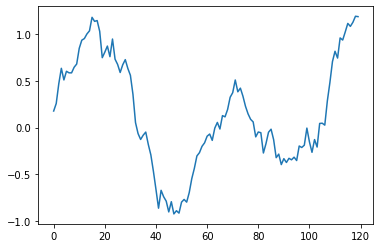

In [35]:
T = 120
s = 50
mu = 0
sigma = 0.1
phi = 0.9
def make_time_series():
    z0 = np.random.normal(0,sigma,1)
    z = np.zeros(T)
    z[0] = z0
    shocks = np.random.normal(mu, sigma, T)
    for idx_t in range(T-1):
        z[idx_t+1] = phi*z[idx_t] + shocks[idx_t+1] + 0.1*np.sin(2*np.pi*idx_t/s)
    return z
r = make_time_series()
plt.plot(range(T),r)
plt.show()

In [36]:
def make_data():
    ts_ = np.linspace(0.1,12.,120)
    ts_ext_ = np.array([0.] + list(ts_) + [12.1])
    ts_vis_ = np.linspace(0., 18., 300)
    ys_ = r[:,None]
    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float().to(device)
    return Data(ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_)  

In [68]:
def main(model):
    # Dataset.
    ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()

    # Plotting parameters.
    vis_batch_size = 1024
    ylims = (-1.75, 1.75)
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = np.random.permutation(vis_batch_size)
    # From https://colorbrewer2.org/.
    if args.color == "blue":
        sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
        fill_color = '#9ebcda'
        mean_color = '#4d004b'
        num_samples = len(sample_colors)
    else:
        sample_colors = ('#fc4e2a', '#e31a1c', '#bd0026')
        fill_color = '#fd8d3c'
        mean_color = '#800026'
        num_samples = len(sample_colors)

    eps = torch.randn(vis_batch_size, 1).to(device)  # Fix seed for the random draws used in the plots.
    bm = torchsde.BrownianInterval(
        t0=ts_vis[0],
        t1=ts_vis[-1],
        size=(vis_batch_size, 1),
        device=device,
        levy_area_approximation='space-time'
    )  # We need space-time Levy area to use the SRK solver

    # Model.
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
    kl_scheduler = LinearScheduler(iters=args.kl_anneal_iters)

    logpy_metric = EMAMetric()
    kl_metric = EMAMetric()
    loss_metric = EMAMetric()

    if args.show_prior:
        with torch.no_grad():
            zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
            ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
            zs_ = np.sort(zs_, axis=1)

            img_dir = os.path.join(args.train_dir, 'prior.png')
            plt.subplot(frameon=False)
            for alpha, percentile in zip(alphas, percentiles):
                idx = int((1 - percentile) / 2. * vis_batch_size)
                zs_bot_ = zs_[:, idx]
                zs_top_ = zs_[:, -idx]
                plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

            # `zorder` determines who's on top; the larger the more at the top.
            plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')
            plt.tight_layout()
            plt.savefig(img_dir, dpi=args.dpi)
            plt.show()
            plt.close()
            logging.info(f'Saved prior figure at: {img_dir}')

    for global_step in tqdm.tqdm(range(args.train_iters)):
        # Plot and save.
        if (global_step+1) % args.pause_iters == 0:
            img_path = os.path.join(args.train_dir, f'global_step_{global_step+1}.png')

            with torch.no_grad():
                zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
                samples = zs[:, vis_idx]
                ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
                zs_ = np.sort(zs_, axis=1)
                plt.subplot(frameon=False)

                if args.show_percentiles:
                    for alpha, percentile in zip(alphas, percentiles):
                        idx = int((1 - percentile) / 2. * vis_batch_size)
                        zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
                        plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

                if args.show_mean:
                    plt.plot(ts_vis_, zs_.mean(axis=1), color=mean_color)

                if args.show_samples:
                    for j in range(num_samples):
                        plt.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=1.0)

                if args.show_arrows:
                    num, dt = 12, 0.12
                    t, y = torch.meshgrid(
                        [torch.linspace(0.2, 1.8, num).to(device), torch.linspace(-1.5, 1.5, num).to(device)]
                    )
                    t, y = t.reshape(-1, 1), y.reshape(-1, 1)
                    fty = model.f(t=t, y=y).reshape(num, num)
                    dt = torch.zeros(num, num).fill_(dt).to(device)
                    dy = fty * dt
                    dt_, dy_, t_, y_ = dt.cpu().numpy(), dy.cpu().numpy(), t.cpu().numpy(), y.cpu().numpy()
                    plt.quiver(t_, y_, dt_, dy_, alpha=0.3, edgecolors='k', width=0.0035, scale=50)

                if args.hide_ticks:
                    plt.xticks([], [])
                    plt.yticks([], [])

                plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
                plt.ylim(ylims)
                plt.xlabel('$t$')
                plt.ylabel('$Y_t$')
                plt.tight_layout()
                plt.savefig(img_path, dpi=args.dpi)
                plt.show()
                plt.close()
                logging.info(f'Saved figure at: {img_path}')

                if args.save_ckpt:
                    torch.save(
                        {'model': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'kl_scheduler': kl_scheduler},
                        os.path.join(ckpt_dir, f'global_step_{global_step}.ckpt')
                    )

        # Train.
        optimizer.zero_grad()
        zs, kl = model(ts=ts_ext, batch_size=args.batch_size)
        zs = zs.squeeze()
        zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.

        likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
        likelihood = likelihood_constructor(loc=zs, scale=args.scale)
        logpy = likelihood.log_prob(ys).sum(dim=0).mean(dim=0)

        loss = -logpy + kl * kl_scheduler.val
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

        logpy_metric.step(logpy)
        kl_metric.step(kl)
        loss_metric.step(loss)

        logging.info(
            f'global_step: {global_step}, '
            f'logpy: {logpy_metric.val:.3f}, '
            f'kl: {kl_metric.val:.3f}, '
            f'loss: {loss_metric.val:.3f}'
        )


In [250]:
parser = argparse.ArgumentParser()
parser.add_argument('--no-gpu', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--debug', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--train-dir', type=str, required=True)
parser.add_argument('--save-ckpt', type=str2bool, default=False, const=True, nargs="?")

parser.add_argument('--data', type=str, default='segmented_cosine', choices=['segmented_cosine', 'irregular_sine'])
parser.add_argument('--kl-anneal-iters', type=int, default=100, help='Number of iterations for linear KL schedule.')
parser.add_argument('--train-iters', type=int, default=200, help='Number of iterations for training.')
parser.add_argument('--pause-iters', type=int, default=50, help='Number of iterations before pausing.')
parser.add_argument('--batch-size', type=int, default=512, help='Batch size for training.')
parser.add_argument('--likelihood', type=str, choices=['normal', 'laplace'], default='laplace')
#parser.add_argument('--scale', type=float, default=0.03, help='Scale parameter of Normal and Laplace.')
parser.add_argument('--scale', type=float, default=0.05, help='Scale parameter of Normal and Laplace.')

parser.add_argument('--adjoint', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--adaptive', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--method', type=str, default='milstein', choices=('euler', 'milstein', 'srk'),
                    help='Name of numerical solver.')
parser.add_argument('--dt', type=float, default=0.1)
parser.add_argument('--rtol', type=float, default=1e-5)
parser.add_argument('--atol', type=float, default=1e-5)

parser.add_argument('--show-prior', type=str2bool, default=True, const=True, nargs="?")
parser.add_argument('--show-samples', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--show-percentiles', type=str2bool, default=True, const=True, nargs="?")
parser.add_argument('--show-arrows', type=str2bool, default=True, const=True, nargs="?")
parser.add_argument('--show-mean', type=str2bool, default=True, const=True, nargs="?")
parser.add_argument('--hide-ticks', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--dpi', type=int, default=300)
parser.add_argument('--color', type=str, default='blue', choices=('blue', 'red'))
args = parser.parse_args(args=['--train-dir', './img/'])

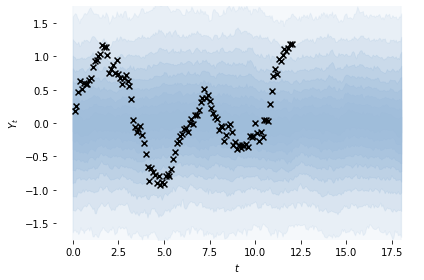

 10%|▉         | 49/500 [00:18<02:44,  2.75it/s]

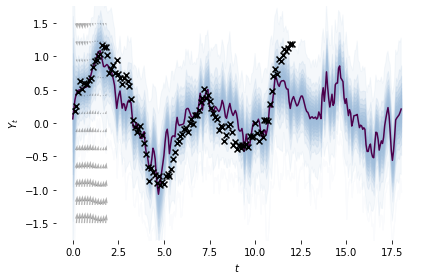

 20%|█▉        | 99/500 [00:37<02:27,  2.73it/s]

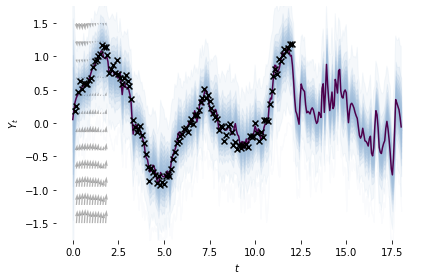

 30%|██▉       | 149/500 [00:56<02:06,  2.77it/s]

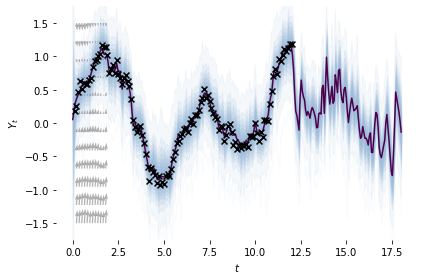

 40%|███▉      | 199/500 [01:16<01:49,  2.75it/s]

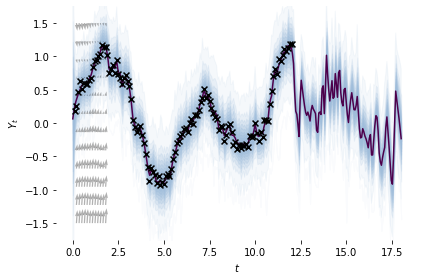

 50%|████▉     | 249/500 [01:35<01:31,  2.75it/s]

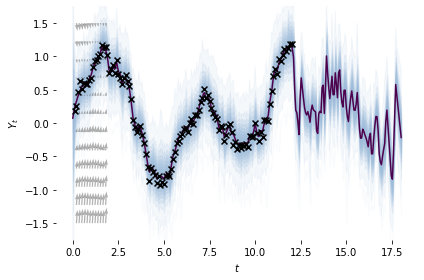

 60%|█████▉    | 299/500 [01:55<01:17,  2.59it/s]

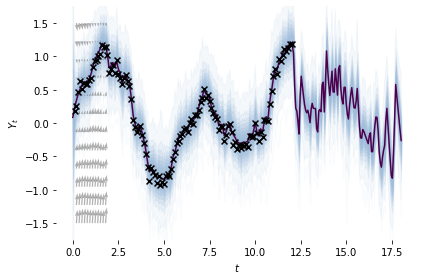

 70%|██████▉   | 349/500 [02:15<00:55,  2.72it/s]

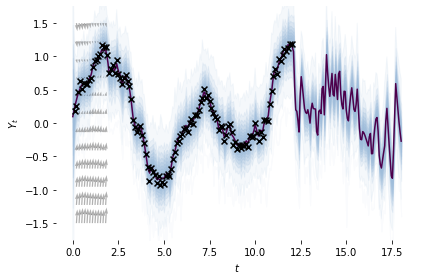

 80%|███████▉  | 399/500 [02:35<00:36,  2.78it/s]

 90%|████████▉ | 449/500 [02:55<00:23,  2.14it/s]

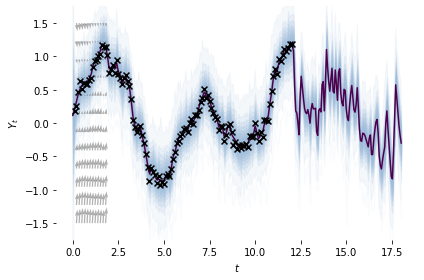

100%|█████████▉| 499/500 [03:16<00:00,  2.74it/s]

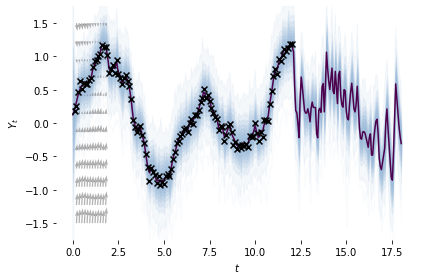

100%|██████████| 500/500 [03:17<00:00,  2.53it/s]


In [70]:
manual_seed(args.seed)

if args.debug:
    logging.getLogger().setLevel(logging.INFO)

ckpt_dir = os.path.join('./sim/', 'ckpts')
os.makedirs(ckpt_dir, exist_ok=True)

sdeint_fn = torchsde.sdeint_adjoint if args.adjoint else torchsde.sdeint
torch.cuda.empty_cache()
model = LatentSDE().to(device)
main(model)

# model with prior drift with sin function

In [76]:
class LatentSDE_with_sin(torchsde.SDEIto):

    def __init__(self, theta=0.5, mu=0.0, sigma=1.0):
        super(LatentSDE_with_sin, self).__init__(noise_type="diagonal")
        logvar = math.log(sigma ** 2 / (2. * theta))

        # Prior drift.
        self.register_buffer("theta", torch.tensor([[theta]]))
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma", torch.tensor([[sigma]]))

        # p(y0).
        self.register_buffer("py0_mean", torch.tensor([[mu]]))
        self.register_buffer("py0_logvar", torch.tensor([[logvar]]))

        # Approximate posterior drift: Takes in 2 positional encodings and the state.
        self.net = nn.Sequential(
            nn.Linear(7, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 1)
        )
        # Initialization trick from Glow.
        self.net[-1].weight.data.fill_(0.)
        self.net[-1].bias.data.fill_(0.)

        # q(y0).
        self.qy0_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=True)
        self.qy0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True)

    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            #t = torch.full_like(y, fill_value=t*100.0/132.0 )
            t = torch.full_like(y, fill_value=t )

        # Positional encoding in transformers for time-inhomogeneous posterior.
        #return self.net(torch.cat((torch.sin(t), torch.cos(t),  y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), torch.sin(t)**2, torch.cos(t)**2, y), dim=-1))
        return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), torch.sin(t**3), torch.cos(t**3), y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), y), dim=-1))
    
    def g(self, t, y):  # Shared diffusion.
        return self.sigma.repeat(y.size(0), 1)



    def h(self, t, y):  # Prior drift.
        sin = torch.sin(t)
        sin.repeat(y.size(0),1)
        return self.theta * (sin - y)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1]
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y)
        u = _stable_division(f - h, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y)
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=args.method,
            dt=args.dt,
            adaptive=args.adaptive,
            rtol=args.rtol,
            atol=args.atol,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt, names={'drift': 'h'})
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt, names={'drift': 'h'})

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt)
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt)

    @property
    def py0_std(self):
        return torch.exp(.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return torch.exp(.5 * self.qy0_logvar)

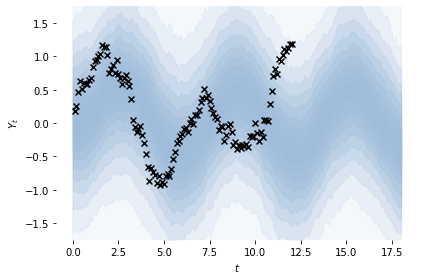

 10%|▉         | 49/500 [00:18<02:43,  2.76it/s]

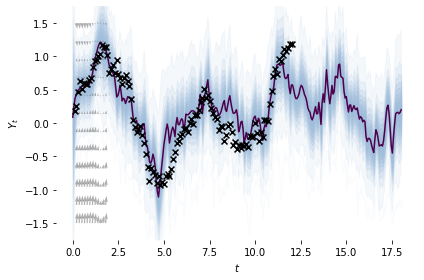

 20%|█▉        | 99/500 [00:38<02:41,  2.48it/s]

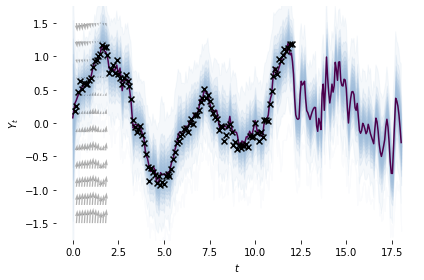

 30%|██▉       | 149/500 [01:02<02:46,  2.11it/s]

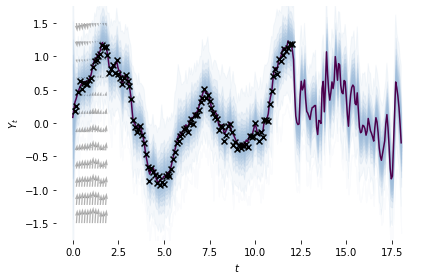

 40%|███▉      | 199/500 [01:28<02:17,  2.19it/s]

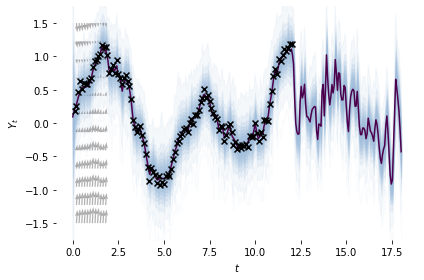

 50%|████▉     | 249/500 [02:10<02:16,  1.83it/s]

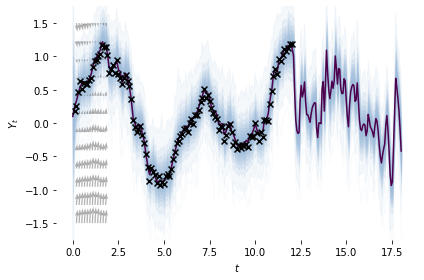

 60%|█████▉    | 299/500 [02:35<01:48,  1.85it/s]

 70%|██████▉   | 349/500 [03:00<01:18,  1.91it/s]

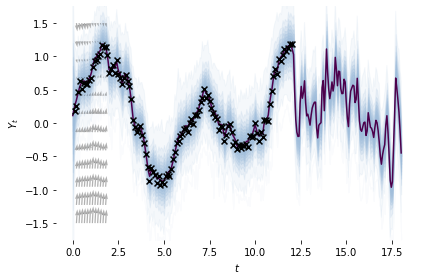

 80%|███████▉  | 399/500 [03:30<00:47,  2.15it/s]

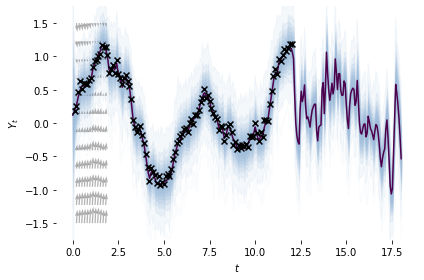

 90%|████████▉ | 449/500 [03:57<00:19,  2.60it/s]

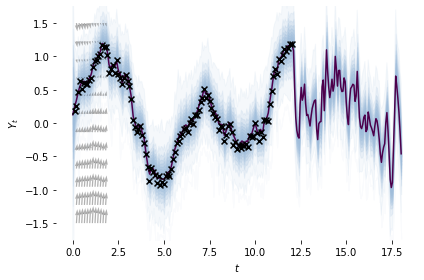

100%|█████████▉| 499/500 [04:18<00:00,  2.69it/s]

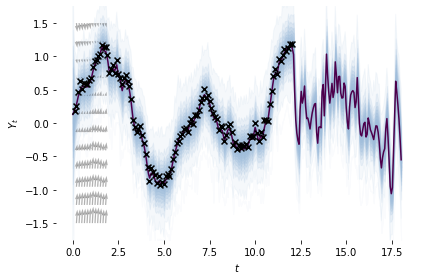

100%|██████████| 500/500 [04:19<00:00,  1.93it/s]


In [77]:
model_sin = LatentSDE_with_sin().to(device)
main(model_sin)

# model with learnable sin function

In [84]:
class LatentSDE_with_learnable_sin(torchsde.SDEIto):

    def __init__(self, theta=0.5, mu=0.0, sigma=1.0):
        super(LatentSDE_with_learnable_sin, self).__init__(noise_type="diagonal")
        logvar = math.log(sigma ** 2 / (2. * theta))

        # Prior drift.
        self.register_buffer("theta", torch.tensor([[theta]]))
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma", torch.tensor([[sigma]]))

        # p(y0).
        self.register_buffer("py0_mean", torch.tensor([[mu]]))
        self.register_buffer("py0_logvar", torch.tensor([[logvar]]))

        # Approximate posterior drift: Takes in 2 positional encodings and the state.
        self.net = nn.Sequential(
            nn.Linear(7, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 1)
        )
        # Initialization trick from Glow.
        self.net[-1].weight.data.fill_(0.)
        self.net[-1].bias.data.fill_(0.)

        # q(y0).
        self.qy0_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=True)
        self.qy0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True)

        self.A = nn.Parameter(torch.tensor(1.),requires_grad=True)
        self.w = nn.Parameter(torch.tensor(1.),requires_grad=True)
        self.phi = nn.Parameter(torch.tensor(0.),requires_grad=True)
        self.k = nn.Parameter(torch.tensor(0.),requires_grad=True)
        
    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            #t = torch.full_like(y, fill_value=t*100.0/132.0 )
            t = torch.full_like(y, fill_value=t )

        # Positional encoding in transformers for time-inhomogeneous posterior.
        #return self.net(torch.cat((torch.sin(t), torch.cos(t),  y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), torch.sin(t)**2, torch.cos(t)**2, y), dim=-1))
        return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), torch.sin(t**3), torch.cos(t**3), y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), y), dim=-1))
    
    def g(self, t, y):  # Shared diffusion.
        return self.sigma.repeat(y.size(0), 1)



    def h(self, t, y):  # Prior drift.
        sin = self.A*torch.sin(self.w*t+self.phi) + self.k
        sin.repeat(y.size(0),1)
        return self.theta * (sin - y)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1]
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y)
        u = _stable_division(f - h, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y)
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=args.method,
            dt=args.dt,
            adaptive=args.adaptive,
            rtol=args.rtol,
            atol=args.atol,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt, names={'drift': 'h'})
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt, names={'drift': 'h'})

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt)
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt)

    @property
    def py0_std(self):
        return torch.exp(.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return torch.exp(.5 * self.qy0_logvar)

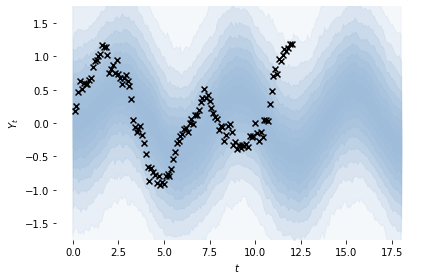

 10%|▉         | 49/500 [00:19<02:53,  2.60it/s]

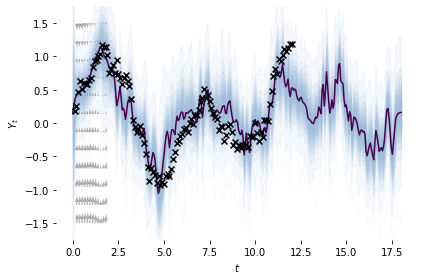

 20%|█▉        | 99/500 [00:39<02:27,  2.71it/s]

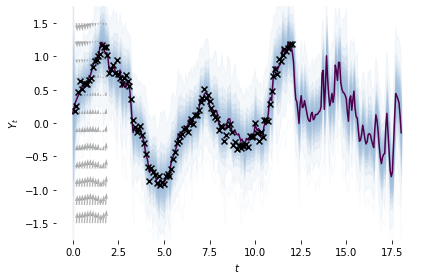

 30%|██▉       | 149/500 [00:59<02:10,  2.68it/s]

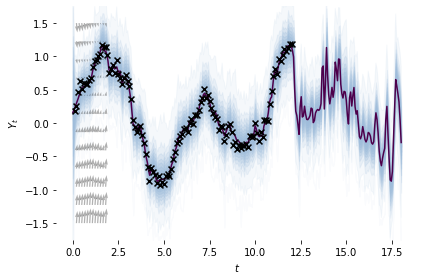

 40%|███▉      | 199/500 [01:19<01:51,  2.70it/s]

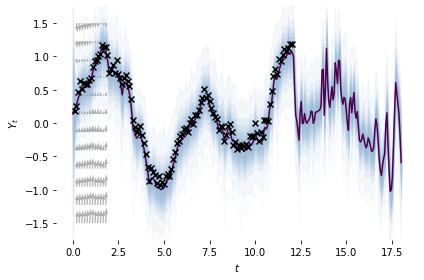

 50%|████▉     | 249/500 [01:38<01:32,  2.70it/s]

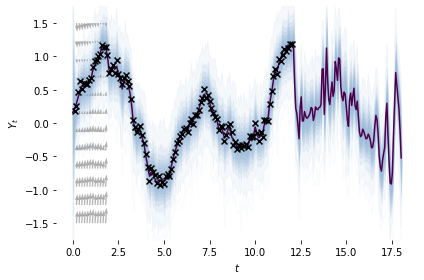

 60%|█████▉    | 299/500 [01:59<01:14,  2.69it/s]

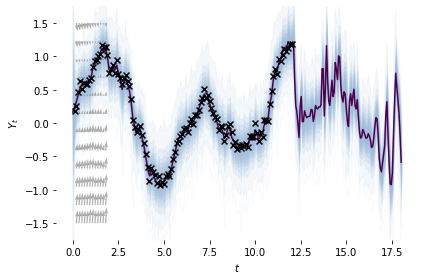

 70%|██████▉   | 349/500 [02:18<00:55,  2.71it/s]

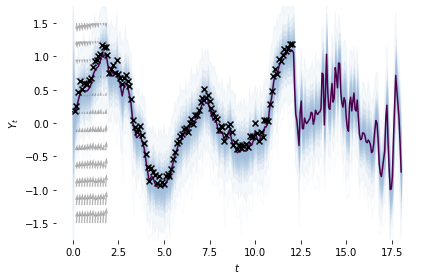

 80%|███████▉  | 399/500 [02:38<00:38,  2.60it/s]

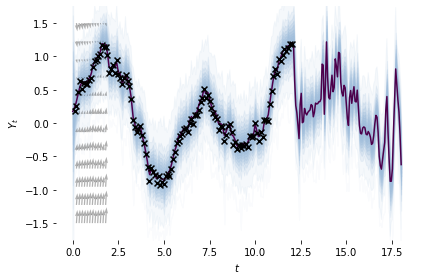

 90%|████████▉ | 449/500 [02:59<00:18,  2.71it/s]

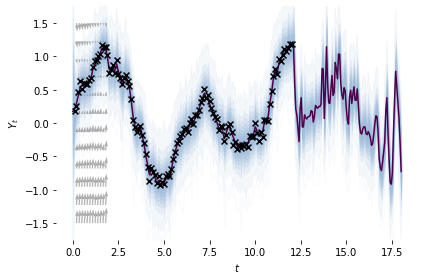

100%|█████████▉| 499/500 [03:19<00:00,  2.63it/s]

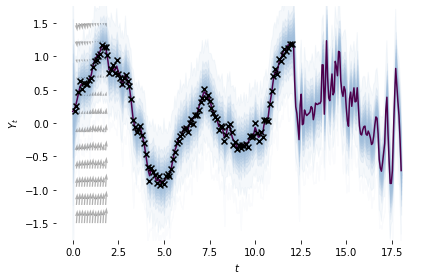

100%|██████████| 500/500 [03:20<00:00,  2.49it/s]


In [85]:
model_learnable_sin = LatentSDE_with_learnable_sin().to(device)
main(model_learnable_sin)

# (Part 2) 

## analyze this term || likelihood of samples (generated by z) - likelihood of AR(1) || without adding it to the loss function

In [212]:
class LatentSDE_testing(torchsde.SDEIto):

    def __init__(self, theta=0.5, mu=0.0, sigma=1.0):
        super(LatentSDE_testing, self).__init__(noise_type="diagonal")
        logvar = math.log(sigma ** 2 / (2. * theta))

        # Prior drift.
        self.register_buffer("theta", torch.tensor([[theta]]))
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma", torch.tensor([[sigma]]))

        # p(y0).
        self.register_buffer("py0_mean", torch.tensor([[mu]]))
        self.register_buffer("py0_logvar", torch.tensor([[logvar]]))

        # Approximate posterior drift: Takes in 2 positional encodings and the state.
        self.net = nn.Sequential(
            nn.Linear(3, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 1)
        )
        # Initialization trick from Glow.
        self.net[-1].weight.data.fill_(0.)
        self.net[-1].bias.data.fill_(0.)

        # q(y0).
        self.qy0_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=True)
        self.qy0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True)

        self.A = nn.Parameter(torch.tensor(1.),requires_grad=True)
        self.w = nn.Parameter(torch.tensor(1.),requires_grad=True)
        self.phi = nn.Parameter(torch.tensor(0.),requires_grad=True)
        self.k = nn.Parameter(torch.tensor(0.),requires_grad=True)
        
    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            #t = torch.full_like(y, fill_value=t*100.0/132.0 )
            t = torch.full_like(y, fill_value=t )

        # Positional encoding in transformers for time-inhomogeneous posterior.
        return self.net(torch.cat((torch.sin(t), torch.cos(t),  y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), torch.sin(t**3), torch.cos(t**3), y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), y), dim=-1))
    
    def g(self, t, y):  # Shared diffusion.
        return self.sigma.repeat(y.size(0), 1)



    def h(self, t, y):  # Prior drift.
        #sin = self.A*torch.sin(self.w*t+self.phi) + self.k
        #sin.repeat(y.size(0),1)
        return self.theta * (self.mu - y)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1]
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y)
        u = _stable_division(f - h, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y)
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=args.method,
            dt=args.dt,
            adaptive=args.adaptive,
            rtol=args.rtol,
            atol=args.atol,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt, names={'drift': 'h'})
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt, names={'drift': 'h'})

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt)
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt)

    @property
    def py0_std(self):
        return torch.exp(.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return torch.exp(.5 * self.qy0_logvar)

In [213]:

torch.pi = torch.acos(torch.zeros(1)).item() * 2
def log_likelihood(p,r):
    T = r.shape[0]
    t = np.linspace(1,T,T)
    c = 0.1*np.sin(2*np.pi*t/s)
    epsilon = np.zeros(T)
    for i in range(1,T):
        epsilon[i] = r[i] - phi*r[i-1] - c[i]
    ll = -0.5 * (T - p) * np.log(2 * np.pi) - 0.5 * (T - p) * np.log(sigma ** 2) - 0.5 * np.dot(epsilon, epsilon) * sigma ** (-2)
    return ll

In [214]:
ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()

In [215]:
llg = log_likelihood(1,ys)

In [216]:
torch.pi = torch.acos(torch.zeros(1)).item() * 2
def log_likelihood_batch(p,rm):
    T = rm.shape[1]
    t = torch.linspace(1,T,T)
    c = 0.1*torch.sin(2*torch.pi*t/s)
    lls = torch.zeros(rm.shape[0])
    for i in range(len(rm)):
        r = rm[i]
        epsilon = torch.zeros(T)
        for i in range(1,T):
            epsilon[i] = r[i] - phi*r[i-1] - c[i]
        sigma = torch.std(epsilon)
        ll = -0.5 * (T - p) * math.log(2 * torch.pi) - 0.5 * (T - p) * math.log(sigma ** 2) 
        ll = ll - 0.5 * torch.dot(epsilon, epsilon) * sigma ** (-2)
        lls[i] = ll
    return lls

In [217]:
def main_testing(model):
    # Dataset.
    ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()
    llg = log_likelihood(1,ys)
    # Plotting parameters.
    vis_batch_size = 1024
    ylims = (-1.75, 1.75)
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = np.random.permutation(vis_batch_size)
    # From https://colorbrewer2.org/.
    if args.color == "blue":
        sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
        fill_color = '#9ebcda'
        mean_color = '#4d004b'
        num_samples = len(sample_colors)
    else:
        sample_colors = ('#fc4e2a', '#e31a1c', '#bd0026')
        fill_color = '#fd8d3c'
        mean_color = '#800026'
        num_samples = len(sample_colors)

    eps = torch.randn(vis_batch_size, 1).to(device)  # Fix seed for the random draws used in the plots.
    bm = torchsde.BrownianInterval(
        t0=ts_vis[0],
        t1=ts_vis[-1],
        size=(vis_batch_size, 1),
        device=device,
        levy_area_approximation='space-time'
    )  # We need space-time Levy area to use the SRK solver

    # Model.
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
    kl_scheduler = LinearScheduler(iters=args.kl_anneal_iters)
    criterion = nn.MSELoss()

    logpy_metric = EMAMetric()
    kl_metric = EMAMetric()
    loss_metric = EMAMetric()
    logpy_list = []
    if args.show_prior:
        with torch.no_grad():
            zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
            ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
            zs_ = np.sort(zs_, axis=1)

            img_dir = os.path.join(args.train_dir, 'prior.png')
            plt.subplot(frameon=False)
            for alpha, percentile in zip(alphas, percentiles):
                idx = int((1 - percentile) / 2. * vis_batch_size)
                zs_bot_ = zs_[:, idx]
                zs_top_ = zs_[:, -idx]
                plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

            # `zorder` determines who's on top; the larger the more at the top.
            plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')
            plt.tight_layout()
            plt.savefig(img_dir, dpi=args.dpi)
            plt.show()
            plt.close()
            logging.info(f'Saved prior figure at: {img_dir}')

    for global_step in tqdm.tqdm(range(args.train_iters)):
        # Plot and save.
        if (global_step+1) % args.pause_iters == 0:
            img_path = os.path.join(args.train_dir, f'global_step_{global_step+1}.png')

            with torch.no_grad():
                zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
                samples = zs[:, vis_idx]
                ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
                zs_ = np.sort(zs_, axis=1)
                plt.subplot(frameon=False)

                if args.show_percentiles:
                    for alpha, percentile in zip(alphas, percentiles):
                        idx = int((1 - percentile) / 2. * vis_batch_size)
                        zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
                        plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

                if args.show_mean:
                    plt.plot(ts_vis_, zs_.mean(axis=1), color=mean_color)

                if args.show_samples:
                    for j in range(num_samples):
                        plt.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=1.0)

                if args.show_arrows:
                    num, dt = 12, 0.12
                    t, y = torch.meshgrid(
                        [torch.linspace(0.2, 1.8, num).to(device), torch.linspace(-1.5, 1.5, num).to(device)]
                    )
                    t, y = t.reshape(-1, 1), y.reshape(-1, 1)
                    fty = model.f(t=t, y=y).reshape(num, num)
                    dt = torch.zeros(num, num).fill_(dt).to(device)
                    dy = fty * dt
                    dt_, dy_, t_, y_ = dt.cpu().numpy(), dy.cpu().numpy(), t.cpu().numpy(), y.cpu().numpy()
                    plt.quiver(t_, y_, dt_, dy_, alpha=0.3, edgecolors='k', width=0.0035, scale=50)

                if args.hide_ticks:
                    plt.xticks([], [])
                    plt.yticks([], [])

                plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
                plt.ylim(ylims)
                plt.xlabel('$t$')
                plt.ylabel('$Y_t$')
                plt.tight_layout()
                plt.savefig(img_path, dpi=args.dpi)
                plt.show()
                plt.close()
                logging.info(f'Saved figure at: {img_path}')

                if args.save_ckpt:
                    torch.save(
                        {'model': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'kl_scheduler': kl_scheduler},
                        os.path.join(ckpt_dir, f'global_step_{global_step}.ckpt')
                    )

        # Train.
        optimizer.zero_grad()
        zs, kl = model(ts=ts_ext, batch_size=args.batch_size)
        zs = zs.squeeze()
        zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.

        likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
        likelihood = likelihood_constructor(loc=zs, scale=args.scale)
        logpy = likelihood.log_prob(ys).sum(dim=0).mean(dim=0)
        #llg = log_likelihood(1,zs.permute([1,0]).squeeze(),120).mean()
        llg_loss = torch.sqrt((likelihood.log_prob(ys).sum(dim=0)-llg)**2).mean()
        print(llg_loss)
        #print(likelihood.log_prob(ys).mean(dim=1).shape)
        loss = -logpy + kl* kl_scheduler.val
        logpy_list.append(logpy.item())
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

        logpy_metric.step(logpy)
        kl_metric.step(kl)
        loss_metric.step(loss)

        logging.info(
            f'global_step: {global_step}, '
            f'logpy: {logpy_metric.val:.3f}, '
            f'kl: {kl_metric.val:.3f}, '
            f'llg_loss: {llg_loss:.3f}, '
            f'loss: {loss_metric.val:.3f}'
        )
    return logpy_list


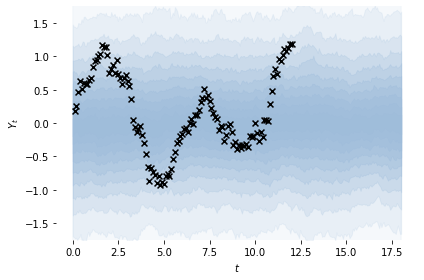

  0%|          | 1/500 [00:00<03:42,  2.24it/s]

tensor(4818.0229, grad_fn=<MeanBackward0>)


  0%|          | 2/500 [00:00<03:34,  2.33it/s]

tensor(3802.5879, grad_fn=<MeanBackward0>)


  1%|          | 3/500 [00:01<03:25,  2.41it/s]

tensor(1902.9111, grad_fn=<MeanBackward0>)


  1%|          | 4/500 [00:01<03:21,  2.47it/s]

tensor(1381.7566, grad_fn=<MeanBackward0>)


  1%|          | 5/500 [00:02<03:23,  2.44it/s]

tensor(1177.2499, grad_fn=<MeanBackward0>)


  1%|          | 6/500 [00:02<03:19,  2.47it/s]

tensor(1083.5898, grad_fn=<MeanBackward0>)


  1%|▏         | 7/500 [00:02<03:18,  2.48it/s]

tensor(1037.6553, grad_fn=<MeanBackward0>)


  2%|▏         | 8/500 [00:03<03:17,  2.50it/s]

tensor(1018.5119, grad_fn=<MeanBackward0>)


  2%|▏         | 9/500 [00:03<03:21,  2.44it/s]

tensor(1015.7856, grad_fn=<MeanBackward0>)


  2%|▏         | 10/500 [00:04<03:16,  2.49it/s]

tensor(1025.3645, grad_fn=<MeanBackward0>)


  2%|▏         | 11/500 [00:04<03:15,  2.50it/s]

tensor(1049.7692, grad_fn=<MeanBackward0>)


  2%|▏         | 12/500 [00:04<03:14,  2.51it/s]

tensor(1084.2267, grad_fn=<MeanBackward0>)


  3%|▎         | 13/500 [00:05<03:14,  2.50it/s]

tensor(1104.2516, grad_fn=<MeanBackward0>)


  3%|▎         | 14/500 [00:05<03:11,  2.53it/s]

tensor(1102.5491, grad_fn=<MeanBackward0>)


  3%|▎         | 15/500 [00:05<03:08,  2.58it/s]

tensor(1084.2289, grad_fn=<MeanBackward0>)


  3%|▎         | 16/500 [00:06<03:04,  2.62it/s]

tensor(1060.0703, grad_fn=<MeanBackward0>)


  3%|▎         | 17/500 [00:06<03:03,  2.63it/s]

tensor(1043.2969, grad_fn=<MeanBackward0>)


  4%|▎         | 18/500 [00:07<03:04,  2.61it/s]

tensor(1025.9753, grad_fn=<MeanBackward0>)


  4%|▍         | 19/500 [00:07<03:02,  2.64it/s]

tensor(1015.8875, grad_fn=<MeanBackward0>)


  4%|▍         | 20/500 [00:07<03:00,  2.67it/s]

tensor(1013.0131, grad_fn=<MeanBackward0>)


  4%|▍         | 21/500 [00:08<02:57,  2.69it/s]

tensor(1002.4017, grad_fn=<MeanBackward0>)


  4%|▍         | 22/500 [00:08<02:57,  2.70it/s]

tensor(995.7064, grad_fn=<MeanBackward0>)


  5%|▍         | 23/500 [00:08<02:56,  2.70it/s]

tensor(993.8708, grad_fn=<MeanBackward0>)


  5%|▍         | 24/500 [00:09<02:55,  2.72it/s]

tensor(987.2910, grad_fn=<MeanBackward0>)


  5%|▌         | 25/500 [00:09<02:54,  2.72it/s]

tensor(984.7925, grad_fn=<MeanBackward0>)


  5%|▌         | 26/500 [00:10<02:55,  2.70it/s]

tensor(994.6176, grad_fn=<MeanBackward0>)


  5%|▌         | 27/500 [00:10<02:53,  2.72it/s]

tensor(996.2231, grad_fn=<MeanBackward0>)


  6%|▌         | 28/500 [00:10<02:52,  2.74it/s]

tensor(999.4168, grad_fn=<MeanBackward0>)


  6%|▌         | 29/500 [00:11<02:50,  2.76it/s]

tensor(1001.7216, grad_fn=<MeanBackward0>)


  6%|▌         | 30/500 [00:11<02:50,  2.76it/s]

tensor(1005.7075, grad_fn=<MeanBackward0>)


  6%|▌         | 31/500 [00:11<02:49,  2.77it/s]

tensor(1000.7475, grad_fn=<MeanBackward0>)


  6%|▋         | 32/500 [00:12<02:48,  2.77it/s]

tensor(1000.9796, grad_fn=<MeanBackward0>)


  7%|▋         | 33/500 [00:12<02:48,  2.77it/s]

tensor(1006.0938, grad_fn=<MeanBackward0>)


  7%|▋         | 34/500 [00:12<02:48,  2.77it/s]

tensor(1003.8593, grad_fn=<MeanBackward0>)


  7%|▋         | 35/500 [00:13<02:47,  2.77it/s]

tensor(1003.0220, grad_fn=<MeanBackward0>)


  7%|▋         | 36/500 [00:13<02:47,  2.77it/s]

tensor(993.0699, grad_fn=<MeanBackward0>)


  7%|▋         | 37/500 [00:14<02:47,  2.77it/s]

tensor(996.5491, grad_fn=<MeanBackward0>)


  8%|▊         | 38/500 [00:14<02:46,  2.77it/s]

tensor(986.0026, grad_fn=<MeanBackward0>)


  8%|▊         | 39/500 [00:14<02:45,  2.78it/s]

tensor(999.0237, grad_fn=<MeanBackward0>)


  8%|▊         | 40/500 [00:15<02:45,  2.78it/s]

tensor(985.3744, grad_fn=<MeanBackward0>)


  8%|▊         | 41/500 [00:15<02:45,  2.77it/s]

tensor(994.7153, grad_fn=<MeanBackward0>)


  8%|▊         | 42/500 [00:15<02:45,  2.76it/s]

tensor(990.2405, grad_fn=<MeanBackward0>)


  9%|▊         | 43/500 [00:16<02:45,  2.77it/s]

tensor(988.8813, grad_fn=<MeanBackward0>)


  9%|▉         | 44/500 [00:16<02:44,  2.76it/s]

tensor(984.8314, grad_fn=<MeanBackward0>)


  9%|▉         | 45/500 [00:16<02:44,  2.77it/s]

tensor(986.2041, grad_fn=<MeanBackward0>)


  9%|▉         | 46/500 [00:17<02:43,  2.77it/s]

tensor(987.8420, grad_fn=<MeanBackward0>)


  9%|▉         | 47/500 [00:17<02:43,  2.78it/s]

tensor(987.0787, grad_fn=<MeanBackward0>)


 10%|▉         | 48/500 [00:17<02:43,  2.77it/s]

tensor(984.2415, grad_fn=<MeanBackward0>)


 10%|▉         | 49/500 [00:18<02:42,  2.78it/s]

tensor(986.2700, grad_fn=<MeanBackward0>)


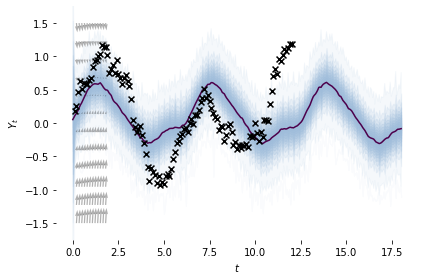

 10%|█         | 50/500 [00:19<04:57,  1.51it/s]

tensor(984.2080, grad_fn=<MeanBackward0>)


 10%|█         | 51/500 [00:20<04:17,  1.75it/s]

tensor(981.8300, grad_fn=<MeanBackward0>)


 10%|█         | 52/500 [00:20<03:49,  1.95it/s]

tensor(982.2933, grad_fn=<MeanBackward0>)


 11%|█         | 53/500 [00:20<03:35,  2.08it/s]

tensor(983.1839, grad_fn=<MeanBackward0>)


 11%|█         | 54/500 [00:21<03:20,  2.22it/s]

tensor(980.5001, grad_fn=<MeanBackward0>)


 11%|█         | 55/500 [00:21<03:12,  2.32it/s]

tensor(982.0378, grad_fn=<MeanBackward0>)


 11%|█         | 56/500 [00:21<03:03,  2.43it/s]

tensor(981.8589, grad_fn=<MeanBackward0>)


 11%|█▏        | 57/500 [00:22<03:02,  2.43it/s]

tensor(982.8729, grad_fn=<MeanBackward0>)


 12%|█▏        | 58/500 [00:22<02:56,  2.51it/s]

tensor(986.2506, grad_fn=<MeanBackward0>)


 12%|█▏        | 59/500 [00:23<02:51,  2.58it/s]

tensor(987.1866, grad_fn=<MeanBackward0>)


 12%|█▏        | 60/500 [00:23<02:48,  2.60it/s]

tensor(986.6038, grad_fn=<MeanBackward0>)


 12%|█▏        | 61/500 [00:23<02:45,  2.65it/s]

tensor(987.7972, grad_fn=<MeanBackward0>)


 12%|█▏        | 62/500 [00:24<02:44,  2.66it/s]

tensor(988.4703, grad_fn=<MeanBackward0>)


 13%|█▎        | 63/500 [00:24<02:44,  2.65it/s]

tensor(986.7021, grad_fn=<MeanBackward0>)


 13%|█▎        | 64/500 [00:24<02:42,  2.69it/s]

tensor(989.7941, grad_fn=<MeanBackward0>)


 13%|█▎        | 65/500 [00:25<02:40,  2.71it/s]

tensor(988.0175, grad_fn=<MeanBackward0>)


 13%|█▎        | 66/500 [00:25<02:38,  2.73it/s]

tensor(984.7799, grad_fn=<MeanBackward0>)


 13%|█▎        | 67/500 [00:26<02:37,  2.74it/s]

tensor(984.0964, grad_fn=<MeanBackward0>)


 14%|█▎        | 68/500 [00:26<02:37,  2.75it/s]

tensor(988.2236, grad_fn=<MeanBackward0>)


 14%|█▍        | 69/500 [00:26<02:36,  2.76it/s]

tensor(982.1678, grad_fn=<MeanBackward0>)


 14%|█▍        | 70/500 [00:27<02:35,  2.76it/s]

tensor(989.1299, grad_fn=<MeanBackward0>)


 14%|█▍        | 71/500 [00:27<02:35,  2.76it/s]

tensor(986.5183, grad_fn=<MeanBackward0>)


 14%|█▍        | 72/500 [00:27<02:34,  2.77it/s]

tensor(986.7328, grad_fn=<MeanBackward0>)


 15%|█▍        | 73/500 [00:28<02:34,  2.76it/s]

tensor(989.0783, grad_fn=<MeanBackward0>)


 15%|█▍        | 74/500 [00:28<02:34,  2.76it/s]

tensor(987.5110, grad_fn=<MeanBackward0>)


 15%|█▌        | 75/500 [00:28<02:33,  2.77it/s]

tensor(990.2501, grad_fn=<MeanBackward0>)


 15%|█▌        | 76/500 [00:29<02:33,  2.77it/s]

tensor(991.5056, grad_fn=<MeanBackward0>)


 15%|█▌        | 77/500 [00:29<02:34,  2.73it/s]

tensor(992.4613, grad_fn=<MeanBackward0>)


 16%|█▌        | 78/500 [00:30<02:35,  2.71it/s]

tensor(983.8444, grad_fn=<MeanBackward0>)


 16%|█▌        | 79/500 [00:30<02:36,  2.68it/s]

tensor(986.0541, grad_fn=<MeanBackward0>)


 16%|█▌        | 80/500 [00:30<02:37,  2.67it/s]

tensor(994.7793, grad_fn=<MeanBackward0>)


 16%|█▌        | 81/500 [00:31<02:37,  2.65it/s]

tensor(985.4595, grad_fn=<MeanBackward0>)


 16%|█▋        | 82/500 [00:31<02:39,  2.62it/s]

tensor(988.7285, grad_fn=<MeanBackward0>)


 17%|█▋        | 83/500 [00:31<02:38,  2.63it/s]

tensor(989.3568, grad_fn=<MeanBackward0>)


 17%|█▋        | 84/500 [00:32<02:37,  2.64it/s]

tensor(992.2932, grad_fn=<MeanBackward0>)


 17%|█▋        | 85/500 [00:32<02:36,  2.65it/s]

tensor(986.3624, grad_fn=<MeanBackward0>)


 17%|█▋        | 86/500 [00:33<02:34,  2.67it/s]

tensor(986.9911, grad_fn=<MeanBackward0>)


 17%|█▋        | 87/500 [00:33<02:33,  2.69it/s]

tensor(985.9556, grad_fn=<MeanBackward0>)


 18%|█▊        | 88/500 [00:33<02:32,  2.71it/s]

tensor(987.8508, grad_fn=<MeanBackward0>)


 18%|█▊        | 89/500 [00:34<02:31,  2.71it/s]

tensor(984.2609, grad_fn=<MeanBackward0>)


 18%|█▊        | 90/500 [00:34<02:30,  2.72it/s]

tensor(985.5680, grad_fn=<MeanBackward0>)


 18%|█▊        | 91/500 [00:34<02:29,  2.73it/s]

tensor(981.4037, grad_fn=<MeanBackward0>)


 18%|█▊        | 92/500 [00:35<02:29,  2.73it/s]

tensor(985.7676, grad_fn=<MeanBackward0>)


 19%|█▊        | 93/500 [00:35<02:30,  2.71it/s]

tensor(981.3146, grad_fn=<MeanBackward0>)


 19%|█▉        | 94/500 [00:36<02:29,  2.71it/s]

tensor(987.1000, grad_fn=<MeanBackward0>)


 19%|█▉        | 95/500 [00:36<02:31,  2.67it/s]

tensor(986.2148, grad_fn=<MeanBackward0>)


 19%|█▉        | 96/500 [00:36<02:31,  2.67it/s]

tensor(988.8472, grad_fn=<MeanBackward0>)


 19%|█▉        | 97/500 [00:37<02:31,  2.67it/s]

tensor(990.4286, grad_fn=<MeanBackward0>)


 20%|█▉        | 98/500 [00:37<02:30,  2.67it/s]

tensor(992.1480, grad_fn=<MeanBackward0>)


 20%|█▉        | 99/500 [00:37<02:29,  2.68it/s]

tensor(986.5833, grad_fn=<MeanBackward0>)


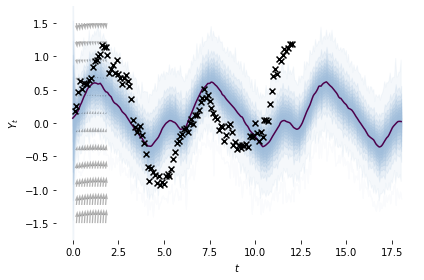

 20%|██        | 100/500 [00:39<04:34,  1.46it/s]

tensor(981.9525, grad_fn=<MeanBackward0>)


 20%|██        | 101/500 [00:39<03:58,  1.67it/s]

tensor(984.1109, grad_fn=<MeanBackward0>)


 20%|██        | 102/500 [00:40<03:32,  1.87it/s]

tensor(986.6057, grad_fn=<MeanBackward0>)


 21%|██        | 103/500 [00:40<03:16,  2.02it/s]

tensor(985.9676, grad_fn=<MeanBackward0>)


 21%|██        | 104/500 [00:40<03:02,  2.17it/s]

tensor(988.5145, grad_fn=<MeanBackward0>)


 21%|██        | 105/500 [00:41<02:54,  2.26it/s]

tensor(990.2502, grad_fn=<MeanBackward0>)
tensor(988.2912, grad_fn=<MeanBackward0>)


 21%|██▏       | 107/500 [00:42<02:46,  2.36it/s]

tensor(993.7556, grad_fn=<MeanBackward0>)


 22%|██▏       | 108/500 [00:42<02:42,  2.41it/s]

tensor(993.7750, grad_fn=<MeanBackward0>)


 22%|██▏       | 109/500 [00:42<02:38,  2.46it/s]

tensor(990.6854, grad_fn=<MeanBackward0>)


 22%|██▏       | 110/500 [00:43<02:33,  2.53it/s]

tensor(985.8701, grad_fn=<MeanBackward0>)


 22%|██▏       | 111/500 [00:43<02:31,  2.57it/s]

tensor(988.4837, grad_fn=<MeanBackward0>)


 22%|██▏       | 112/500 [00:43<02:27,  2.63it/s]

tensor(991.7265, grad_fn=<MeanBackward0>)


 23%|██▎       | 113/500 [00:44<02:25,  2.67it/s]

tensor(991.1844, grad_fn=<MeanBackward0>)


 23%|██▎       | 114/500 [00:44<02:23,  2.68it/s]

tensor(995.5571, grad_fn=<MeanBackward0>)


 23%|██▎       | 115/500 [00:45<02:21,  2.71it/s]

tensor(986.2614, grad_fn=<MeanBackward0>)


 23%|██▎       | 116/500 [00:45<02:20,  2.73it/s]

tensor(986.1827, grad_fn=<MeanBackward0>)


 23%|██▎       | 117/500 [00:45<02:19,  2.74it/s]

tensor(985.1783, grad_fn=<MeanBackward0>)


 24%|██▎       | 118/500 [00:46<02:18,  2.76it/s]

tensor(987.7496, grad_fn=<MeanBackward0>)


 24%|██▍       | 119/500 [00:46<02:17,  2.76it/s]

tensor(987.7441, grad_fn=<MeanBackward0>)


 24%|██▍       | 120/500 [00:46<02:17,  2.77it/s]

tensor(989.9925, grad_fn=<MeanBackward0>)


 24%|██▍       | 121/500 [00:47<02:16,  2.77it/s]

tensor(990.0933, grad_fn=<MeanBackward0>)


 24%|██▍       | 122/500 [00:47<02:16,  2.78it/s]

tensor(980.7349, grad_fn=<MeanBackward0>)


 25%|██▍       | 123/500 [00:47<02:16,  2.77it/s]

tensor(988.9976, grad_fn=<MeanBackward0>)


 25%|██▍       | 124/500 [00:48<02:22,  2.63it/s]

tensor(982.4902, grad_fn=<MeanBackward0>)


 25%|██▌       | 125/500 [00:48<02:21,  2.66it/s]

tensor(986.9777, grad_fn=<MeanBackward0>)


 25%|██▌       | 126/500 [00:49<02:18,  2.69it/s]

tensor(986.9846, grad_fn=<MeanBackward0>)


 25%|██▌       | 127/500 [00:49<02:17,  2.72it/s]

tensor(989.1141, grad_fn=<MeanBackward0>)


 26%|██▌       | 128/500 [00:49<02:15,  2.74it/s]

tensor(985.9338, grad_fn=<MeanBackward0>)


 26%|██▌       | 129/500 [00:50<02:14,  2.75it/s]

tensor(990.1676, grad_fn=<MeanBackward0>)


 26%|██▌       | 130/500 [00:50<02:14,  2.75it/s]

tensor(985.7659, grad_fn=<MeanBackward0>)


 26%|██▌       | 131/500 [00:50<02:13,  2.77it/s]

tensor(986.5450, grad_fn=<MeanBackward0>)


 26%|██▋       | 132/500 [00:51<02:12,  2.77it/s]

tensor(983.9312, grad_fn=<MeanBackward0>)


 27%|██▋       | 133/500 [00:51<02:12,  2.77it/s]

tensor(987.3796, grad_fn=<MeanBackward0>)


 27%|██▋       | 134/500 [00:51<02:11,  2.78it/s]

tensor(986.7552, grad_fn=<MeanBackward0>)


 27%|██▋       | 135/500 [00:52<02:11,  2.77it/s]

tensor(996.3492, grad_fn=<MeanBackward0>)


 27%|██▋       | 136/500 [00:52<02:11,  2.77it/s]

tensor(981.4673, grad_fn=<MeanBackward0>)


 27%|██▋       | 137/500 [00:53<02:11,  2.77it/s]

tensor(983.6230, grad_fn=<MeanBackward0>)


 28%|██▊       | 138/500 [00:53<02:10,  2.77it/s]

tensor(985.9580, grad_fn=<MeanBackward0>)


 28%|██▊       | 139/500 [00:53<02:10,  2.77it/s]

tensor(984.5657, grad_fn=<MeanBackward0>)


 28%|██▊       | 140/500 [00:54<02:09,  2.77it/s]

tensor(990.6643, grad_fn=<MeanBackward0>)


 28%|██▊       | 141/500 [00:54<02:09,  2.78it/s]

tensor(975.6304, grad_fn=<MeanBackward0>)


 28%|██▊       | 142/500 [00:54<02:09,  2.77it/s]

tensor(989.4921, grad_fn=<MeanBackward0>)


 29%|██▊       | 143/500 [00:55<02:08,  2.78it/s]

tensor(987.8838, grad_fn=<MeanBackward0>)


 29%|██▉       | 144/500 [00:55<02:10,  2.73it/s]

tensor(986.2905, grad_fn=<MeanBackward0>)


 29%|██▉       | 145/500 [00:55<02:09,  2.74it/s]

tensor(983.4126, grad_fn=<MeanBackward0>)


 29%|██▉       | 146/500 [00:56<02:08,  2.75it/s]

tensor(987.3599, grad_fn=<MeanBackward0>)


 29%|██▉       | 147/500 [00:56<02:08,  2.76it/s]

tensor(986.1597, grad_fn=<MeanBackward0>)


 30%|██▉       | 148/500 [00:57<02:07,  2.76it/s]

tensor(987.4330, grad_fn=<MeanBackward0>)


 30%|██▉       | 149/500 [00:57<02:07,  2.76it/s]

tensor(979.5260, grad_fn=<MeanBackward0>)


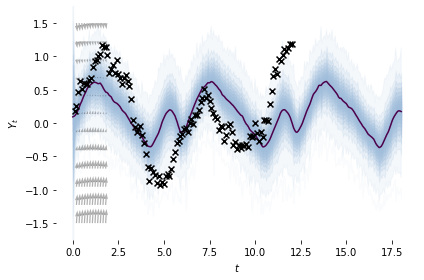

 30%|███       | 150/500 [00:58<03:51,  1.51it/s]

tensor(985.8675, grad_fn=<MeanBackward0>)


 30%|███       | 151/500 [00:59<03:21,  1.73it/s]

tensor(984.8107, grad_fn=<MeanBackward0>)


 30%|███       | 152/500 [00:59<02:59,  1.94it/s]

tensor(984.1049, grad_fn=<MeanBackward0>)


 31%|███       | 153/500 [00:59<02:44,  2.11it/s]

tensor(986.7279, grad_fn=<MeanBackward0>)


 31%|███       | 154/500 [01:00<02:33,  2.25it/s]

tensor(984.6670, grad_fn=<MeanBackward0>)


 31%|███       | 155/500 [01:00<02:26,  2.35it/s]

tensor(983.3495, grad_fn=<MeanBackward0>)


 31%|███       | 156/500 [01:01<02:20,  2.45it/s]

tensor(989.5717, grad_fn=<MeanBackward0>)


 31%|███▏      | 157/500 [01:01<02:19,  2.45it/s]

tensor(987.3070, grad_fn=<MeanBackward0>)


 32%|███▏      | 158/500 [01:01<02:16,  2.51it/s]

tensor(994.2236, grad_fn=<MeanBackward0>)


 32%|███▏      | 159/500 [01:02<02:12,  2.58it/s]

tensor(989.3393, grad_fn=<MeanBackward0>)


 32%|███▏      | 160/500 [01:02<02:12,  2.56it/s]

tensor(992.2816, grad_fn=<MeanBackward0>)


 32%|███▏      | 161/500 [01:02<02:10,  2.59it/s]

tensor(986.9490, grad_fn=<MeanBackward0>)


 32%|███▏      | 162/500 [01:03<02:08,  2.64it/s]

tensor(980.7834, grad_fn=<MeanBackward0>)


 33%|███▎      | 163/500 [01:03<02:06,  2.67it/s]

tensor(983.7595, grad_fn=<MeanBackward0>)


 33%|███▎      | 164/500 [01:04<02:04,  2.70it/s]

tensor(985.3231, grad_fn=<MeanBackward0>)


 33%|███▎      | 165/500 [01:04<02:03,  2.72it/s]

tensor(986.7745, grad_fn=<MeanBackward0>)


 33%|███▎      | 166/500 [01:04<02:02,  2.73it/s]

tensor(981.2968, grad_fn=<MeanBackward0>)


 33%|███▎      | 167/500 [01:05<02:01,  2.74it/s]

tensor(989.6730, grad_fn=<MeanBackward0>)


 34%|███▎      | 168/500 [01:05<02:00,  2.75it/s]

tensor(983.1688, grad_fn=<MeanBackward0>)


 34%|███▍      | 169/500 [01:05<02:00,  2.76it/s]

tensor(982.5125, grad_fn=<MeanBackward0>)


 34%|███▍      | 170/500 [01:06<01:59,  2.77it/s]

tensor(989.4401, grad_fn=<MeanBackward0>)


 34%|███▍      | 171/500 [01:06<01:58,  2.77it/s]

tensor(989.5487, grad_fn=<MeanBackward0>)


 34%|███▍      | 172/500 [01:06<01:58,  2.77it/s]

tensor(986.0948, grad_fn=<MeanBackward0>)


 35%|███▍      | 173/500 [01:07<01:57,  2.77it/s]

tensor(989.0032, grad_fn=<MeanBackward0>)


 35%|███▍      | 174/500 [01:07<01:57,  2.77it/s]

tensor(989.7573, grad_fn=<MeanBackward0>)


 35%|███▌      | 175/500 [01:08<01:57,  2.77it/s]

tensor(982.5590, grad_fn=<MeanBackward0>)


 35%|███▌      | 176/500 [01:08<01:57,  2.76it/s]

tensor(986.6028, grad_fn=<MeanBackward0>)


 35%|███▌      | 177/500 [01:08<01:56,  2.76it/s]

tensor(980.4799, grad_fn=<MeanBackward0>)


 36%|███▌      | 178/500 [01:09<01:56,  2.77it/s]

tensor(990.7972, grad_fn=<MeanBackward0>)


 36%|███▌      | 179/500 [01:09<01:56,  2.75it/s]

tensor(981.4199, grad_fn=<MeanBackward0>)


 36%|███▌      | 180/500 [01:09<01:56,  2.75it/s]

tensor(990.0245, grad_fn=<MeanBackward0>)


 36%|███▌      | 181/500 [01:10<01:58,  2.69it/s]

tensor(974.4905, grad_fn=<MeanBackward0>)


 36%|███▋      | 182/500 [01:10<01:57,  2.70it/s]

tensor(986.4366, grad_fn=<MeanBackward0>)


 37%|███▋      | 183/500 [01:10<01:57,  2.71it/s]

tensor(991.6423, grad_fn=<MeanBackward0>)


 37%|███▋      | 184/500 [01:11<01:56,  2.71it/s]

tensor(985.0583, grad_fn=<MeanBackward0>)


 37%|███▋      | 185/500 [01:11<01:56,  2.70it/s]

tensor(985.1864, grad_fn=<MeanBackward0>)


 37%|███▋      | 186/500 [01:12<01:55,  2.71it/s]

tensor(989.5086, grad_fn=<MeanBackward0>)


 37%|███▋      | 187/500 [01:12<01:55,  2.72it/s]

tensor(984.3594, grad_fn=<MeanBackward0>)


 38%|███▊      | 188/500 [01:12<01:54,  2.73it/s]

tensor(984.0922, grad_fn=<MeanBackward0>)


 38%|███▊      | 189/500 [01:13<01:53,  2.74it/s]

tensor(982.9789, grad_fn=<MeanBackward0>)


 38%|███▊      | 190/500 [01:13<01:52,  2.75it/s]

tensor(984.6204, grad_fn=<MeanBackward0>)


 38%|███▊      | 191/500 [01:13<01:52,  2.75it/s]

tensor(987.7618, grad_fn=<MeanBackward0>)


 38%|███▊      | 192/500 [01:14<01:51,  2.75it/s]

tensor(990.2198, grad_fn=<MeanBackward0>)


 39%|███▊      | 193/500 [01:14<01:51,  2.75it/s]

tensor(982.2582, grad_fn=<MeanBackward0>)


 39%|███▉      | 194/500 [01:14<01:51,  2.75it/s]

tensor(981.7868, grad_fn=<MeanBackward0>)


 39%|███▉      | 195/500 [01:15<01:50,  2.76it/s]

tensor(985.8610, grad_fn=<MeanBackward0>)


 39%|███▉      | 196/500 [01:15<01:50,  2.76it/s]

tensor(990.9941, grad_fn=<MeanBackward0>)


 39%|███▉      | 197/500 [01:16<01:50,  2.75it/s]

tensor(992.0234, grad_fn=<MeanBackward0>)


 40%|███▉      | 198/500 [01:16<01:49,  2.75it/s]

tensor(983.1038, grad_fn=<MeanBackward0>)


 40%|███▉      | 199/500 [01:16<01:49,  2.76it/s]

tensor(984.8928, grad_fn=<MeanBackward0>)


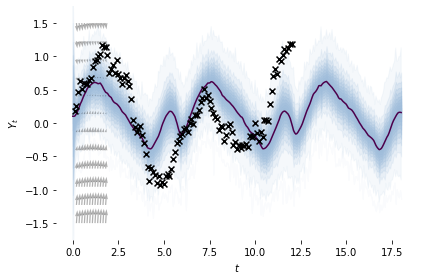

 40%|████      | 200/500 [01:18<03:19,  1.51it/s]

tensor(979.5933, grad_fn=<MeanBackward0>)


 40%|████      | 201/500 [01:18<02:53,  1.73it/s]

tensor(994.5953, grad_fn=<MeanBackward0>)


 40%|████      | 202/500 [01:18<02:33,  1.94it/s]

tensor(979.8998, grad_fn=<MeanBackward0>)


 41%|████      | 203/500 [01:19<02:20,  2.12it/s]

tensor(990.7281, grad_fn=<MeanBackward0>)


 41%|████      | 204/500 [01:19<02:11,  2.25it/s]

tensor(988.3394, grad_fn=<MeanBackward0>)


 41%|████      | 205/500 [01:20<02:05,  2.36it/s]

tensor(987.8782, grad_fn=<MeanBackward0>)


 41%|████      | 206/500 [01:20<02:01,  2.42it/s]

tensor(989.2397, grad_fn=<MeanBackward0>)


 41%|████▏     | 207/500 [01:20<01:58,  2.48it/s]

tensor(984.1150, grad_fn=<MeanBackward0>)


 42%|████▏     | 208/500 [01:21<01:58,  2.46it/s]

tensor(983.5571, grad_fn=<MeanBackward0>)


 42%|████▏     | 209/500 [01:21<01:56,  2.51it/s]

tensor(988.8419, grad_fn=<MeanBackward0>)


 42%|████▏     | 210/500 [01:21<01:52,  2.58it/s]

tensor(987.5223, grad_fn=<MeanBackward0>)


 42%|████▏     | 211/500 [01:22<01:51,  2.59it/s]

tensor(987.3190, grad_fn=<MeanBackward0>)


 42%|████▏     | 212/500 [01:22<01:50,  2.60it/s]

tensor(985.2823, grad_fn=<MeanBackward0>)


 43%|████▎     | 213/500 [01:23<01:48,  2.64it/s]

tensor(984.8952, grad_fn=<MeanBackward0>)


 43%|████▎     | 214/500 [01:23<01:46,  2.67it/s]

tensor(987.1624, grad_fn=<MeanBackward0>)


 43%|████▎     | 215/500 [01:23<01:45,  2.70it/s]

tensor(985.4886, grad_fn=<MeanBackward0>)


 43%|████▎     | 216/500 [01:24<01:44,  2.71it/s]

tensor(984.9827, grad_fn=<MeanBackward0>)


 43%|████▎     | 217/500 [01:24<01:44,  2.72it/s]

tensor(979.7997, grad_fn=<MeanBackward0>)


 44%|████▎     | 218/500 [01:24<01:43,  2.73it/s]

tensor(990.9462, grad_fn=<MeanBackward0>)


 44%|████▍     | 219/500 [01:25<01:42,  2.74it/s]

tensor(984.0473, grad_fn=<MeanBackward0>)


 44%|████▍     | 220/500 [01:25<01:41,  2.75it/s]

tensor(979.9502, grad_fn=<MeanBackward0>)


 44%|████▍     | 221/500 [01:25<01:41,  2.76it/s]

tensor(989.5709, grad_fn=<MeanBackward0>)


 44%|████▍     | 222/500 [01:26<01:40,  2.76it/s]

tensor(986.7462, grad_fn=<MeanBackward0>)


 45%|████▍     | 223/500 [01:26<01:40,  2.75it/s]

tensor(986.0547, grad_fn=<MeanBackward0>)


 45%|████▍     | 224/500 [01:27<01:40,  2.76it/s]

tensor(987.0689, grad_fn=<MeanBackward0>)


 45%|████▌     | 225/500 [01:27<01:39,  2.76it/s]

tensor(981.6402, grad_fn=<MeanBackward0>)


 45%|████▌     | 226/500 [01:27<01:39,  2.76it/s]

tensor(985.9360, grad_fn=<MeanBackward0>)


 45%|████▌     | 227/500 [01:28<01:38,  2.76it/s]

tensor(982.3827, grad_fn=<MeanBackward0>)


 46%|████▌     | 228/500 [01:28<01:38,  2.77it/s]

tensor(985.4395, grad_fn=<MeanBackward0>)


 46%|████▌     | 229/500 [01:28<01:38,  2.76it/s]

tensor(984.4617, grad_fn=<MeanBackward0>)


 46%|████▌     | 230/500 [01:29<01:37,  2.76it/s]

tensor(992.6718, grad_fn=<MeanBackward0>)


 46%|████▌     | 231/500 [01:29<01:37,  2.75it/s]

tensor(991.0750, grad_fn=<MeanBackward0>)


 46%|████▋     | 232/500 [01:29<01:37,  2.76it/s]

tensor(979.7928, grad_fn=<MeanBackward0>)


 47%|████▋     | 233/500 [01:30<01:36,  2.76it/s]

tensor(987.1324, grad_fn=<MeanBackward0>)


 47%|████▋     | 234/500 [01:30<01:36,  2.75it/s]

tensor(988.5472, grad_fn=<MeanBackward0>)


 47%|████▋     | 235/500 [01:31<01:36,  2.75it/s]

tensor(985.1864, grad_fn=<MeanBackward0>)


 47%|████▋     | 236/500 [01:31<01:37,  2.71it/s]

tensor(992.6460, grad_fn=<MeanBackward0>)


 47%|████▋     | 237/500 [01:31<01:36,  2.71it/s]

tensor(981.2945, grad_fn=<MeanBackward0>)


 48%|████▊     | 238/500 [01:32<01:36,  2.73it/s]

tensor(988.3361, grad_fn=<MeanBackward0>)


 48%|████▊     | 239/500 [01:32<01:35,  2.73it/s]

tensor(992.8910, grad_fn=<MeanBackward0>)


 48%|████▊     | 240/500 [01:32<01:34,  2.74it/s]

tensor(978.2386, grad_fn=<MeanBackward0>)


 48%|████▊     | 241/500 [01:33<01:34,  2.75it/s]

tensor(985.6867, grad_fn=<MeanBackward0>)


 48%|████▊     | 242/500 [01:33<01:33,  2.75it/s]

tensor(993.9444, grad_fn=<MeanBackward0>)


 49%|████▊     | 243/500 [01:34<01:36,  2.66it/s]

tensor(982.8895, grad_fn=<MeanBackward0>)


 49%|████▉     | 244/500 [01:34<01:37,  2.61it/s]

tensor(982.8524, grad_fn=<MeanBackward0>)


 49%|████▉     | 245/500 [01:34<01:36,  2.63it/s]

tensor(990.4031, grad_fn=<MeanBackward0>)
tensor(982.6454, grad_fn=<MeanBackward0>)


 49%|████▉     | 247/500 [01:35<01:48,  2.32it/s]

tensor(987.8741, grad_fn=<MeanBackward0>)


 50%|████▉     | 248/500 [01:36<01:44,  2.40it/s]

tensor(989.1969, grad_fn=<MeanBackward0>)


 50%|████▉     | 249/500 [01:36<01:41,  2.48it/s]

tensor(982.6580, grad_fn=<MeanBackward0>)


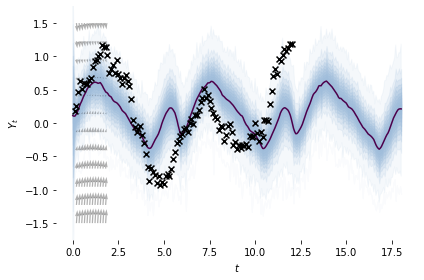

 50%|█████     | 250/500 [01:38<03:00,  1.38it/s]

tensor(986.2580, grad_fn=<MeanBackward0>)


 50%|█████     | 251/500 [01:38<02:34,  1.61it/s]

tensor(990.1674, grad_fn=<MeanBackward0>)


 50%|█████     | 252/500 [01:38<02:16,  1.82it/s]

tensor(973.1060, grad_fn=<MeanBackward0>)


 51%|█████     | 253/500 [01:39<02:03,  2.00it/s]

tensor(986.8666, grad_fn=<MeanBackward0>)


 51%|█████     | 254/500 [01:39<01:54,  2.15it/s]

tensor(982.7734, grad_fn=<MeanBackward0>)


 51%|█████     | 255/500 [01:39<01:47,  2.28it/s]

tensor(988.2280, grad_fn=<MeanBackward0>)


 51%|█████     | 256/500 [01:40<01:42,  2.39it/s]

tensor(987.0482, grad_fn=<MeanBackward0>)


 51%|█████▏    | 257/500 [01:40<01:38,  2.46it/s]

tensor(988.0087, grad_fn=<MeanBackward0>)


 52%|█████▏    | 258/500 [01:41<01:36,  2.51it/s]

tensor(986.0891, grad_fn=<MeanBackward0>)


 52%|█████▏    | 259/500 [01:41<01:36,  2.51it/s]

tensor(990.6847, grad_fn=<MeanBackward0>)


 52%|█████▏    | 260/500 [01:41<01:33,  2.56it/s]

tensor(980.5696, grad_fn=<MeanBackward0>)


 52%|█████▏    | 261/500 [01:42<01:31,  2.61it/s]

tensor(982.7822, grad_fn=<MeanBackward0>)


 52%|█████▏    | 262/500 [01:42<01:30,  2.62it/s]

tensor(991.9252, grad_fn=<MeanBackward0>)


 53%|█████▎    | 263/500 [01:42<01:29,  2.64it/s]

tensor(980.5090, grad_fn=<MeanBackward0>)


 53%|█████▎    | 264/500 [01:43<01:28,  2.67it/s]

tensor(983.4003, grad_fn=<MeanBackward0>)


 53%|█████▎    | 265/500 [01:43<01:26,  2.70it/s]

tensor(979.9486, grad_fn=<MeanBackward0>)


 53%|█████▎    | 266/500 [01:44<01:26,  2.72it/s]

tensor(980.8653, grad_fn=<MeanBackward0>)


 53%|█████▎    | 267/500 [01:44<01:25,  2.73it/s]

tensor(988.8265, grad_fn=<MeanBackward0>)


 54%|█████▎    | 268/500 [01:44<01:24,  2.74it/s]

tensor(982.9026, grad_fn=<MeanBackward0>)


 54%|█████▍    | 269/500 [01:45<01:23,  2.75it/s]

tensor(987.2568, grad_fn=<MeanBackward0>)


 54%|█████▍    | 270/500 [01:45<01:23,  2.76it/s]

tensor(988.6107, grad_fn=<MeanBackward0>)


 54%|█████▍    | 271/500 [01:45<01:22,  2.76it/s]

tensor(979.3591, grad_fn=<MeanBackward0>)


 54%|█████▍    | 272/500 [01:46<01:22,  2.77it/s]

tensor(989.8578, grad_fn=<MeanBackward0>)


 55%|█████▍    | 273/500 [01:46<01:22,  2.77it/s]

tensor(985.3878, grad_fn=<MeanBackward0>)


 55%|█████▍    | 274/500 [01:46<01:21,  2.77it/s]

tensor(980.0399, grad_fn=<MeanBackward0>)


 55%|█████▌    | 275/500 [01:47<01:21,  2.77it/s]

tensor(991.0381, grad_fn=<MeanBackward0>)


 55%|█████▌    | 276/500 [01:47<01:20,  2.77it/s]

tensor(987.7151, grad_fn=<MeanBackward0>)


 55%|█████▌    | 277/500 [01:48<01:20,  2.77it/s]

tensor(983.9290, grad_fn=<MeanBackward0>)


 56%|█████▌    | 278/500 [01:48<01:20,  2.77it/s]

tensor(983.6700, grad_fn=<MeanBackward0>)


 56%|█████▌    | 279/500 [01:48<01:19,  2.77it/s]

tensor(988.9597, grad_fn=<MeanBackward0>)


 56%|█████▌    | 280/500 [01:49<01:19,  2.77it/s]

tensor(983.4006, grad_fn=<MeanBackward0>)


 56%|█████▌    | 281/500 [01:49<01:19,  2.77it/s]

tensor(987.9270, grad_fn=<MeanBackward0>)


 56%|█████▋    | 282/500 [01:49<01:18,  2.77it/s]

tensor(981.6876, grad_fn=<MeanBackward0>)


 57%|█████▋    | 283/500 [01:50<01:18,  2.77it/s]

tensor(981.5763, grad_fn=<MeanBackward0>)


 57%|█████▋    | 284/500 [01:50<01:17,  2.77it/s]

tensor(980.2579, grad_fn=<MeanBackward0>)


 57%|█████▋    | 285/500 [01:50<01:17,  2.76it/s]

tensor(985.4946, grad_fn=<MeanBackward0>)


 57%|█████▋    | 286/500 [01:51<01:17,  2.77it/s]

tensor(987.8220, grad_fn=<MeanBackward0>)


 57%|█████▋    | 287/500 [01:51<01:18,  2.72it/s]

tensor(990.1884, grad_fn=<MeanBackward0>)


 58%|█████▊    | 288/500 [01:51<01:17,  2.73it/s]

tensor(989.6141, grad_fn=<MeanBackward0>)


 58%|█████▊    | 289/500 [01:52<01:17,  2.71it/s]

tensor(984.2565, grad_fn=<MeanBackward0>)


 58%|█████▊    | 290/500 [01:52<01:16,  2.73it/s]

tensor(988.6782, grad_fn=<MeanBackward0>)


 58%|█████▊    | 291/500 [01:53<01:16,  2.73it/s]

tensor(979.6964, grad_fn=<MeanBackward0>)


 58%|█████▊    | 292/500 [01:53<01:15,  2.74it/s]

tensor(983.0058, grad_fn=<MeanBackward0>)


 59%|█████▊    | 293/500 [01:53<01:15,  2.75it/s]

tensor(986.4393, grad_fn=<MeanBackward0>)


 59%|█████▉    | 294/500 [01:54<01:14,  2.76it/s]

tensor(983.8163, grad_fn=<MeanBackward0>)


 59%|█████▉    | 295/500 [01:54<01:14,  2.74it/s]

tensor(986.2545, grad_fn=<MeanBackward0>)


 59%|█████▉    | 296/500 [01:54<01:15,  2.71it/s]

tensor(983.2100, grad_fn=<MeanBackward0>)


 59%|█████▉    | 297/500 [01:55<01:15,  2.69it/s]

tensor(985.0564, grad_fn=<MeanBackward0>)


 60%|█████▉    | 298/500 [01:55<01:14,  2.70it/s]

tensor(979.1033, grad_fn=<MeanBackward0>)


 60%|█████▉    | 299/500 [01:56<01:14,  2.71it/s]

tensor(984.3813, grad_fn=<MeanBackward0>)


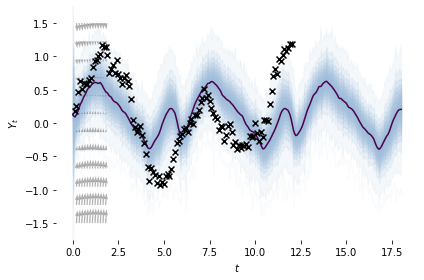

 60%|██████    | 300/500 [01:57<02:15,  1.47it/s]

tensor(986.6452, grad_fn=<MeanBackward0>)


 60%|██████    | 301/500 [01:57<01:58,  1.68it/s]

tensor(990.8207, grad_fn=<MeanBackward0>)


 60%|██████    | 302/500 [01:58<01:45,  1.88it/s]

tensor(982.6006, grad_fn=<MeanBackward0>)
tensor(982.6996, grad_fn=<MeanBackward0>)


 61%|██████    | 304/500 [01:59<01:35,  2.06it/s]

tensor(984.7672, grad_fn=<MeanBackward0>)


 61%|██████    | 305/500 [01:59<01:29,  2.18it/s]

tensor(994.6674, grad_fn=<MeanBackward0>)
tensor(985.6642, grad_fn=<MeanBackward0>)


 61%|██████▏   | 307/500 [02:00<01:25,  2.27it/s]

tensor(986.6336, grad_fn=<MeanBackward0>)


 62%|██████▏   | 308/500 [02:00<01:20,  2.37it/s]

tensor(985.4300, grad_fn=<MeanBackward0>)


 62%|██████▏   | 309/500 [02:01<01:17,  2.45it/s]

tensor(983.8305, grad_fn=<MeanBackward0>)


 62%|██████▏   | 310/500 [02:01<01:17,  2.45it/s]

tensor(983.8680, grad_fn=<MeanBackward0>)


 62%|██████▏   | 311/500 [02:01<01:16,  2.48it/s]

tensor(985.5773, grad_fn=<MeanBackward0>)
tensor(983.0377, grad_fn=<MeanBackward0>)


 63%|██████▎   | 313/500 [02:02<01:15,  2.49it/s]

tensor(983.1971, grad_fn=<MeanBackward0>)


 63%|██████▎   | 314/500 [02:03<01:12,  2.56it/s]

tensor(988.2008, grad_fn=<MeanBackward0>)


 63%|██████▎   | 315/500 [02:03<01:10,  2.62it/s]

tensor(988.5704, grad_fn=<MeanBackward0>)


 63%|██████▎   | 316/500 [02:03<01:09,  2.63it/s]

tensor(979.0093, grad_fn=<MeanBackward0>)


 63%|██████▎   | 317/500 [02:04<01:08,  2.66it/s]

tensor(988.0624, grad_fn=<MeanBackward0>)


 64%|██████▎   | 318/500 [02:04<01:09,  2.63it/s]

tensor(985.6844, grad_fn=<MeanBackward0>)


 64%|██████▍   | 319/500 [02:04<01:08,  2.63it/s]

tensor(986.3356, grad_fn=<MeanBackward0>)


 64%|██████▍   | 320/500 [02:05<01:08,  2.63it/s]

tensor(985.9457, grad_fn=<MeanBackward0>)


 64%|██████▍   | 321/500 [02:05<01:07,  2.64it/s]

tensor(983.2750, grad_fn=<MeanBackward0>)


 64%|██████▍   | 322/500 [02:06<01:07,  2.65it/s]

tensor(981.1031, grad_fn=<MeanBackward0>)


 65%|██████▍   | 323/500 [02:06<01:06,  2.65it/s]

tensor(981.7089, grad_fn=<MeanBackward0>)


 65%|██████▍   | 324/500 [02:06<01:06,  2.65it/s]

tensor(985.5281, grad_fn=<MeanBackward0>)


 65%|██████▌   | 325/500 [02:07<01:06,  2.65it/s]

tensor(987.3322, grad_fn=<MeanBackward0>)


 65%|██████▌   | 326/500 [02:07<01:05,  2.65it/s]

tensor(982.7542, grad_fn=<MeanBackward0>)


 65%|██████▌   | 327/500 [02:08<01:05,  2.65it/s]

tensor(982.1010, grad_fn=<MeanBackward0>)


 66%|██████▌   | 328/500 [02:08<01:05,  2.65it/s]

tensor(981.2767, grad_fn=<MeanBackward0>)


 66%|██████▌   | 329/500 [02:08<01:04,  2.64it/s]

tensor(983.6996, grad_fn=<MeanBackward0>)


 66%|██████▌   | 330/500 [02:09<01:04,  2.64it/s]

tensor(983.4396, grad_fn=<MeanBackward0>)


 66%|██████▌   | 331/500 [02:09<01:03,  2.65it/s]

tensor(979.4104, grad_fn=<MeanBackward0>)


 66%|██████▋   | 332/500 [02:09<01:03,  2.64it/s]

tensor(991.6665, grad_fn=<MeanBackward0>)


 67%|██████▋   | 333/500 [02:10<01:03,  2.63it/s]

tensor(982.2156, grad_fn=<MeanBackward0>)


 67%|██████▋   | 334/500 [02:10<01:03,  2.62it/s]

tensor(986.4229, grad_fn=<MeanBackward0>)


 67%|██████▋   | 335/500 [02:11<01:03,  2.61it/s]

tensor(985.8343, grad_fn=<MeanBackward0>)


 67%|██████▋   | 336/500 [02:11<01:02,  2.60it/s]

tensor(978.7463, grad_fn=<MeanBackward0>)


 67%|██████▋   | 337/500 [02:11<01:02,  2.60it/s]

tensor(986.2518, grad_fn=<MeanBackward0>)


 68%|██████▊   | 338/500 [02:12<01:02,  2.61it/s]

tensor(990.6714, grad_fn=<MeanBackward0>)


 68%|██████▊   | 339/500 [02:12<01:01,  2.61it/s]

tensor(983.0375, grad_fn=<MeanBackward0>)


 68%|██████▊   | 340/500 [02:12<01:01,  2.61it/s]

tensor(986.3809, grad_fn=<MeanBackward0>)


 68%|██████▊   | 341/500 [02:13<01:01,  2.60it/s]

tensor(983.6498, grad_fn=<MeanBackward0>)


 68%|██████▊   | 342/500 [02:13<01:01,  2.59it/s]

tensor(988.1896, grad_fn=<MeanBackward0>)


 69%|██████▊   | 343/500 [02:14<01:00,  2.61it/s]

tensor(984.0388, grad_fn=<MeanBackward0>)


 69%|██████▉   | 344/500 [02:14<00:59,  2.62it/s]

tensor(985.3517, grad_fn=<MeanBackward0>)


 69%|██████▉   | 345/500 [02:14<00:59,  2.62it/s]

tensor(983.0309, grad_fn=<MeanBackward0>)


 69%|██████▉   | 346/500 [02:15<00:58,  2.62it/s]

tensor(983.2320, grad_fn=<MeanBackward0>)


 69%|██████▉   | 347/500 [02:15<00:57,  2.64it/s]

tensor(986.3070, grad_fn=<MeanBackward0>)


 70%|██████▉   | 348/500 [02:16<00:57,  2.66it/s]

tensor(985.4275, grad_fn=<MeanBackward0>)


 70%|██████▉   | 349/500 [02:16<00:56,  2.67it/s]

tensor(982.3049, grad_fn=<MeanBackward0>)


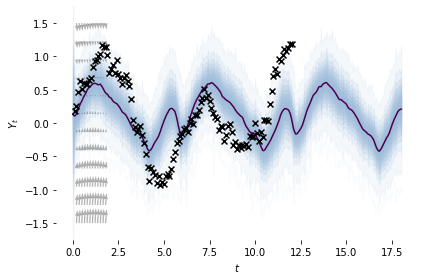

 70%|███████   | 350/500 [02:17<01:42,  1.46it/s]

tensor(990.1688, grad_fn=<MeanBackward0>)


 70%|███████   | 351/500 [02:18<01:29,  1.67it/s]

tensor(975.8939, grad_fn=<MeanBackward0>)


 70%|███████   | 352/500 [02:18<01:18,  1.88it/s]

tensor(985.1674, grad_fn=<MeanBackward0>)


 71%|███████   | 353/500 [02:18<01:11,  2.05it/s]

tensor(985.7233, grad_fn=<MeanBackward0>)


 71%|███████   | 354/500 [02:19<01:06,  2.18it/s]

tensor(989.1652, grad_fn=<MeanBackward0>)


 71%|███████   | 355/500 [02:19<01:04,  2.26it/s]

tensor(984.1342, grad_fn=<MeanBackward0>)


 71%|███████   | 356/500 [02:20<01:01,  2.33it/s]

tensor(984.3237, grad_fn=<MeanBackward0>)
tensor(988.6439, grad_fn=<MeanBackward0>)


 71%|███████▏  | 357/500 [02:20<01:00,  2.38it/s]

tensor(979.2014, grad_fn=<MeanBackward0>)


 72%|███████▏  | 359/500 [02:21<00:58,  2.43it/s]

tensor(977.3537, grad_fn=<MeanBackward0>)


 72%|███████▏  | 360/500 [02:21<00:56,  2.48it/s]

tensor(986.8130, grad_fn=<MeanBackward0>)


 72%|███████▏  | 361/500 [02:22<00:55,  2.51it/s]

tensor(987.4207, grad_fn=<MeanBackward0>)


 72%|███████▏  | 362/500 [02:22<00:54,  2.53it/s]

tensor(981.0782, grad_fn=<MeanBackward0>)


 73%|███████▎  | 363/500 [02:22<00:53,  2.57it/s]

tensor(989.2715, grad_fn=<MeanBackward0>)


 73%|███████▎  | 364/500 [02:23<00:52,  2.60it/s]

tensor(989.6232, grad_fn=<MeanBackward0>)


 73%|███████▎  | 365/500 [02:23<00:51,  2.64it/s]

tensor(979.6972, grad_fn=<MeanBackward0>)


 73%|███████▎  | 366/500 [02:24<00:50,  2.64it/s]

tensor(977.0208, grad_fn=<MeanBackward0>)


 73%|███████▎  | 367/500 [02:24<00:50,  2.65it/s]

tensor(981.4962, grad_fn=<MeanBackward0>)


 74%|███████▎  | 368/500 [02:24<00:49,  2.67it/s]

tensor(982.5869, grad_fn=<MeanBackward0>)


 74%|███████▍  | 369/500 [02:25<00:48,  2.68it/s]

tensor(986.1319, grad_fn=<MeanBackward0>)


 74%|███████▍  | 370/500 [02:25<00:48,  2.69it/s]

tensor(987.6575, grad_fn=<MeanBackward0>)


 74%|███████▍  | 371/500 [02:25<00:47,  2.70it/s]

tensor(984.3848, grad_fn=<MeanBackward0>)


 74%|███████▍  | 372/500 [02:26<00:47,  2.72it/s]

tensor(981.5213, grad_fn=<MeanBackward0>)


 75%|███████▍  | 373/500 [02:26<00:46,  2.72it/s]

tensor(981.7499, grad_fn=<MeanBackward0>)


 75%|███████▍  | 374/500 [02:27<00:48,  2.59it/s]

tensor(986.5658, grad_fn=<MeanBackward0>)


 75%|███████▌  | 375/500 [02:27<00:47,  2.62it/s]

tensor(982.5980, grad_fn=<MeanBackward0>)


 75%|███████▌  | 376/500 [02:27<00:46,  2.64it/s]

tensor(984.4131, grad_fn=<MeanBackward0>)


 75%|███████▌  | 377/500 [02:28<00:46,  2.67it/s]

tensor(980.9276, grad_fn=<MeanBackward0>)


 76%|███████▌  | 378/500 [02:28<00:45,  2.67it/s]

tensor(985.7771, grad_fn=<MeanBackward0>)


 76%|███████▌  | 379/500 [02:28<00:45,  2.68it/s]

tensor(977.8931, grad_fn=<MeanBackward0>)


 76%|███████▌  | 380/500 [02:29<00:44,  2.69it/s]

tensor(986.9214, grad_fn=<MeanBackward0>)


 76%|███████▌  | 381/500 [02:29<00:44,  2.67it/s]

tensor(986.5289, grad_fn=<MeanBackward0>)


 76%|███████▋  | 382/500 [02:30<00:44,  2.63it/s]

tensor(986.9090, grad_fn=<MeanBackward0>)


 77%|███████▋  | 383/500 [02:30<00:45,  2.59it/s]

tensor(988.5176, grad_fn=<MeanBackward0>)


 77%|███████▋  | 384/500 [02:30<00:44,  2.60it/s]

tensor(979.8444, grad_fn=<MeanBackward0>)


 77%|███████▋  | 385/500 [02:31<00:44,  2.59it/s]

tensor(987.5284, grad_fn=<MeanBackward0>)


 77%|███████▋  | 386/500 [02:31<00:44,  2.56it/s]

tensor(980.7454, grad_fn=<MeanBackward0>)


 77%|███████▋  | 387/500 [02:31<00:43,  2.57it/s]

tensor(987.8163, grad_fn=<MeanBackward0>)


 78%|███████▊  | 388/500 [02:32<00:43,  2.60it/s]

tensor(985.6790, grad_fn=<MeanBackward0>)


 78%|███████▊  | 389/500 [02:32<00:42,  2.60it/s]

tensor(985.7427, grad_fn=<MeanBackward0>)


 78%|███████▊  | 390/500 [02:33<00:42,  2.61it/s]

tensor(987.1107, grad_fn=<MeanBackward0>)


 78%|███████▊  | 391/500 [02:33<00:41,  2.61it/s]

tensor(981.3311, grad_fn=<MeanBackward0>)


 78%|███████▊  | 392/500 [02:33<00:41,  2.61it/s]

tensor(982.5185, grad_fn=<MeanBackward0>)


 79%|███████▊  | 393/500 [02:34<00:43,  2.45it/s]

tensor(981.3755, grad_fn=<MeanBackward0>)


 79%|███████▉  | 394/500 [02:34<00:42,  2.49it/s]

tensor(988.3746, grad_fn=<MeanBackward0>)


 79%|███████▉  | 395/500 [02:35<00:41,  2.52it/s]

tensor(986.3074, grad_fn=<MeanBackward0>)


 79%|███████▉  | 396/500 [02:35<00:41,  2.52it/s]

tensor(981.9651, grad_fn=<MeanBackward0>)


 79%|███████▉  | 397/500 [02:35<00:40,  2.54it/s]

tensor(986.2158, grad_fn=<MeanBackward0>)
tensor(987.8837, grad_fn=<MeanBackward0>)


 80%|███████▉  | 399/500 [02:36<00:40,  2.49it/s]

tensor(982.4162, grad_fn=<MeanBackward0>)


 80%|████████  | 400/500 [02:38<01:13,  1.37it/s]

tensor(980.0945, grad_fn=<MeanBackward0>)


 80%|████████  | 401/500 [02:38<01:02,  1.57it/s]

tensor(987.9223, grad_fn=<MeanBackward0>)


 80%|████████  | 402/500 [02:39<00:55,  1.76it/s]

tensor(975.7961, grad_fn=<MeanBackward0>)
tensor(978.9595, grad_fn=<MeanBackward0>)


 81%|████████  | 404/500 [02:39<00:47,  2.01it/s]

tensor(984.2921, grad_fn=<MeanBackward0>)
tensor(985.5865, grad_fn=<MeanBackward0>)


 81%|████████  | 405/500 [02:40<00:45,  2.08it/s]

tensor(981.5946, grad_fn=<MeanBackward0>)


 81%|████████▏ | 407/500 [02:41<00:43,  2.15it/s]

tensor(981.8376, grad_fn=<MeanBackward0>)


 82%|████████▏ | 408/500 [02:41<00:41,  2.23it/s]

tensor(986.0492, grad_fn=<MeanBackward0>)


 82%|████████▏ | 409/500 [02:42<00:38,  2.34it/s]

tensor(988.1202, grad_fn=<MeanBackward0>)


 82%|████████▏ | 410/500 [02:42<00:37,  2.43it/s]

tensor(989.8838, grad_fn=<MeanBackward0>)


 82%|████████▏ | 411/500 [02:42<00:36,  2.46it/s]

tensor(977.9321, grad_fn=<MeanBackward0>)


 82%|████████▏ | 412/500 [02:43<00:35,  2.46it/s]

tensor(982.2753, grad_fn=<MeanBackward0>)


 83%|████████▎ | 413/500 [02:43<00:35,  2.48it/s]

tensor(986.4651, grad_fn=<MeanBackward0>)


 83%|████████▎ | 414/500 [02:43<00:34,  2.50it/s]

tensor(982.7889, grad_fn=<MeanBackward0>)


 83%|████████▎ | 415/500 [02:44<00:34,  2.50it/s]

tensor(984.0259, grad_fn=<MeanBackward0>)


 83%|████████▎ | 416/500 [02:44<00:34,  2.46it/s]

tensor(984.1206, grad_fn=<MeanBackward0>)


 83%|████████▎ | 417/500 [02:45<00:34,  2.44it/s]

tensor(982.1426, grad_fn=<MeanBackward0>)


 84%|████████▎ | 418/500 [02:45<00:32,  2.49it/s]

tensor(985.2696, grad_fn=<MeanBackward0>)


 84%|████████▍ | 419/500 [02:46<00:32,  2.52it/s]

tensor(979.3065, grad_fn=<MeanBackward0>)


 84%|████████▍ | 420/500 [02:46<00:31,  2.53it/s]

tensor(978.1543, grad_fn=<MeanBackward0>)


 84%|████████▍ | 421/500 [02:46<00:30,  2.57it/s]

tensor(978.7693, grad_fn=<MeanBackward0>)


 84%|████████▍ | 422/500 [02:47<00:30,  2.58it/s]

tensor(982.1265, grad_fn=<MeanBackward0>)


 85%|████████▍ | 423/500 [02:47<00:29,  2.59it/s]

tensor(986.5488, grad_fn=<MeanBackward0>)


 85%|████████▍ | 424/500 [02:47<00:29,  2.61it/s]

tensor(986.5428, grad_fn=<MeanBackward0>)


 85%|████████▌ | 425/500 [02:48<00:28,  2.62it/s]

tensor(987.0306, grad_fn=<MeanBackward0>)


 85%|████████▌ | 426/500 [02:48<00:28,  2.64it/s]

tensor(976.3179, grad_fn=<MeanBackward0>)


 85%|████████▌ | 427/500 [02:49<00:27,  2.65it/s]

tensor(976.1632, grad_fn=<MeanBackward0>)


 86%|████████▌ | 428/500 [02:49<00:27,  2.62it/s]

tensor(984.8153, grad_fn=<MeanBackward0>)


 86%|████████▌ | 429/500 [02:49<00:27,  2.58it/s]

tensor(987.5004, grad_fn=<MeanBackward0>)


 86%|████████▌ | 430/500 [02:50<00:27,  2.55it/s]

tensor(978.8814, grad_fn=<MeanBackward0>)


 86%|████████▌ | 431/500 [02:50<00:27,  2.47it/s]

tensor(990.4138, grad_fn=<MeanBackward0>)


 86%|████████▋ | 432/500 [02:51<00:26,  2.54it/s]

tensor(986.9442, grad_fn=<MeanBackward0>)


 87%|████████▋ | 433/500 [02:51<00:26,  2.57it/s]

tensor(979.9238, grad_fn=<MeanBackward0>)


 87%|████████▋ | 434/500 [02:51<00:25,  2.60it/s]

tensor(984.4242, grad_fn=<MeanBackward0>)


 87%|████████▋ | 435/500 [02:52<00:24,  2.61it/s]

tensor(979.7325, grad_fn=<MeanBackward0>)


 87%|████████▋ | 436/500 [02:52<00:24,  2.63it/s]

tensor(981.6856, grad_fn=<MeanBackward0>)


 87%|████████▋ | 437/500 [02:52<00:23,  2.67it/s]

tensor(989.6053, grad_fn=<MeanBackward0>)


 88%|████████▊ | 438/500 [02:53<00:23,  2.66it/s]

tensor(984.9647, grad_fn=<MeanBackward0>)


 88%|████████▊ | 439/500 [02:53<00:22,  2.69it/s]

tensor(978.4927, grad_fn=<MeanBackward0>)


 88%|████████▊ | 440/500 [02:54<00:22,  2.68it/s]

tensor(984.5643, grad_fn=<MeanBackward0>)


 88%|████████▊ | 441/500 [02:54<00:21,  2.69it/s]

tensor(985.2452, grad_fn=<MeanBackward0>)


 88%|████████▊ | 442/500 [02:54<00:21,  2.70it/s]

tensor(984.2253, grad_fn=<MeanBackward0>)


 89%|████████▊ | 443/500 [02:55<00:21,  2.68it/s]

tensor(982.7427, grad_fn=<MeanBackward0>)


 89%|████████▉ | 444/500 [02:55<00:20,  2.70it/s]

tensor(981.0369, grad_fn=<MeanBackward0>)


 89%|████████▉ | 445/500 [02:55<00:20,  2.71it/s]

tensor(985.7149, grad_fn=<MeanBackward0>)


 89%|████████▉ | 446/500 [02:56<00:20,  2.68it/s]

tensor(980.4527, grad_fn=<MeanBackward0>)


 89%|████████▉ | 447/500 [02:56<00:19,  2.69it/s]

tensor(978.4548, grad_fn=<MeanBackward0>)


 90%|████████▉ | 448/500 [02:56<00:19,  2.70it/s]

tensor(989.4553, grad_fn=<MeanBackward0>)


 90%|████████▉ | 449/500 [02:57<00:18,  2.70it/s]

tensor(986.5759, grad_fn=<MeanBackward0>)


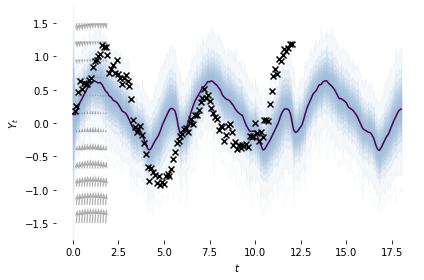

 90%|█████████ | 450/500 [02:58<00:34,  1.47it/s]

tensor(978.6575, grad_fn=<MeanBackward0>)


 90%|█████████ | 451/500 [02:59<00:28,  1.69it/s]

tensor(981.6328, grad_fn=<MeanBackward0>)


 90%|█████████ | 452/500 [02:59<00:25,  1.87it/s]

tensor(982.4586, grad_fn=<MeanBackward0>)


 91%|█████████ | 453/500 [02:59<00:23,  2.04it/s]

tensor(979.5760, grad_fn=<MeanBackward0>)


 91%|█████████ | 454/500 [03:00<00:21,  2.17it/s]

tensor(987.1329, grad_fn=<MeanBackward0>)
tensor(979.4577, grad_fn=<MeanBackward0>)


 91%|█████████ | 455/500 [03:00<00:20,  2.23it/s]

tensor(977.2461, grad_fn=<MeanBackward0>)


 91%|█████████▏| 457/500 [03:01<00:19,  2.19it/s]

tensor(979.8242, grad_fn=<MeanBackward0>)


 92%|█████████▏| 458/500 [03:02<00:18,  2.27it/s]

tensor(985.7696, grad_fn=<MeanBackward0>)


 92%|█████████▏| 459/500 [03:02<00:17,  2.37it/s]

tensor(983.2985, grad_fn=<MeanBackward0>)


 92%|█████████▏| 460/500 [03:02<00:16,  2.43it/s]

tensor(987.4902, grad_fn=<MeanBackward0>)


 92%|█████████▏| 461/500 [03:03<00:15,  2.48it/s]

tensor(981.7543, grad_fn=<MeanBackward0>)


 92%|█████████▏| 462/500 [03:03<00:14,  2.54it/s]

tensor(984.5624, grad_fn=<MeanBackward0>)


 93%|█████████▎| 463/500 [03:03<00:14,  2.59it/s]

tensor(984.2590, grad_fn=<MeanBackward0>)


 93%|█████████▎| 464/500 [03:04<00:13,  2.61it/s]

tensor(984.0656, grad_fn=<MeanBackward0>)


 93%|█████████▎| 465/500 [03:04<00:13,  2.65it/s]

tensor(977.8143, grad_fn=<MeanBackward0>)


 93%|█████████▎| 466/500 [03:05<00:12,  2.63it/s]

tensor(983.5762, grad_fn=<MeanBackward0>)


 93%|█████████▎| 467/500 [03:05<00:12,  2.60it/s]

tensor(983.2366, grad_fn=<MeanBackward0>)


 94%|█████████▎| 468/500 [03:05<00:12,  2.60it/s]

tensor(985.3352, grad_fn=<MeanBackward0>)


 94%|█████████▍| 469/500 [03:06<00:11,  2.60it/s]

tensor(982.3090, grad_fn=<MeanBackward0>)


 94%|█████████▍| 470/500 [03:06<00:11,  2.61it/s]

tensor(980.0538, grad_fn=<MeanBackward0>)


 94%|█████████▍| 471/500 [03:07<00:11,  2.61it/s]

tensor(981.9791, grad_fn=<MeanBackward0>)


 94%|█████████▍| 472/500 [03:07<00:10,  2.65it/s]

tensor(979.5562, grad_fn=<MeanBackward0>)


 95%|█████████▍| 473/500 [03:07<00:10,  2.68it/s]

tensor(979.6823, grad_fn=<MeanBackward0>)


 95%|█████████▍| 474/500 [03:08<00:09,  2.70it/s]

tensor(982.3871, grad_fn=<MeanBackward0>)


 95%|█████████▌| 475/500 [03:08<00:09,  2.71it/s]

tensor(979.6299, grad_fn=<MeanBackward0>)


 95%|█████████▌| 476/500 [03:08<00:08,  2.69it/s]

tensor(982.6462, grad_fn=<MeanBackward0>)


 95%|█████████▌| 477/500 [03:09<00:08,  2.71it/s]

tensor(977.0947, grad_fn=<MeanBackward0>)


 96%|█████████▌| 478/500 [03:09<00:08,  2.73it/s]

tensor(980.8764, grad_fn=<MeanBackward0>)


 96%|█████████▌| 479/500 [03:09<00:07,  2.74it/s]

tensor(979.0064, grad_fn=<MeanBackward0>)


 96%|█████████▌| 480/500 [03:10<00:07,  2.75it/s]

tensor(984.0382, grad_fn=<MeanBackward0>)


 96%|█████████▌| 481/500 [03:10<00:06,  2.75it/s]

tensor(980.6594, grad_fn=<MeanBackward0>)


 96%|█████████▋| 482/500 [03:11<00:06,  2.76it/s]

tensor(986.5528, grad_fn=<MeanBackward0>)


 97%|█████████▋| 483/500 [03:11<00:06,  2.76it/s]

tensor(981.8521, grad_fn=<MeanBackward0>)


 97%|█████████▋| 484/500 [03:11<00:05,  2.76it/s]

tensor(982.1893, grad_fn=<MeanBackward0>)
tensor(984.7014, grad_fn=<MeanBackward0>)


 97%|█████████▋| 486/500 [03:12<00:05,  2.65it/s]

tensor(984.7737, grad_fn=<MeanBackward0>)


 97%|█████████▋| 487/500 [03:12<00:04,  2.69it/s]

tensor(981.8238, grad_fn=<MeanBackward0>)


 98%|█████████▊| 488/500 [03:13<00:04,  2.71it/s]

tensor(985.8782, grad_fn=<MeanBackward0>)


 98%|█████████▊| 489/500 [03:13<00:04,  2.72it/s]

tensor(979.2119, grad_fn=<MeanBackward0>)


 98%|█████████▊| 490/500 [03:13<00:03,  2.74it/s]

tensor(986.1027, grad_fn=<MeanBackward0>)


 98%|█████████▊| 491/500 [03:14<00:03,  2.74it/s]

tensor(975.9146, grad_fn=<MeanBackward0>)


 98%|█████████▊| 492/500 [03:14<00:02,  2.75it/s]

tensor(982.9075, grad_fn=<MeanBackward0>)


 99%|█████████▊| 493/500 [03:15<00:02,  2.76it/s]

tensor(982.0063, grad_fn=<MeanBackward0>)


 99%|█████████▉| 494/500 [03:15<00:02,  2.76it/s]

tensor(978.1069, grad_fn=<MeanBackward0>)


 99%|█████████▉| 495/500 [03:15<00:01,  2.76it/s]

tensor(980.4445, grad_fn=<MeanBackward0>)


 99%|█████████▉| 496/500 [03:16<00:01,  2.76it/s]

tensor(980.1465, grad_fn=<MeanBackward0>)


 99%|█████████▉| 497/500 [03:16<00:01,  2.76it/s]

tensor(979.6240, grad_fn=<MeanBackward0>)


100%|█████████▉| 498/500 [03:16<00:00,  2.76it/s]

tensor(977.8982, grad_fn=<MeanBackward0>)


100%|█████████▉| 499/500 [03:17<00:00,  2.76it/s]

tensor(983.0708, grad_fn=<MeanBackward0>)


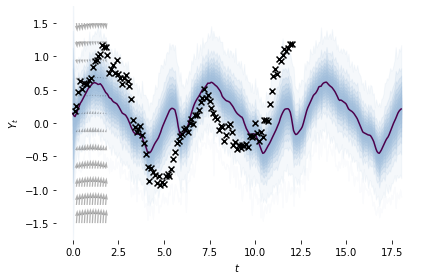

100%|██████████| 500/500 [03:18<00:00,  2.52it/s]

tensor(992.2605, grad_fn=<MeanBackward0>)


In [218]:
model_testing = LatentSDE_testing().to(device)
original_logpy = main_testing(model_testing)

# Now we add it to the loss function

In [219]:
def main_1(model):
    # Dataset.
    ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()
    llg = log_likelihood(1,ys)
    # Plotting parameters.
    vis_batch_size = 1024
    ylims = (-1.75, 1.75)
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = np.random.permutation(vis_batch_size)
    l2_logpy_list = []
    # From https://colorbrewer2.org/.
    if args.color == "blue":
        sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
        fill_color = '#9ebcda'
        mean_color = '#4d004b'
        num_samples = len(sample_colors)
    else:
        sample_colors = ('#fc4e2a', '#e31a1c', '#bd0026')
        fill_color = '#fd8d3c'
        mean_color = '#800026'
        num_samples = len(sample_colors)

    eps = torch.randn(vis_batch_size, 1).to(device)  # Fix seed for the random draws used in the plots.
    bm = torchsde.BrownianInterval(
        t0=ts_vis[0],
        t1=ts_vis[-1],
        size=(vis_batch_size, 1),
        device=device,
        levy_area_approximation='space-time'
    )  # We need space-time Levy area to use the SRK solver

    # Model.
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
    kl_scheduler = LinearScheduler(iters=args.kl_anneal_iters)
    criterion = nn.MSELoss()

    logpy_metric = EMAMetric()
    kl_metric = EMAMetric()
    loss_metric = EMAMetric()

    if args.show_prior:
        with torch.no_grad():
            zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
            ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
            zs_ = np.sort(zs_, axis=1)

            img_dir = os.path.join(args.train_dir, 'prior.png')
            plt.subplot(frameon=False)
            for alpha, percentile in zip(alphas, percentiles):
                idx = int((1 - percentile) / 2. * vis_batch_size)
                zs_bot_ = zs_[:, idx]
                zs_top_ = zs_[:, -idx]
                plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

            # `zorder` determines who's on top; the larger the more at the top.
            plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')
            plt.tight_layout()
            plt.savefig(img_dir, dpi=args.dpi)
            plt.show()
            plt.close()
            logging.info(f'Saved prior figure at: {img_dir}')

    for global_step in tqdm.tqdm(range(args.train_iters)):
        # Plot and save.
        if (global_step+1) % args.pause_iters == 0:
            img_path = os.path.join(args.train_dir, f'global_step_{global_step+1}.png')

            with torch.no_grad():
                zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
                samples = zs[:, vis_idx]
                ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
                zs_ = np.sort(zs_, axis=1)
                plt.subplot(frameon=False)

                if args.show_percentiles:
                    for alpha, percentile in zip(alphas, percentiles):
                        idx = int((1 - percentile) / 2. * vis_batch_size)
                        zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
                        plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

                if args.show_mean:
                    plt.plot(ts_vis_, zs_.mean(axis=1), color=mean_color)

                if args.show_samples:
                    for j in range(num_samples):
                        plt.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=1.0)

                if args.show_arrows:
                    num, dt = 12, 0.12
                    t, y = torch.meshgrid(
                        [torch.linspace(0.2, 1.8, num).to(device), torch.linspace(-1.5, 1.5, num).to(device)]
                    )
                    t, y = t.reshape(-1, 1), y.reshape(-1, 1)
                    fty = model.f(t=t, y=y).reshape(num, num)
                    dt = torch.zeros(num, num).fill_(dt).to(device)
                    dy = fty * dt
                    dt_, dy_, t_, y_ = dt.cpu().numpy(), dy.cpu().numpy(), t.cpu().numpy(), y.cpu().numpy()
                    plt.quiver(t_, y_, dt_, dy_, alpha=0.3, edgecolors='k', width=0.0035, scale=50)

                if args.hide_ticks:
                    plt.xticks([], [])
                    plt.yticks([], [])

                plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
                plt.ylim(ylims)
                plt.xlabel('$t$')
                plt.ylabel('$Y_t$')
                plt.tight_layout()
                plt.savefig(img_path, dpi=args.dpi)
                plt.show()
                plt.close()
                logging.info(f'Saved figure at: {img_path}')

                if args.save_ckpt:
                    torch.save(
                        {'model': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'kl_scheduler': kl_scheduler},
                        os.path.join(ckpt_dir, f'global_step_{global_step}.ckpt')
                    )

        # Train.
        optimizer.zero_grad()
        zs, kl = model(ts=ts_ext, batch_size=args.batch_size)
        zs = zs.squeeze()
        zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.

        likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
        likelihood = likelihood_constructor(loc=zs, scale=args.scale)
        logpy = likelihood.log_prob(ys).sum(dim=0).mean(dim=0)
        l2_logpy_list.append(logpy.item())
        #llg = log_likelihood(1,zs.permute([1,0]).squeeze(),120).mean()
        llg_loss = torch.sqrt((likelihood.log_prob(ys).sum(dim=0)-llg)**2).mean()
        print(llg_loss)
        #print(likelihood.log_prob(ys).mean(dim=1).shape)
        loss = -logpy + kl* kl_scheduler.val + llg_loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

        logpy_metric.step(logpy)
        kl_metric.step(kl)
        loss_metric.step(loss)

        logging.info(
            f'global_step: {global_step}, '
            f'logpy: {logpy_metric.val:.3f}, '
            f'kl: {kl_metric.val:.3f}, '
            f'llg_loss: {llg_loss:.3f}, '
            f'loss: {loss_metric.val:.3f}'
        )
    return l2_logpy_list

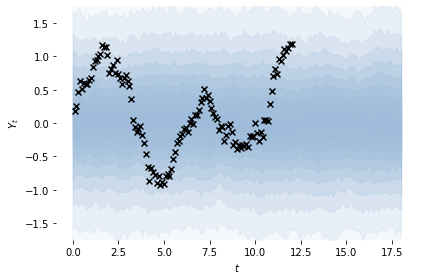

  0%|          | 0/500 [00:00<?, ?it/s]

tensor(4941.4585, grad_fn=<MeanBackward0>)


  0%|          | 1/500 [00:00<04:10,  1.99it/s]

tensor(3603.8838, grad_fn=<MeanBackward0>)


  0%|          | 2/500 [00:01<04:11,  1.98it/s]

tensor(1863.4270, grad_fn=<MeanBackward0>)


  1%|          | 4/500 [00:01<03:55,  2.11it/s]

tensor(1367.0483, grad_fn=<MeanBackward0>)
tensor(1155.5575, grad_fn=<MeanBackward0>)


  1%|          | 6/500 [00:02<03:45,  2.19it/s]

tensor(1078.5477, grad_fn=<MeanBackward0>)


  1%|▏         | 7/500 [00:03<03:44,  2.20it/s]

tensor(1034.3215, grad_fn=<MeanBackward0>)


  2%|▏         | 8/500 [00:03<03:38,  2.25it/s]

tensor(1007.0167, grad_fn=<MeanBackward0>)


  2%|▏         | 9/500 [00:04<03:30,  2.33it/s]

tensor(1010.5650, grad_fn=<MeanBackward0>)


  2%|▏         | 10/500 [00:04<03:22,  2.42it/s]

tensor(1029.2338, grad_fn=<MeanBackward0>)


  2%|▏         | 11/500 [00:04<03:18,  2.47it/s]

tensor(1063.0273, grad_fn=<MeanBackward0>)


  2%|▏         | 12/500 [00:05<03:16,  2.49it/s]

tensor(1103.8622, grad_fn=<MeanBackward0>)


  3%|▎         | 13/500 [00:05<03:16,  2.48it/s]

tensor(1134.8032, grad_fn=<MeanBackward0>)


  3%|▎         | 14/500 [00:06<03:13,  2.51it/s]

tensor(1126.3042, grad_fn=<MeanBackward0>)


  3%|▎         | 15/500 [00:06<03:11,  2.54it/s]

tensor(1104.9344, grad_fn=<MeanBackward0>)


  3%|▎         | 16/500 [00:06<03:10,  2.55it/s]

tensor(1073.4539, grad_fn=<MeanBackward0>)


  3%|▎         | 17/500 [00:07<03:11,  2.52it/s]

tensor(1046.3121, grad_fn=<MeanBackward0>)


  4%|▎         | 18/500 [00:07<03:11,  2.51it/s]

tensor(1033.1323, grad_fn=<MeanBackward0>)


  4%|▍         | 19/500 [00:07<03:13,  2.49it/s]

tensor(1018.0430, grad_fn=<MeanBackward0>)


  4%|▍         | 20/500 [00:08<03:08,  2.55it/s]

tensor(1000.7412, grad_fn=<MeanBackward0>)


  4%|▍         | 21/500 [00:08<03:05,  2.59it/s]

tensor(996.2414, grad_fn=<MeanBackward0>)


  4%|▍         | 22/500 [00:09<03:01,  2.63it/s]

tensor(992.6932, grad_fn=<MeanBackward0>)


  5%|▍         | 23/500 [00:09<02:59,  2.66it/s]

tensor(992.2617, grad_fn=<MeanBackward0>)


  5%|▍         | 24/500 [00:09<02:57,  2.68it/s]

tensor(995.1903, grad_fn=<MeanBackward0>)


  5%|▌         | 25/500 [00:10<02:58,  2.66it/s]

tensor(993.1193, grad_fn=<MeanBackward0>)


  5%|▌         | 26/500 [00:10<03:00,  2.62it/s]

tensor(995.7286, grad_fn=<MeanBackward0>)


  5%|▌         | 27/500 [00:10<02:58,  2.65it/s]

tensor(1002.7422, grad_fn=<MeanBackward0>)


  6%|▌         | 28/500 [00:11<02:56,  2.68it/s]

tensor(998.6134, grad_fn=<MeanBackward0>)


  6%|▌         | 29/500 [00:11<02:55,  2.69it/s]

tensor(997.8228, grad_fn=<MeanBackward0>)


  6%|▌         | 30/500 [00:12<02:54,  2.69it/s]

tensor(1010.4397, grad_fn=<MeanBackward0>)


  6%|▌         | 31/500 [00:12<02:53,  2.70it/s]

tensor(999.0539, grad_fn=<MeanBackward0>)


  6%|▋         | 32/500 [00:12<02:53,  2.69it/s]

tensor(1001.3832, grad_fn=<MeanBackward0>)


  7%|▋         | 33/500 [00:13<02:54,  2.67it/s]

tensor(1010.1279, grad_fn=<MeanBackward0>)


  7%|▋         | 34/500 [00:13<02:54,  2.66it/s]

tensor(999.7881, grad_fn=<MeanBackward0>)


  7%|▋         | 35/500 [00:13<02:56,  2.64it/s]

tensor(998.2415, grad_fn=<MeanBackward0>)
tensor(996.7842, grad_fn=<MeanBackward0>)


  7%|▋         | 36/500 [00:14<03:06,  2.48it/s]

tensor(997.0824, grad_fn=<MeanBackward0>)


  7%|▋         | 37/500 [00:14<03:08,  2.46it/s]

tensor(987.9099, grad_fn=<MeanBackward0>)


  8%|▊         | 38/500 [00:15<03:14,  2.38it/s]

tensor(995.0266, grad_fn=<MeanBackward0>)


  8%|▊         | 40/500 [00:16<03:18,  2.31it/s]

tensor(988.8228, grad_fn=<MeanBackward0>)


  8%|▊         | 41/500 [00:16<03:11,  2.39it/s]

tensor(987.8694, grad_fn=<MeanBackward0>)
tensor(985.2489, grad_fn=<MeanBackward0>)


  9%|▊         | 43/500 [00:17<03:10,  2.40it/s]

tensor(988.4878, grad_fn=<MeanBackward0>)
tensor(988.3947, grad_fn=<MeanBackward0>)


  9%|▉         | 45/500 [00:18<03:10,  2.39it/s]

tensor(989.1979, grad_fn=<MeanBackward0>)


  9%|▉         | 46/500 [00:18<03:06,  2.43it/s]

tensor(985.9564, grad_fn=<MeanBackward0>)


  9%|▉         | 47/500 [00:19<03:04,  2.45it/s]

tensor(983.3749, grad_fn=<MeanBackward0>)


 10%|▉         | 48/500 [00:19<02:59,  2.51it/s]

tensor(983.5145, grad_fn=<MeanBackward0>)
tensor(983.7494, grad_fn=<MeanBackward0>)


 10%|▉         | 49/500 [00:19<03:09,  2.38it/s]

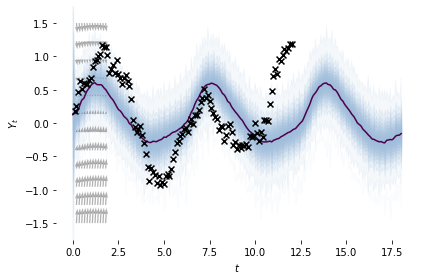

 10%|█         | 50/500 [00:21<05:32,  1.35it/s]

tensor(982.6517, grad_fn=<MeanBackward0>)


 10%|█         | 51/500 [00:21<04:47,  1.56it/s]

tensor(986.9588, grad_fn=<MeanBackward0>)


 10%|█         | 52/500 [00:22<04:15,  1.75it/s]

tensor(982.9176, grad_fn=<MeanBackward0>)
tensor(983.8494, grad_fn=<MeanBackward0>)


 11%|█         | 54/500 [00:23<03:46,  1.97it/s]

tensor(983.0145, grad_fn=<MeanBackward0>)
tensor(983.8843, grad_fn=<MeanBackward0>)


 11%|█         | 55/500 [00:23<03:34,  2.08it/s]

tensor(987.1366, grad_fn=<MeanBackward0>)


 11%|█▏        | 57/500 [00:24<03:20,  2.21it/s]

tensor(987.3636, grad_fn=<MeanBackward0>)


 12%|█▏        | 58/500 [00:24<03:10,  2.32it/s]

tensor(983.7409, grad_fn=<MeanBackward0>)


 12%|█▏        | 59/500 [00:25<03:03,  2.41it/s]

tensor(986.7708, grad_fn=<MeanBackward0>)


 12%|█▏        | 60/500 [00:25<02:59,  2.45it/s]

tensor(985.8328, grad_fn=<MeanBackward0>)
tensor(982.0500, grad_fn=<MeanBackward0>)


 12%|█▏        | 62/500 [00:26<03:02,  2.40it/s]

tensor(983.5358, grad_fn=<MeanBackward0>)


 13%|█▎        | 63/500 [00:26<03:03,  2.38it/s]

tensor(982.9452, grad_fn=<MeanBackward0>)


 13%|█▎        | 64/500 [00:27<03:03,  2.38it/s]

tensor(982.7849, grad_fn=<MeanBackward0>)


 13%|█▎        | 65/500 [00:27<02:57,  2.45it/s]

tensor(987.2334, grad_fn=<MeanBackward0>)


 13%|█▎        | 66/500 [00:28<02:56,  2.46it/s]

tensor(983.7391, grad_fn=<MeanBackward0>)


 13%|█▎        | 67/500 [00:28<02:52,  2.52it/s]

tensor(990.2942, grad_fn=<MeanBackward0>)


 14%|█▎        | 68/500 [00:28<02:49,  2.54it/s]

tensor(981.6711, grad_fn=<MeanBackward0>)


 14%|█▍        | 69/500 [00:29<02:49,  2.54it/s]

tensor(987.3851, grad_fn=<MeanBackward0>)


 14%|█▍        | 70/500 [00:29<02:51,  2.51it/s]

tensor(982.0663, grad_fn=<MeanBackward0>)


 14%|█▍        | 71/500 [00:29<02:47,  2.57it/s]

tensor(989.7077, grad_fn=<MeanBackward0>)


 14%|█▍        | 72/500 [00:30<02:51,  2.49it/s]

tensor(985.9408, grad_fn=<MeanBackward0>)


 15%|█▍        | 73/500 [00:30<02:53,  2.47it/s]

tensor(989.6036, grad_fn=<MeanBackward0>)


 15%|█▍        | 74/500 [00:31<02:56,  2.41it/s]

tensor(986.5749, grad_fn=<MeanBackward0>)


 15%|█▌        | 75/500 [00:31<02:51,  2.48it/s]

tensor(984.5089, grad_fn=<MeanBackward0>)


 15%|█▌        | 76/500 [00:31<02:48,  2.52it/s]

tensor(985.0037, grad_fn=<MeanBackward0>)


 15%|█▌        | 77/500 [00:32<02:43,  2.58it/s]

tensor(984.5397, grad_fn=<MeanBackward0>)


 16%|█▌        | 78/500 [00:32<02:41,  2.61it/s]

tensor(986.0129, grad_fn=<MeanBackward0>)


 16%|█▌        | 79/500 [00:33<02:39,  2.64it/s]

tensor(987.9691, grad_fn=<MeanBackward0>)


 16%|█▌        | 80/500 [00:33<02:37,  2.67it/s]

tensor(978.1607, grad_fn=<MeanBackward0>)


 16%|█▌        | 81/500 [00:33<02:36,  2.68it/s]

tensor(985.3381, grad_fn=<MeanBackward0>)


 16%|█▋        | 82/500 [00:34<02:34,  2.70it/s]

tensor(986.9430, grad_fn=<MeanBackward0>)


 17%|█▋        | 83/500 [00:34<02:33,  2.71it/s]

tensor(985.4221, grad_fn=<MeanBackward0>)


 17%|█▋        | 84/500 [00:34<02:33,  2.70it/s]

tensor(981.9348, grad_fn=<MeanBackward0>)


 17%|█▋        | 85/500 [00:35<02:37,  2.64it/s]

tensor(984.7266, grad_fn=<MeanBackward0>)


 17%|█▋        | 86/500 [00:35<02:38,  2.62it/s]

tensor(978.9385, grad_fn=<MeanBackward0>)


 17%|█▋        | 87/500 [00:36<02:37,  2.62it/s]

tensor(983.4114, grad_fn=<MeanBackward0>)


 18%|█▊        | 88/500 [00:36<02:35,  2.64it/s]

tensor(977.4948, grad_fn=<MeanBackward0>)


 18%|█▊        | 89/500 [00:36<02:34,  2.66it/s]

tensor(981.7814, grad_fn=<MeanBackward0>)


 18%|█▊        | 90/500 [00:37<02:32,  2.69it/s]

tensor(983.9413, grad_fn=<MeanBackward0>)


 18%|█▊        | 91/500 [00:37<02:31,  2.69it/s]

tensor(985.5199, grad_fn=<MeanBackward0>)


 18%|█▊        | 92/500 [00:37<02:31,  2.69it/s]

tensor(984.0376, grad_fn=<MeanBackward0>)


 19%|█▊        | 93/500 [00:38<02:30,  2.71it/s]

tensor(985.9905, grad_fn=<MeanBackward0>)


 19%|█▉        | 94/500 [00:38<02:29,  2.72it/s]

tensor(984.5645, grad_fn=<MeanBackward0>)


 19%|█▉        | 95/500 [00:39<02:29,  2.71it/s]

tensor(981.7626, grad_fn=<MeanBackward0>)


 19%|█▉        | 96/500 [00:39<02:31,  2.67it/s]

tensor(982.9914, grad_fn=<MeanBackward0>)


 19%|█▉        | 97/500 [00:39<02:32,  2.65it/s]

tensor(982.9126, grad_fn=<MeanBackward0>)


 20%|█▉        | 98/500 [00:40<02:31,  2.65it/s]

tensor(988.6794, grad_fn=<MeanBackward0>)


 20%|█▉        | 99/500 [00:40<02:31,  2.64it/s]

tensor(982.6898, grad_fn=<MeanBackward0>)


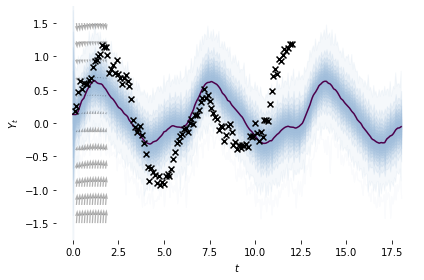

 20%|██        | 100/500 [00:42<04:44,  1.41it/s]

tensor(984.6937, grad_fn=<MeanBackward0>)
tensor(985.9197, grad_fn=<MeanBackward0>)


 20%|██        | 102/500 [00:42<03:43,  1.78it/s]

tensor(986.9914, grad_fn=<MeanBackward0>)
tensor(992.9687, grad_fn=<MeanBackward0>)


 21%|██        | 104/500 [00:43<03:12,  2.06it/s]

tensor(977.7103, grad_fn=<MeanBackward0>)


 21%|██        | 105/500 [00:44<03:01,  2.18it/s]

tensor(984.4026, grad_fn=<MeanBackward0>)


 21%|██        | 106/500 [00:44<02:55,  2.24it/s]

tensor(986.3234, grad_fn=<MeanBackward0>)
tensor(984.3560, grad_fn=<MeanBackward0>)


 22%|██▏       | 108/500 [00:45<02:49,  2.32it/s]

tensor(984.8292, grad_fn=<MeanBackward0>)


 22%|██▏       | 109/500 [00:45<02:44,  2.38it/s]

tensor(988.6698, grad_fn=<MeanBackward0>)


 22%|██▏       | 110/500 [00:46<02:40,  2.43it/s]

tensor(983.1455, grad_fn=<MeanBackward0>)


 22%|██▏       | 111/500 [00:46<02:39,  2.44it/s]

tensor(982.7760, grad_fn=<MeanBackward0>)


 22%|██▏       | 112/500 [00:46<02:37,  2.47it/s]

tensor(983.5532, grad_fn=<MeanBackward0>)


 23%|██▎       | 113/500 [00:47<02:34,  2.50it/s]

tensor(986.5416, grad_fn=<MeanBackward0>)


 23%|██▎       | 114/500 [00:47<02:32,  2.53it/s]

tensor(987.0666, grad_fn=<MeanBackward0>)


 23%|██▎       | 115/500 [00:48<02:30,  2.56it/s]

tensor(984.4683, grad_fn=<MeanBackward0>)


 23%|██▎       | 116/500 [00:48<02:27,  2.60it/s]

tensor(988.0364, grad_fn=<MeanBackward0>)


 23%|██▎       | 117/500 [00:48<02:27,  2.59it/s]

tensor(983.9678, grad_fn=<MeanBackward0>)


 24%|██▎       | 118/500 [00:49<02:25,  2.62it/s]

tensor(987.3812, grad_fn=<MeanBackward0>)


 24%|██▍       | 119/500 [00:49<02:23,  2.65it/s]

tensor(979.8828, grad_fn=<MeanBackward0>)


 24%|██▍       | 120/500 [00:49<02:21,  2.68it/s]

tensor(986.8842, grad_fn=<MeanBackward0>)


 24%|██▍       | 121/500 [00:50<02:20,  2.70it/s]

tensor(979.2960, grad_fn=<MeanBackward0>)


 24%|██▍       | 122/500 [00:50<02:18,  2.72it/s]

tensor(981.8859, grad_fn=<MeanBackward0>)


 25%|██▍       | 123/500 [00:51<02:17,  2.73it/s]

tensor(982.2512, grad_fn=<MeanBackward0>)


 25%|██▍       | 124/500 [00:51<02:16,  2.75it/s]

tensor(984.8058, grad_fn=<MeanBackward0>)


 25%|██▌       | 125/500 [00:51<02:18,  2.72it/s]

tensor(987.2861, grad_fn=<MeanBackward0>)


 25%|██▌       | 126/500 [00:52<02:17,  2.71it/s]

tensor(986.2004, grad_fn=<MeanBackward0>)


 25%|██▌       | 127/500 [00:52<02:18,  2.69it/s]

tensor(986.5098, grad_fn=<MeanBackward0>)


 26%|██▌       | 128/500 [00:52<02:18,  2.68it/s]

tensor(978.4619, grad_fn=<MeanBackward0>)


 26%|██▌       | 129/500 [00:53<02:17,  2.70it/s]

tensor(982.9476, grad_fn=<MeanBackward0>)


 26%|██▌       | 130/500 [00:53<02:16,  2.71it/s]

tensor(989.4921, grad_fn=<MeanBackward0>)


 26%|██▌       | 131/500 [00:54<02:15,  2.72it/s]

tensor(980.0925, grad_fn=<MeanBackward0>)


 26%|██▋       | 132/500 [00:54<02:14,  2.73it/s]

tensor(983.1083, grad_fn=<MeanBackward0>)


 27%|██▋       | 133/500 [00:54<02:14,  2.73it/s]

tensor(986.1047, grad_fn=<MeanBackward0>)


 27%|██▋       | 134/500 [00:55<02:14,  2.73it/s]

tensor(990.6971, grad_fn=<MeanBackward0>)


 27%|██▋       | 135/500 [00:55<02:13,  2.73it/s]

tensor(988.5895, grad_fn=<MeanBackward0>)


 27%|██▋       | 136/500 [00:55<02:15,  2.70it/s]

tensor(985.3987, grad_fn=<MeanBackward0>)


 27%|██▋       | 137/500 [00:56<02:14,  2.70it/s]

tensor(987.7250, grad_fn=<MeanBackward0>)


 28%|██▊       | 138/500 [00:56<02:14,  2.69it/s]

tensor(981.4165, grad_fn=<MeanBackward0>)


 28%|██▊       | 139/500 [00:57<02:14,  2.69it/s]

tensor(985.8283, grad_fn=<MeanBackward0>)


 28%|██▊       | 140/500 [00:57<02:12,  2.71it/s]

tensor(982.5166, grad_fn=<MeanBackward0>)


 28%|██▊       | 141/500 [00:57<02:11,  2.72it/s]

tensor(980.6724, grad_fn=<MeanBackward0>)


 28%|██▊       | 142/500 [00:58<02:11,  2.72it/s]

tensor(987.3710, grad_fn=<MeanBackward0>)


 29%|██▊       | 143/500 [00:58<02:11,  2.71it/s]

tensor(981.6156, grad_fn=<MeanBackward0>)


 29%|██▉       | 144/500 [00:58<02:10,  2.73it/s]

tensor(983.9048, grad_fn=<MeanBackward0>)


 29%|██▉       | 145/500 [00:59<02:11,  2.70it/s]

tensor(982.9349, grad_fn=<MeanBackward0>)


 29%|██▉       | 146/500 [00:59<02:11,  2.70it/s]

tensor(984.2949, grad_fn=<MeanBackward0>)


 29%|██▉       | 147/500 [00:59<02:09,  2.72it/s]

tensor(980.0831, grad_fn=<MeanBackward0>)


 30%|██▉       | 148/500 [01:00<02:09,  2.73it/s]

tensor(991.1314, grad_fn=<MeanBackward0>)


 30%|██▉       | 149/500 [01:00<02:32,  2.30it/s]

tensor(984.4877, grad_fn=<MeanBackward0>)


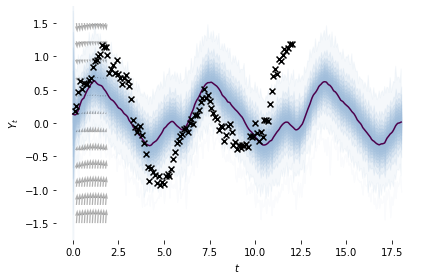

 30%|███       | 150/500 [01:02<04:19,  1.35it/s]

tensor(988.2309, grad_fn=<MeanBackward0>)


 30%|███       | 151/500 [01:02<03:40,  1.58it/s]

tensor(981.7211, grad_fn=<MeanBackward0>)


 30%|███       | 152/500 [01:03<03:13,  1.80it/s]

tensor(987.5615, grad_fn=<MeanBackward0>)


 31%|███       | 153/500 [01:03<02:57,  1.95it/s]

tensor(986.8490, grad_fn=<MeanBackward0>)


 31%|███       | 154/500 [01:03<02:45,  2.09it/s]

tensor(979.5295, grad_fn=<MeanBackward0>)


 31%|███       | 155/500 [01:04<02:36,  2.21it/s]

tensor(982.8574, grad_fn=<MeanBackward0>)
tensor(983.7554, grad_fn=<MeanBackward0>)


 31%|███▏      | 157/500 [01:05<02:26,  2.33it/s]

tensor(983.2963, grad_fn=<MeanBackward0>)


 32%|███▏      | 158/500 [01:05<02:21,  2.42it/s]

tensor(980.8153, grad_fn=<MeanBackward0>)


 32%|███▏      | 159/500 [01:05<02:18,  2.47it/s]

tensor(980.8491, grad_fn=<MeanBackward0>)


 32%|███▏      | 160/500 [01:06<02:15,  2.52it/s]

tensor(984.3944, grad_fn=<MeanBackward0>)


 32%|███▏      | 161/500 [01:06<02:14,  2.53it/s]

tensor(985.0715, grad_fn=<MeanBackward0>)


 32%|███▏      | 162/500 [01:07<02:11,  2.57it/s]

tensor(985.8969, grad_fn=<MeanBackward0>)


 33%|███▎      | 163/500 [01:07<02:08,  2.62it/s]

tensor(981.6446, grad_fn=<MeanBackward0>)


 33%|███▎      | 164/500 [01:07<02:06,  2.66it/s]

tensor(978.3384, grad_fn=<MeanBackward0>)


 33%|███▎      | 165/500 [01:08<02:04,  2.69it/s]

tensor(985.3057, grad_fn=<MeanBackward0>)


 33%|███▎      | 166/500 [01:08<02:03,  2.70it/s]

tensor(984.9639, grad_fn=<MeanBackward0>)


 33%|███▎      | 167/500 [01:08<02:03,  2.71it/s]

tensor(983.4058, grad_fn=<MeanBackward0>)


 34%|███▎      | 168/500 [01:09<02:02,  2.72it/s]

tensor(987.1047, grad_fn=<MeanBackward0>)


 34%|███▍      | 169/500 [01:09<02:01,  2.72it/s]

tensor(984.8295, grad_fn=<MeanBackward0>)


 34%|███▍      | 170/500 [01:09<02:02,  2.70it/s]

tensor(976.9730, grad_fn=<MeanBackward0>)


 34%|███▍      | 171/500 [01:10<02:01,  2.71it/s]

tensor(979.5207, grad_fn=<MeanBackward0>)


 34%|███▍      | 172/500 [01:10<02:00,  2.72it/s]

tensor(987.2720, grad_fn=<MeanBackward0>)


 35%|███▍      | 173/500 [01:11<02:00,  2.72it/s]

tensor(982.6281, grad_fn=<MeanBackward0>)


 35%|███▍      | 174/500 [01:11<01:59,  2.73it/s]

tensor(986.1245, grad_fn=<MeanBackward0>)


 35%|███▌      | 175/500 [01:11<01:59,  2.71it/s]

tensor(985.8361, grad_fn=<MeanBackward0>)


 35%|███▌      | 176/500 [01:12<01:59,  2.71it/s]

tensor(981.0981, grad_fn=<MeanBackward0>)


 35%|███▌      | 177/500 [01:12<01:58,  2.72it/s]

tensor(983.2725, grad_fn=<MeanBackward0>)


 36%|███▌      | 178/500 [01:12<01:58,  2.73it/s]

tensor(977.1987, grad_fn=<MeanBackward0>)


 36%|███▌      | 179/500 [01:13<01:57,  2.73it/s]

tensor(984.7508, grad_fn=<MeanBackward0>)


 36%|███▌      | 180/500 [01:13<01:57,  2.72it/s]

tensor(983.2559, grad_fn=<MeanBackward0>)


 36%|███▌      | 181/500 [01:14<01:58,  2.69it/s]

tensor(976.9922, grad_fn=<MeanBackward0>)


 36%|███▋      | 182/500 [01:14<01:58,  2.68it/s]

tensor(979.7714, grad_fn=<MeanBackward0>)


 37%|███▋      | 183/500 [01:14<01:58,  2.68it/s]

tensor(984.1711, grad_fn=<MeanBackward0>)


 37%|███▋      | 184/500 [01:15<01:57,  2.69it/s]

tensor(985.7275, grad_fn=<MeanBackward0>)


 37%|███▋      | 185/500 [01:15<01:57,  2.69it/s]

tensor(978.1633, grad_fn=<MeanBackward0>)


 37%|███▋      | 186/500 [01:15<01:55,  2.71it/s]

tensor(986.3494, grad_fn=<MeanBackward0>)


 37%|███▋      | 187/500 [01:16<01:56,  2.69it/s]

tensor(987.3253, grad_fn=<MeanBackward0>)


 38%|███▊      | 188/500 [01:16<01:55,  2.70it/s]

tensor(978.5677, grad_fn=<MeanBackward0>)


 38%|███▊      | 189/500 [01:17<01:56,  2.66it/s]

tensor(982.0740, grad_fn=<MeanBackward0>)


 38%|███▊      | 190/500 [01:17<01:55,  2.69it/s]

tensor(984.4340, grad_fn=<MeanBackward0>)


 38%|███▊      | 191/500 [01:17<01:55,  2.68it/s]

tensor(982.1287, grad_fn=<MeanBackward0>)


 38%|███▊      | 192/500 [01:18<01:56,  2.64it/s]

tensor(985.8812, grad_fn=<MeanBackward0>)


 39%|███▊      | 193/500 [01:18<01:55,  2.66it/s]

tensor(981.2785, grad_fn=<MeanBackward0>)


 39%|███▉      | 194/500 [01:18<01:54,  2.66it/s]

tensor(979.7111, grad_fn=<MeanBackward0>)


 39%|███▉      | 195/500 [01:19<01:53,  2.68it/s]

tensor(977.7453, grad_fn=<MeanBackward0>)


 39%|███▉      | 196/500 [01:19<01:52,  2.71it/s]

tensor(983.4613, grad_fn=<MeanBackward0>)


 39%|███▉      | 197/500 [01:19<01:52,  2.70it/s]

tensor(978.7460, grad_fn=<MeanBackward0>)


 40%|███▉      | 198/500 [01:20<01:52,  2.69it/s]

tensor(984.0866, grad_fn=<MeanBackward0>)


 40%|███▉      | 199/500 [01:20<01:52,  2.67it/s]

tensor(983.2382, grad_fn=<MeanBackward0>)


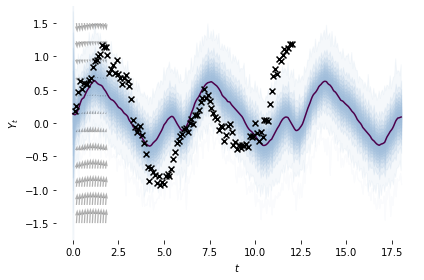

 40%|████      | 200/500 [01:22<03:25,  1.46it/s]

tensor(981.6757, grad_fn=<MeanBackward0>)


 40%|████      | 201/500 [01:22<02:58,  1.68it/s]

tensor(982.6994, grad_fn=<MeanBackward0>)


 40%|████      | 202/500 [01:22<02:37,  1.89it/s]

tensor(984.3306, grad_fn=<MeanBackward0>)


 41%|████      | 203/500 [01:23<02:23,  2.07it/s]

tensor(979.9549, grad_fn=<MeanBackward0>)


 41%|████      | 204/500 [01:23<02:14,  2.20it/s]

tensor(980.6172, grad_fn=<MeanBackward0>)


 41%|████      | 205/500 [01:24<02:09,  2.28it/s]

tensor(977.8122, grad_fn=<MeanBackward0>)


 41%|████      | 206/500 [01:24<02:04,  2.36it/s]

tensor(985.2231, grad_fn=<MeanBackward0>)


 41%|████▏     | 207/500 [01:24<02:05,  2.34it/s]

tensor(982.9465, grad_fn=<MeanBackward0>)


 42%|████▏     | 208/500 [01:25<02:00,  2.43it/s]

tensor(982.5858, grad_fn=<MeanBackward0>)


 42%|████▏     | 209/500 [01:25<01:57,  2.47it/s]

tensor(982.2098, grad_fn=<MeanBackward0>)


 42%|████▏     | 210/500 [01:26<01:55,  2.51it/s]

tensor(980.1200, grad_fn=<MeanBackward0>)


 42%|████▏     | 211/500 [01:26<01:53,  2.54it/s]

tensor(981.5706, grad_fn=<MeanBackward0>)


 42%|████▏     | 212/500 [01:26<01:52,  2.57it/s]

tensor(982.6470, grad_fn=<MeanBackward0>)


 43%|████▎     | 213/500 [01:27<01:49,  2.61it/s]

tensor(987.0657, grad_fn=<MeanBackward0>)


 43%|████▎     | 214/500 [01:27<01:48,  2.64it/s]

tensor(982.9283, grad_fn=<MeanBackward0>)


 43%|████▎     | 215/500 [01:27<01:46,  2.67it/s]

tensor(980.3068, grad_fn=<MeanBackward0>)


 43%|████▎     | 216/500 [01:28<01:45,  2.69it/s]

tensor(978.3419, grad_fn=<MeanBackward0>)


 43%|████▎     | 217/500 [01:28<01:45,  2.69it/s]

tensor(982.5273, grad_fn=<MeanBackward0>)


 44%|████▎     | 218/500 [01:29<01:44,  2.69it/s]

tensor(979.3925, grad_fn=<MeanBackward0>)


 44%|████▍     | 219/500 [01:29<01:44,  2.70it/s]

tensor(981.7976, grad_fn=<MeanBackward0>)


 44%|████▍     | 220/500 [01:29<01:43,  2.69it/s]

tensor(983.5313, grad_fn=<MeanBackward0>)


 44%|████▍     | 221/500 [01:30<01:43,  2.69it/s]

tensor(981.4187, grad_fn=<MeanBackward0>)


 44%|████▍     | 222/500 [01:30<01:43,  2.68it/s]

tensor(978.9201, grad_fn=<MeanBackward0>)


 45%|████▍     | 223/500 [01:30<01:43,  2.67it/s]

tensor(981.7688, grad_fn=<MeanBackward0>)


 45%|████▍     | 224/500 [01:31<01:50,  2.50it/s]

tensor(982.2581, grad_fn=<MeanBackward0>)


 45%|████▌     | 225/500 [01:31<01:47,  2.55it/s]

tensor(983.8772, grad_fn=<MeanBackward0>)


 45%|████▌     | 226/500 [01:32<01:45,  2.61it/s]

tensor(988.5993, grad_fn=<MeanBackward0>)


 45%|████▌     | 227/500 [01:32<01:43,  2.65it/s]

tensor(979.2406, grad_fn=<MeanBackward0>)


 46%|████▌     | 228/500 [01:32<01:41,  2.68it/s]

tensor(986.0785, grad_fn=<MeanBackward0>)


 46%|████▌     | 229/500 [01:33<01:40,  2.69it/s]

tensor(984.6681, grad_fn=<MeanBackward0>)


 46%|████▌     | 230/500 [01:33<01:41,  2.67it/s]

tensor(984.1415, grad_fn=<MeanBackward0>)


 46%|████▌     | 231/500 [01:33<01:41,  2.66it/s]

tensor(982.8846, grad_fn=<MeanBackward0>)


 46%|████▋     | 232/500 [01:34<01:39,  2.69it/s]

tensor(987.4962, grad_fn=<MeanBackward0>)


 47%|████▋     | 233/500 [01:34<01:38,  2.70it/s]

tensor(989.1094, grad_fn=<MeanBackward0>)


 47%|████▋     | 234/500 [01:35<01:38,  2.71it/s]

tensor(980.2652, grad_fn=<MeanBackward0>)


 47%|████▋     | 235/500 [01:35<01:37,  2.73it/s]

tensor(983.3721, grad_fn=<MeanBackward0>)


 47%|████▋     | 236/500 [01:35<01:36,  2.73it/s]

tensor(981.5043, grad_fn=<MeanBackward0>)


 47%|████▋     | 237/500 [01:36<01:36,  2.73it/s]

tensor(979.9874, grad_fn=<MeanBackward0>)


 48%|████▊     | 238/500 [01:36<01:38,  2.66it/s]

tensor(983.1920, grad_fn=<MeanBackward0>)


 48%|████▊     | 239/500 [01:36<01:40,  2.60it/s]

tensor(977.1630, grad_fn=<MeanBackward0>)


 48%|████▊     | 240/500 [01:37<01:39,  2.62it/s]

tensor(988.3497, grad_fn=<MeanBackward0>)


 48%|████▊     | 241/500 [01:37<01:39,  2.61it/s]

tensor(978.6929, grad_fn=<MeanBackward0>)


 48%|████▊     | 242/500 [01:38<01:39,  2.60it/s]

tensor(981.9866, grad_fn=<MeanBackward0>)


 49%|████▊     | 243/500 [01:38<01:39,  2.59it/s]

tensor(980.0773, grad_fn=<MeanBackward0>)


 49%|████▉     | 244/500 [01:38<01:38,  2.61it/s]

tensor(984.1316, grad_fn=<MeanBackward0>)


 49%|████▉     | 245/500 [01:39<01:37,  2.61it/s]

tensor(980.5073, grad_fn=<MeanBackward0>)


 49%|████▉     | 246/500 [01:39<01:37,  2.61it/s]

tensor(982.9123, grad_fn=<MeanBackward0>)


 49%|████▉     | 247/500 [01:39<01:36,  2.62it/s]

tensor(978.8789, grad_fn=<MeanBackward0>)


 50%|████▉     | 248/500 [01:40<01:36,  2.62it/s]

tensor(980.9556, grad_fn=<MeanBackward0>)


 50%|████▉     | 249/500 [01:40<01:36,  2.60it/s]

tensor(976.8683, grad_fn=<MeanBackward0>)


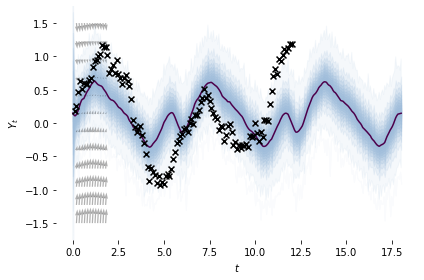

tensor(981.6562, grad_fn=<MeanBackward0>)


 50%|█████     | 251/500 [01:42<02:32,  1.63it/s]

tensor(976.4769, grad_fn=<MeanBackward0>)


 50%|█████     | 252/500 [01:43<02:15,  1.83it/s]

tensor(977.1794, grad_fn=<MeanBackward0>)


 51%|█████     | 253/500 [01:43<02:03,  2.00it/s]

tensor(980.7029, grad_fn=<MeanBackward0>)


 51%|█████     | 254/500 [01:43<01:56,  2.12it/s]

tensor(984.3273, grad_fn=<MeanBackward0>)


 51%|█████     | 255/500 [01:44<01:49,  2.23it/s]

tensor(980.9294, grad_fn=<MeanBackward0>)


 51%|█████     | 256/500 [01:44<01:46,  2.30it/s]

tensor(983.0876, grad_fn=<MeanBackward0>)


 51%|█████▏    | 257/500 [01:45<01:46,  2.29it/s]

tensor(976.7163, grad_fn=<MeanBackward0>)


 52%|█████▏    | 258/500 [01:45<01:41,  2.38it/s]

tensor(977.5679, grad_fn=<MeanBackward0>)


 52%|█████▏    | 259/500 [01:45<01:38,  2.45it/s]

tensor(978.6132, grad_fn=<MeanBackward0>)


 52%|█████▏    | 260/500 [01:46<01:37,  2.47it/s]

tensor(979.5844, grad_fn=<MeanBackward0>)


 52%|█████▏    | 261/500 [01:46<01:36,  2.48it/s]

tensor(980.4739, grad_fn=<MeanBackward0>)


 52%|█████▏    | 262/500 [01:46<01:34,  2.53it/s]

tensor(984.5672, grad_fn=<MeanBackward0>)


 53%|█████▎    | 263/500 [01:47<01:32,  2.57it/s]

tensor(988.0977, grad_fn=<MeanBackward0>)


 53%|█████▎    | 264/500 [01:47<01:30,  2.60it/s]

tensor(978.9883, grad_fn=<MeanBackward0>)


 53%|█████▎    | 265/500 [01:48<01:29,  2.63it/s]

tensor(976.0466, grad_fn=<MeanBackward0>)


 53%|█████▎    | 266/500 [01:48<01:27,  2.66it/s]

tensor(981.6136, grad_fn=<MeanBackward0>)


 53%|█████▎    | 267/500 [01:48<01:27,  2.67it/s]

tensor(980.7354, grad_fn=<MeanBackward0>)


 54%|█████▎    | 268/500 [01:49<01:26,  2.68it/s]

tensor(984.5673, grad_fn=<MeanBackward0>)


 54%|█████▍    | 269/500 [01:49<01:25,  2.70it/s]

tensor(982.6981, grad_fn=<MeanBackward0>)


 54%|█████▍    | 270/500 [01:49<01:25,  2.70it/s]

tensor(980.7841, grad_fn=<MeanBackward0>)


 54%|█████▍    | 271/500 [01:50<01:24,  2.70it/s]

tensor(980.6380, grad_fn=<MeanBackward0>)


 54%|█████▍    | 272/500 [01:50<01:24,  2.69it/s]

tensor(976.7359, grad_fn=<MeanBackward0>)


 55%|█████▍    | 273/500 [01:51<01:25,  2.67it/s]

tensor(979.9362, grad_fn=<MeanBackward0>)


 55%|█████▍    | 274/500 [01:51<01:23,  2.69it/s]

tensor(980.3259, grad_fn=<MeanBackward0>)


 55%|█████▌    | 275/500 [01:51<01:23,  2.71it/s]

tensor(984.7994, grad_fn=<MeanBackward0>)


 55%|█████▌    | 276/500 [01:52<01:22,  2.71it/s]

tensor(981.7213, grad_fn=<MeanBackward0>)


 55%|█████▌    | 277/500 [01:52<01:21,  2.72it/s]

tensor(982.2787, grad_fn=<MeanBackward0>)


 56%|█████▌    | 278/500 [01:52<01:21,  2.72it/s]

tensor(982.4520, grad_fn=<MeanBackward0>)


 56%|█████▌    | 279/500 [01:53<01:21,  2.72it/s]

tensor(980.5670, grad_fn=<MeanBackward0>)


 56%|█████▌    | 280/500 [01:53<01:20,  2.72it/s]

tensor(979.0256, grad_fn=<MeanBackward0>)


 56%|█████▌    | 281/500 [01:53<01:20,  2.73it/s]

tensor(975.0655, grad_fn=<MeanBackward0>)


 56%|█████▋    | 282/500 [01:54<01:19,  2.73it/s]

tensor(979.9359, grad_fn=<MeanBackward0>)


 57%|█████▋    | 283/500 [01:54<01:19,  2.73it/s]

tensor(982.1476, grad_fn=<MeanBackward0>)


 57%|█████▋    | 284/500 [01:55<01:18,  2.74it/s]

tensor(980.7320, grad_fn=<MeanBackward0>)


 57%|█████▋    | 285/500 [01:55<01:18,  2.74it/s]

tensor(983.4510, grad_fn=<MeanBackward0>)


 57%|█████▋    | 286/500 [01:55<01:18,  2.74it/s]

tensor(981.7047, grad_fn=<MeanBackward0>)


 57%|█████▋    | 287/500 [01:56<01:17,  2.73it/s]

tensor(986.8444, grad_fn=<MeanBackward0>)


 58%|█████▊    | 288/500 [01:56<01:17,  2.74it/s]

tensor(983.5078, grad_fn=<MeanBackward0>)


 58%|█████▊    | 289/500 [01:56<01:17,  2.72it/s]

tensor(976.2856, grad_fn=<MeanBackward0>)


 58%|█████▊    | 290/500 [01:57<01:17,  2.72it/s]

tensor(982.8433, grad_fn=<MeanBackward0>)


 58%|█████▊    | 291/500 [01:57<01:17,  2.71it/s]

tensor(977.3408, grad_fn=<MeanBackward0>)


 58%|█████▊    | 292/500 [01:58<01:17,  2.68it/s]

tensor(983.4735, grad_fn=<MeanBackward0>)


 59%|█████▊    | 293/500 [01:58<01:17,  2.69it/s]

tensor(976.8322, grad_fn=<MeanBackward0>)


 59%|█████▉    | 294/500 [01:58<01:16,  2.68it/s]

tensor(977.5619, grad_fn=<MeanBackward0>)


 59%|█████▉    | 295/500 [01:59<01:16,  2.69it/s]

tensor(976.9470, grad_fn=<MeanBackward0>)


 59%|█████▉    | 296/500 [01:59<01:15,  2.69it/s]

tensor(978.1476, grad_fn=<MeanBackward0>)


 59%|█████▉    | 297/500 [01:59<01:15,  2.68it/s]

tensor(982.4946, grad_fn=<MeanBackward0>)


 60%|█████▉    | 298/500 [02:00<01:14,  2.69it/s]

tensor(978.9165, grad_fn=<MeanBackward0>)


 60%|█████▉    | 299/500 [02:00<01:15,  2.68it/s]

tensor(981.4699, grad_fn=<MeanBackward0>)


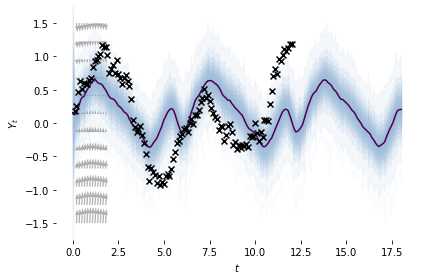

 60%|██████    | 300/500 [02:02<02:16,  1.46it/s]

tensor(980.7708, grad_fn=<MeanBackward0>)


 60%|██████    | 301/500 [02:02<01:58,  1.68it/s]

tensor(985.5029, grad_fn=<MeanBackward0>)


 60%|██████    | 302/500 [02:02<01:45,  1.89it/s]

tensor(976.8083, grad_fn=<MeanBackward0>)


 61%|██████    | 303/500 [02:03<01:35,  2.06it/s]

tensor(981.3163, grad_fn=<MeanBackward0>)


 61%|██████    | 304/500 [02:03<01:29,  2.20it/s]

tensor(979.6839, grad_fn=<MeanBackward0>)


 61%|██████    | 305/500 [02:03<01:24,  2.31it/s]

tensor(978.4051, grad_fn=<MeanBackward0>)


 61%|██████    | 306/500 [02:04<01:21,  2.39it/s]

tensor(980.5182, grad_fn=<MeanBackward0>)


 61%|██████▏   | 307/500 [02:04<01:20,  2.40it/s]

tensor(975.1301, grad_fn=<MeanBackward0>)


 62%|██████▏   | 308/500 [02:05<01:18,  2.46it/s]

tensor(977.9522, grad_fn=<MeanBackward0>)


 62%|██████▏   | 309/500 [02:05<01:15,  2.53it/s]

tensor(976.8859, grad_fn=<MeanBackward0>)


 62%|██████▏   | 310/500 [02:05<01:14,  2.56it/s]

tensor(985.5839, grad_fn=<MeanBackward0>)


 62%|██████▏   | 311/500 [02:06<01:13,  2.59it/s]

tensor(976.7537, grad_fn=<MeanBackward0>)


 62%|██████▏   | 312/500 [02:06<01:11,  2.62it/s]

tensor(978.3682, grad_fn=<MeanBackward0>)


 63%|██████▎   | 313/500 [02:07<01:10,  2.64it/s]

tensor(986.6265, grad_fn=<MeanBackward0>)


 63%|██████▎   | 314/500 [02:07<01:09,  2.67it/s]

tensor(983.4685, grad_fn=<MeanBackward0>)


 63%|██████▎   | 315/500 [02:07<01:08,  2.70it/s]

tensor(986.3304, grad_fn=<MeanBackward0>)
tensor(977.9077, grad_fn=<MeanBackward0>)


 63%|██████▎   | 317/500 [02:08<01:09,  2.65it/s]

tensor(975.7390, grad_fn=<MeanBackward0>)


 64%|██████▎   | 318/500 [02:08<01:07,  2.68it/s]

tensor(979.6593, grad_fn=<MeanBackward0>)


 64%|██████▍   | 319/500 [02:09<01:07,  2.70it/s]

tensor(975.9717, grad_fn=<MeanBackward0>)


 64%|██████▍   | 320/500 [02:09<01:07,  2.67it/s]

tensor(982.5808, grad_fn=<MeanBackward0>)


 64%|██████▍   | 321/500 [02:09<01:06,  2.70it/s]

tensor(970.1524, grad_fn=<MeanBackward0>)


 64%|██████▍   | 322/500 [02:10<01:05,  2.71it/s]

tensor(983.6046, grad_fn=<MeanBackward0>)


 65%|██████▍   | 323/500 [02:10<01:05,  2.72it/s]

tensor(978.4833, grad_fn=<MeanBackward0>)


 65%|██████▍   | 324/500 [02:11<01:04,  2.74it/s]

tensor(982.0192, grad_fn=<MeanBackward0>)


 65%|██████▌   | 325/500 [02:11<01:03,  2.74it/s]

tensor(980.5677, grad_fn=<MeanBackward0>)


 65%|██████▌   | 326/500 [02:11<01:03,  2.73it/s]

tensor(976.2786, grad_fn=<MeanBackward0>)


 65%|██████▌   | 327/500 [02:12<01:03,  2.74it/s]

tensor(985.0229, grad_fn=<MeanBackward0>)


 66%|██████▌   | 328/500 [02:12<01:02,  2.74it/s]

tensor(974.5280, grad_fn=<MeanBackward0>)


 66%|██████▌   | 329/500 [02:12<01:02,  2.74it/s]

tensor(982.5394, grad_fn=<MeanBackward0>)


 66%|██████▌   | 330/500 [02:13<01:02,  2.74it/s]

tensor(975.1488, grad_fn=<MeanBackward0>)


 66%|██████▌   | 331/500 [02:13<01:01,  2.74it/s]

tensor(981.8411, grad_fn=<MeanBackward0>)


 66%|██████▋   | 332/500 [02:13<01:01,  2.74it/s]

tensor(983.6539, grad_fn=<MeanBackward0>)


 67%|██████▋   | 333/500 [02:14<01:03,  2.63it/s]

tensor(985.3896, grad_fn=<MeanBackward0>)


 67%|██████▋   | 334/500 [02:14<01:04,  2.59it/s]

tensor(980.6669, grad_fn=<MeanBackward0>)
tensor(978.7594, grad_fn=<MeanBackward0>)


 67%|██████▋   | 336/500 [02:15<01:04,  2.55it/s]

tensor(983.3095, grad_fn=<MeanBackward0>)
tensor(981.3757, grad_fn=<MeanBackward0>)


 68%|██████▊   | 338/500 [02:16<01:03,  2.54it/s]

tensor(977.6321, grad_fn=<MeanBackward0>)


 68%|██████▊   | 339/500 [02:16<01:02,  2.57it/s]

tensor(973.5864, grad_fn=<MeanBackward0>)


 68%|██████▊   | 340/500 [02:17<01:02,  2.54it/s]

tensor(982.0753, grad_fn=<MeanBackward0>)


 68%|██████▊   | 341/500 [02:17<01:02,  2.54it/s]

tensor(980.9834, grad_fn=<MeanBackward0>)


 68%|██████▊   | 342/500 [02:17<01:01,  2.57it/s]

tensor(983.9250, grad_fn=<MeanBackward0>)


 69%|██████▊   | 343/500 [02:18<01:02,  2.52it/s]

tensor(981.2570, grad_fn=<MeanBackward0>)


 69%|██████▉   | 344/500 [02:18<01:01,  2.54it/s]

tensor(981.6481, grad_fn=<MeanBackward0>)


 69%|██████▉   | 345/500 [02:19<00:59,  2.59it/s]

tensor(980.1367, grad_fn=<MeanBackward0>)


 69%|██████▉   | 346/500 [02:19<00:59,  2.58it/s]

tensor(979.3716, grad_fn=<MeanBackward0>)


 69%|██████▉   | 347/500 [02:19<00:58,  2.61it/s]

tensor(980.7849, grad_fn=<MeanBackward0>)


 70%|██████▉   | 348/500 [02:20<00:58,  2.61it/s]

tensor(981.9144, grad_fn=<MeanBackward0>)


 70%|██████▉   | 349/500 [02:20<00:57,  2.61it/s]

tensor(982.5851, grad_fn=<MeanBackward0>)


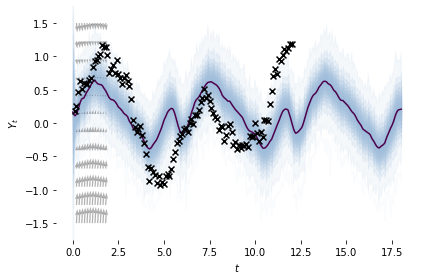

 70%|███████   | 350/500 [02:22<01:45,  1.42it/s]

tensor(973.8260, grad_fn=<MeanBackward0>)


 70%|███████   | 351/500 [02:22<01:31,  1.63it/s]

tensor(982.7867, grad_fn=<MeanBackward0>)


 70%|███████   | 352/500 [02:22<01:21,  1.83it/s]

tensor(982.9052, grad_fn=<MeanBackward0>)


 71%|███████   | 353/500 [02:23<01:13,  2.00it/s]

tensor(982.7843, grad_fn=<MeanBackward0>)


 71%|███████   | 354/500 [02:23<01:07,  2.16it/s]

tensor(977.6466, grad_fn=<MeanBackward0>)


 71%|███████   | 355/500 [02:24<01:03,  2.28it/s]

tensor(978.6484, grad_fn=<MeanBackward0>)
tensor(985.4204, grad_fn=<MeanBackward0>)


 71%|███████▏  | 357/500 [02:24<00:59,  2.38it/s]

tensor(981.5104, grad_fn=<MeanBackward0>)


 72%|███████▏  | 358/500 [02:25<00:57,  2.47it/s]

tensor(984.2579, grad_fn=<MeanBackward0>)


 72%|███████▏  | 359/500 [02:25<00:55,  2.54it/s]

tensor(980.9203, grad_fn=<MeanBackward0>)


 72%|███████▏  | 360/500 [02:25<00:54,  2.58it/s]

tensor(981.5198, grad_fn=<MeanBackward0>)


 72%|███████▏  | 361/500 [02:26<00:53,  2.59it/s]

tensor(983.6427, grad_fn=<MeanBackward0>)


 72%|███████▏  | 362/500 [02:26<00:52,  2.62it/s]

tensor(979.7829, grad_fn=<MeanBackward0>)


 73%|███████▎  | 363/500 [02:27<00:51,  2.66it/s]

tensor(978.0172, grad_fn=<MeanBackward0>)


 73%|███████▎  | 364/500 [02:27<00:50,  2.69it/s]

tensor(977.2801, grad_fn=<MeanBackward0>)


 73%|███████▎  | 365/500 [02:27<00:49,  2.71it/s]

tensor(980.4366, grad_fn=<MeanBackward0>)


 73%|███████▎  | 366/500 [02:28<00:50,  2.67it/s]

tensor(981.5797, grad_fn=<MeanBackward0>)


 73%|███████▎  | 367/500 [02:28<00:49,  2.68it/s]

tensor(970.9242, grad_fn=<MeanBackward0>)


 74%|███████▎  | 368/500 [02:28<00:48,  2.70it/s]

tensor(977.9340, grad_fn=<MeanBackward0>)


 74%|███████▍  | 369/500 [02:29<00:48,  2.72it/s]

tensor(981.3280, grad_fn=<MeanBackward0>)


 74%|███████▍  | 370/500 [02:29<00:47,  2.72it/s]

tensor(976.5929, grad_fn=<MeanBackward0>)


 74%|███████▍  | 371/500 [02:30<00:47,  2.72it/s]

tensor(979.6597, grad_fn=<MeanBackward0>)


 74%|███████▍  | 372/500 [02:30<00:46,  2.73it/s]

tensor(980.5143, grad_fn=<MeanBackward0>)


 75%|███████▍  | 373/500 [02:30<00:46,  2.73it/s]

tensor(977.8492, grad_fn=<MeanBackward0>)


 75%|███████▍  | 374/500 [02:31<00:46,  2.74it/s]

tensor(981.9321, grad_fn=<MeanBackward0>)


 75%|███████▌  | 375/500 [02:31<00:45,  2.74it/s]

tensor(984.1038, grad_fn=<MeanBackward0>)


 75%|███████▌  | 376/500 [02:31<00:45,  2.75it/s]

tensor(978.2139, grad_fn=<MeanBackward0>)


 75%|███████▌  | 377/500 [02:32<00:44,  2.74it/s]

tensor(980.0387, grad_fn=<MeanBackward0>)


 76%|███████▌  | 378/500 [02:32<00:44,  2.74it/s]

tensor(980.1346, grad_fn=<MeanBackward0>)


 76%|███████▌  | 379/500 [02:32<00:44,  2.74it/s]

tensor(981.7288, grad_fn=<MeanBackward0>)


 76%|███████▌  | 380/500 [02:33<00:43,  2.75it/s]

tensor(984.0679, grad_fn=<MeanBackward0>)


 76%|███████▌  | 381/500 [02:33<00:43,  2.76it/s]

tensor(975.0693, grad_fn=<MeanBackward0>)


 76%|███████▋  | 382/500 [02:34<00:42,  2.76it/s]

tensor(981.0019, grad_fn=<MeanBackward0>)


 77%|███████▋  | 383/500 [02:34<00:42,  2.76it/s]

tensor(980.9865, grad_fn=<MeanBackward0>)


 77%|███████▋  | 384/500 [02:34<00:42,  2.76it/s]

tensor(986.0319, grad_fn=<MeanBackward0>)


 77%|███████▋  | 385/500 [02:35<00:41,  2.75it/s]

tensor(984.3791, grad_fn=<MeanBackward0>)


 77%|███████▋  | 386/500 [02:35<00:41,  2.75it/s]

tensor(974.2859, grad_fn=<MeanBackward0>)


 77%|███████▋  | 387/500 [02:35<00:41,  2.75it/s]

tensor(976.4194, grad_fn=<MeanBackward0>)


 78%|███████▊  | 388/500 [02:36<00:41,  2.73it/s]

tensor(981.9774, grad_fn=<MeanBackward0>)


 78%|███████▊  | 389/500 [02:36<00:40,  2.74it/s]

tensor(979.5869, grad_fn=<MeanBackward0>)


 78%|███████▊  | 390/500 [02:36<00:40,  2.74it/s]

tensor(981.8527, grad_fn=<MeanBackward0>)


 78%|███████▊  | 391/500 [02:37<00:39,  2.75it/s]

tensor(978.2761, grad_fn=<MeanBackward0>)


 78%|███████▊  | 392/500 [02:37<00:39,  2.75it/s]

tensor(976.5391, grad_fn=<MeanBackward0>)


 79%|███████▊  | 393/500 [02:38<00:38,  2.76it/s]

tensor(976.2401, grad_fn=<MeanBackward0>)


 79%|███████▉  | 394/500 [02:38<00:38,  2.76it/s]

tensor(982.3321, grad_fn=<MeanBackward0>)


 79%|███████▉  | 395/500 [02:38<00:38,  2.76it/s]

tensor(976.5366, grad_fn=<MeanBackward0>)


 79%|███████▉  | 396/500 [02:39<00:37,  2.76it/s]

tensor(976.6846, grad_fn=<MeanBackward0>)


 79%|███████▉  | 397/500 [02:39<00:37,  2.76it/s]

tensor(979.6990, grad_fn=<MeanBackward0>)


 80%|███████▉  | 398/500 [02:39<00:36,  2.76it/s]

tensor(982.9052, grad_fn=<MeanBackward0>)


 80%|███████▉  | 399/500 [02:40<00:36,  2.76it/s]

tensor(985.1000, grad_fn=<MeanBackward0>)


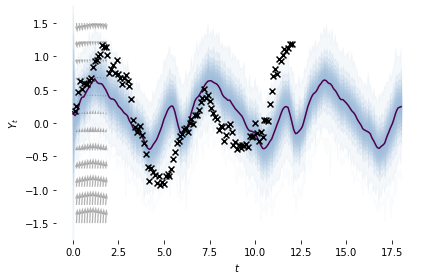

 80%|████████  | 400/500 [02:41<01:06,  1.50it/s]

tensor(985.6125, grad_fn=<MeanBackward0>)


 80%|████████  | 401/500 [02:41<00:57,  1.73it/s]

tensor(976.8896, grad_fn=<MeanBackward0>)


 80%|████████  | 402/500 [02:42<00:50,  1.93it/s]

tensor(983.5192, grad_fn=<MeanBackward0>)


 81%|████████  | 403/500 [02:42<00:46,  2.10it/s]

tensor(976.6562, grad_fn=<MeanBackward0>)


 81%|████████  | 404/500 [02:43<00:42,  2.25it/s]

tensor(978.8650, grad_fn=<MeanBackward0>)


 81%|████████  | 405/500 [02:43<00:40,  2.36it/s]

tensor(988.0898, grad_fn=<MeanBackward0>)
tensor(978.7150, grad_fn=<MeanBackward0>)


 81%|████████▏ | 407/500 [02:44<00:38,  2.40it/s]

tensor(979.1957, grad_fn=<MeanBackward0>)


 82%|████████▏ | 408/500 [02:44<00:36,  2.49it/s]

tensor(981.3040, grad_fn=<MeanBackward0>)


 82%|████████▏ | 409/500 [02:45<00:35,  2.55it/s]

tensor(979.0940, grad_fn=<MeanBackward0>)


 82%|████████▏ | 410/500 [02:45<00:34,  2.59it/s]

tensor(976.4532, grad_fn=<MeanBackward0>)


 82%|████████▏ | 411/500 [02:45<00:33,  2.63it/s]

tensor(976.0790, grad_fn=<MeanBackward0>)


 82%|████████▏ | 412/500 [02:46<00:33,  2.63it/s]

tensor(980.0306, grad_fn=<MeanBackward0>)


 83%|████████▎ | 413/500 [02:46<00:32,  2.66it/s]

tensor(978.7744, grad_fn=<MeanBackward0>)


 83%|████████▎ | 414/500 [02:46<00:32,  2.66it/s]

tensor(970.8375, grad_fn=<MeanBackward0>)


 83%|████████▎ | 415/500 [02:47<00:31,  2.67it/s]

tensor(979.3763, grad_fn=<MeanBackward0>)


 83%|████████▎ | 416/500 [02:47<00:31,  2.63it/s]

tensor(971.8395, grad_fn=<MeanBackward0>)


 83%|████████▎ | 417/500 [02:48<00:31,  2.66it/s]

tensor(979.5359, grad_fn=<MeanBackward0>)


 84%|████████▎ | 418/500 [02:48<00:30,  2.66it/s]

tensor(981.2678, grad_fn=<MeanBackward0>)


 84%|████████▍ | 419/500 [02:48<00:30,  2.69it/s]

tensor(976.1430, grad_fn=<MeanBackward0>)


 84%|████████▍ | 420/500 [02:49<00:30,  2.66it/s]

tensor(979.4008, grad_fn=<MeanBackward0>)


 84%|████████▍ | 421/500 [02:49<00:29,  2.67it/s]

tensor(976.6900, grad_fn=<MeanBackward0>)


 84%|████████▍ | 422/500 [02:49<00:29,  2.67it/s]

tensor(983.4545, grad_fn=<MeanBackward0>)


 85%|████████▍ | 423/500 [02:50<00:28,  2.69it/s]

tensor(979.5165, grad_fn=<MeanBackward0>)


 85%|████████▍ | 424/500 [02:50<00:28,  2.70it/s]

tensor(981.5215, grad_fn=<MeanBackward0>)


 85%|████████▌ | 425/500 [02:50<00:27,  2.71it/s]

tensor(977.3389, grad_fn=<MeanBackward0>)


 85%|████████▌ | 426/500 [02:51<00:27,  2.70it/s]

tensor(982.9663, grad_fn=<MeanBackward0>)


 85%|████████▌ | 427/500 [02:51<00:27,  2.70it/s]

tensor(982.2998, grad_fn=<MeanBackward0>)


 86%|████████▌ | 428/500 [02:52<00:26,  2.69it/s]

tensor(978.0711, grad_fn=<MeanBackward0>)


 86%|████████▌ | 429/500 [02:52<00:26,  2.71it/s]

tensor(981.4953, grad_fn=<MeanBackward0>)


 86%|████████▌ | 430/500 [02:52<00:25,  2.72it/s]

tensor(976.4749, grad_fn=<MeanBackward0>)


 86%|████████▌ | 431/500 [02:53<00:25,  2.71it/s]

tensor(984.3441, grad_fn=<MeanBackward0>)


 86%|████████▋ | 432/500 [02:53<00:24,  2.72it/s]

tensor(980.5924, grad_fn=<MeanBackward0>)


 87%|████████▋ | 433/500 [02:53<00:24,  2.73it/s]

tensor(979.6622, grad_fn=<MeanBackward0>)


 87%|████████▋ | 434/500 [02:54<00:24,  2.73it/s]

tensor(974.2636, grad_fn=<MeanBackward0>)


 87%|████████▋ | 435/500 [02:54<00:23,  2.74it/s]

tensor(980.5303, grad_fn=<MeanBackward0>)


 87%|████████▋ | 436/500 [02:55<00:23,  2.74it/s]

tensor(980.3682, grad_fn=<MeanBackward0>)


 87%|████████▋ | 437/500 [02:55<00:22,  2.75it/s]

tensor(973.6423, grad_fn=<MeanBackward0>)


 88%|████████▊ | 438/500 [02:55<00:22,  2.75it/s]

tensor(972.5814, grad_fn=<MeanBackward0>)


 88%|████████▊ | 439/500 [02:56<00:22,  2.75it/s]

tensor(986.3794, grad_fn=<MeanBackward0>)


 88%|████████▊ | 440/500 [02:56<00:21,  2.75it/s]

tensor(976.2330, grad_fn=<MeanBackward0>)


 88%|████████▊ | 441/500 [02:56<00:21,  2.69it/s]

tensor(979.9303, grad_fn=<MeanBackward0>)


 88%|████████▊ | 442/500 [02:57<00:21,  2.71it/s]

tensor(981.9222, grad_fn=<MeanBackward0>)


 89%|████████▊ | 443/500 [02:57<00:20,  2.72it/s]

tensor(974.2976, grad_fn=<MeanBackward0>)


 89%|████████▉ | 444/500 [02:57<00:20,  2.73it/s]

tensor(975.3537, grad_fn=<MeanBackward0>)


 89%|████████▉ | 445/500 [02:58<00:20,  2.74it/s]

tensor(977.0250, grad_fn=<MeanBackward0>)


 89%|████████▉ | 446/500 [02:58<00:19,  2.74it/s]

tensor(978.7002, grad_fn=<MeanBackward0>)


 89%|████████▉ | 447/500 [02:59<00:19,  2.74it/s]

tensor(983.8184, grad_fn=<MeanBackward0>)


 90%|████████▉ | 448/500 [02:59<00:18,  2.74it/s]

tensor(978.5158, grad_fn=<MeanBackward0>)


 90%|████████▉ | 449/500 [02:59<00:19,  2.68it/s]

tensor(980.1564, grad_fn=<MeanBackward0>)


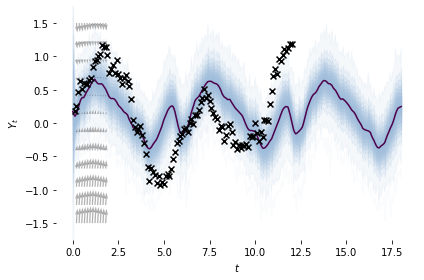

 90%|█████████ | 450/500 [03:01<00:35,  1.42it/s]

tensor(970.9833, grad_fn=<MeanBackward0>)


 90%|█████████ | 451/500 [03:01<00:30,  1.62it/s]

tensor(978.6642, grad_fn=<MeanBackward0>)


 90%|█████████ | 452/500 [03:02<00:26,  1.81it/s]

tensor(974.8046, grad_fn=<MeanBackward0>)


 91%|█████████ | 453/500 [03:02<00:23,  1.97it/s]

tensor(978.2148, grad_fn=<MeanBackward0>)


 91%|█████████ | 454/500 [03:02<00:22,  2.08it/s]

tensor(981.3096, grad_fn=<MeanBackward0>)


 91%|█████████ | 455/500 [03:03<00:20,  2.21it/s]

tensor(979.8507, grad_fn=<MeanBackward0>)


 91%|█████████ | 456/500 [03:03<00:19,  2.27it/s]

tensor(977.5687, grad_fn=<MeanBackward0>)
tensor(978.1073, grad_fn=<MeanBackward0>)


 92%|█████████▏| 458/500 [03:04<00:18,  2.31it/s]

tensor(979.9055, grad_fn=<MeanBackward0>)


 92%|█████████▏| 459/500 [03:04<00:17,  2.36it/s]

tensor(977.3533, grad_fn=<MeanBackward0>)


 92%|█████████▏| 460/500 [03:05<00:16,  2.38it/s]

tensor(973.5012, grad_fn=<MeanBackward0>)


 92%|█████████▏| 461/500 [03:05<00:16,  2.39it/s]

tensor(979.6090, grad_fn=<MeanBackward0>)


 92%|█████████▏| 462/500 [03:06<00:15,  2.41it/s]

tensor(981.4020, grad_fn=<MeanBackward0>)


 93%|█████████▎| 463/500 [03:06<00:15,  2.43it/s]

tensor(981.9835, grad_fn=<MeanBackward0>)


 93%|█████████▎| 464/500 [03:07<00:14,  2.46it/s]

tensor(980.6633, grad_fn=<MeanBackward0>)


 93%|█████████▎| 465/500 [03:07<00:13,  2.54it/s]

tensor(976.6093, grad_fn=<MeanBackward0>)


 93%|█████████▎| 466/500 [03:07<00:13,  2.58it/s]

tensor(983.5352, grad_fn=<MeanBackward0>)


 93%|█████████▎| 467/500 [03:08<00:12,  2.55it/s]

tensor(977.3668, grad_fn=<MeanBackward0>)


 94%|█████████▎| 468/500 [03:08<00:12,  2.59it/s]

tensor(976.8211, grad_fn=<MeanBackward0>)


 94%|█████████▍| 469/500 [03:08<00:11,  2.62it/s]

tensor(978.2972, grad_fn=<MeanBackward0>)


 94%|█████████▍| 470/500 [03:09<00:11,  2.65it/s]

tensor(977.1140, grad_fn=<MeanBackward0>)


 94%|█████████▍| 471/500 [03:09<00:10,  2.66it/s]

tensor(983.1439, grad_fn=<MeanBackward0>)


 94%|█████████▍| 472/500 [03:09<00:10,  2.68it/s]

tensor(976.5677, grad_fn=<MeanBackward0>)


 95%|█████████▍| 473/500 [03:10<00:10,  2.68it/s]

tensor(978.4635, grad_fn=<MeanBackward0>)


 95%|█████████▍| 474/500 [03:10<00:10,  2.56it/s]

tensor(971.2683, grad_fn=<MeanBackward0>)


 95%|█████████▌| 475/500 [03:11<00:09,  2.60it/s]

tensor(975.9716, grad_fn=<MeanBackward0>)


 95%|█████████▌| 476/500 [03:11<00:09,  2.64it/s]

tensor(980.8716, grad_fn=<MeanBackward0>)


 95%|█████████▌| 477/500 [03:11<00:08,  2.67it/s]

tensor(977.1015, grad_fn=<MeanBackward0>)


 96%|█████████▌| 478/500 [03:12<00:08,  2.68it/s]

tensor(980.1604, grad_fn=<MeanBackward0>)


 96%|█████████▌| 479/500 [03:12<00:07,  2.70it/s]

tensor(975.7235, grad_fn=<MeanBackward0>)


 96%|█████████▌| 480/500 [03:12<00:07,  2.72it/s]

tensor(985.9918, grad_fn=<MeanBackward0>)


 96%|█████████▌| 481/500 [03:13<00:06,  2.72it/s]

tensor(978.4921, grad_fn=<MeanBackward0>)


 96%|█████████▋| 482/500 [03:13<00:06,  2.74it/s]

tensor(978.6099, grad_fn=<MeanBackward0>)


 97%|█████████▋| 483/500 [03:14<00:06,  2.74it/s]

tensor(973.7454, grad_fn=<MeanBackward0>)


 97%|█████████▋| 484/500 [03:14<00:05,  2.75it/s]

tensor(979.7556, grad_fn=<MeanBackward0>)


 97%|█████████▋| 485/500 [03:14<00:05,  2.75it/s]

tensor(979.9750, grad_fn=<MeanBackward0>)


 97%|█████████▋| 486/500 [03:15<00:05,  2.75it/s]

tensor(975.9767, grad_fn=<MeanBackward0>)


 97%|█████████▋| 487/500 [03:15<00:04,  2.76it/s]

tensor(976.4860, grad_fn=<MeanBackward0>)


 98%|█████████▊| 488/500 [03:15<00:04,  2.75it/s]

tensor(980.9368, grad_fn=<MeanBackward0>)


 98%|█████████▊| 489/500 [03:16<00:03,  2.75it/s]

tensor(976.0942, grad_fn=<MeanBackward0>)


 98%|█████████▊| 490/500 [03:16<00:03,  2.75it/s]

tensor(978.3354, grad_fn=<MeanBackward0>)


 98%|█████████▊| 491/500 [03:16<00:03,  2.75it/s]

tensor(977.2128, grad_fn=<MeanBackward0>)


 98%|█████████▊| 492/500 [03:17<00:02,  2.75it/s]

tensor(981.8042, grad_fn=<MeanBackward0>)


 99%|█████████▊| 493/500 [03:17<00:02,  2.76it/s]

tensor(981.1386, grad_fn=<MeanBackward0>)


 99%|█████████▉| 494/500 [03:18<00:02,  2.75it/s]

tensor(980.2619, grad_fn=<MeanBackward0>)


 99%|█████████▉| 495/500 [03:18<00:01,  2.75it/s]

tensor(980.8466, grad_fn=<MeanBackward0>)


 99%|█████████▉| 496/500 [03:18<00:01,  2.75it/s]

tensor(977.1384, grad_fn=<MeanBackward0>)


 99%|█████████▉| 497/500 [03:19<00:01,  2.75it/s]

tensor(981.9048, grad_fn=<MeanBackward0>)


100%|█████████▉| 498/500 [03:19<00:00,  2.75it/s]

tensor(974.0199, grad_fn=<MeanBackward0>)


100%|█████████▉| 499/500 [03:19<00:00,  2.75it/s]

tensor(975.5296, grad_fn=<MeanBackward0>)


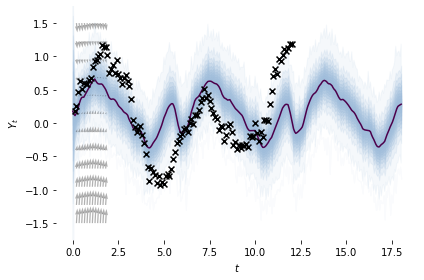

100%|██████████| 500/500 [03:21<00:00,  2.48it/s]

tensor(980.6266, grad_fn=<MeanBackward0>)


In [220]:
model_testing = LatentSDE_testing().to(device)
l2_logpy_list = main_1(model_testing)

In [224]:
def main_2(model):
    # Dataset.
    ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()
    llg = log_likelihood(1,ys)
    # Plotting parameters.
    vis_batch_size = 1024
    ylims = (-1.75, 1.75)
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = np.random.permutation(vis_batch_size)
    l2_only_list = []
    # From https://colorbrewer2.org/.
    if args.color == "blue":
        sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
        fill_color = '#9ebcda'
        mean_color = '#4d004b'
        num_samples = len(sample_colors)
    else:
        sample_colors = ('#fc4e2a', '#e31a1c', '#bd0026')
        fill_color = '#fd8d3c'
        mean_color = '#800026'
        num_samples = len(sample_colors)

    eps = torch.randn(vis_batch_size, 1).to(device)  # Fix seed for the random draws used in the plots.
    bm = torchsde.BrownianInterval(
        t0=ts_vis[0],
        t1=ts_vis[-1],
        size=(vis_batch_size, 1),
        device=device,
        levy_area_approximation='space-time'
    )  # We need space-time Levy area to use the SRK solver

    # Model.
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
    kl_scheduler = LinearScheduler(iters=args.kl_anneal_iters)
    criterion = nn.MSELoss()

    logpy_metric = EMAMetric()
    kl_metric = EMAMetric()
    loss_metric = EMAMetric()

    if args.show_prior:
        with torch.no_grad():
            zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
            ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
            zs_ = np.sort(zs_, axis=1)

            img_dir = os.path.join(args.train_dir, 'prior.png')
            plt.subplot(frameon=False)
            for alpha, percentile in zip(alphas, percentiles):
                idx = int((1 - percentile) / 2. * vis_batch_size)
                zs_bot_ = zs_[:, idx]
                zs_top_ = zs_[:, -idx]
                plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

            # `zorder` determines who's on top; the larger the more at the top.
            plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')
            plt.tight_layout()
            plt.savefig(img_dir, dpi=args.dpi)
            plt.show()
            plt.close()
            logging.info(f'Saved prior figure at: {img_dir}')

    for global_step in tqdm.tqdm(range(args.train_iters)):
        # Plot and save.
        if (global_step+1) % args.pause_iters == 0:
            img_path = os.path.join(args.train_dir, f'global_step_{global_step+1}.png')

            with torch.no_grad():
                zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
                samples = zs[:, vis_idx]
                ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
                zs_ = np.sort(zs_, axis=1)
                plt.subplot(frameon=False)

                if args.show_percentiles:
                    for alpha, percentile in zip(alphas, percentiles):
                        idx = int((1 - percentile) / 2. * vis_batch_size)
                        zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
                        plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

                if args.show_mean:
                    plt.plot(ts_vis_, zs_.mean(axis=1), color=mean_color)

                if args.show_samples:
                    for j in range(num_samples):
                        plt.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=1.0)

                if args.show_arrows:
                    num, dt = 12, 0.12
                    t, y = torch.meshgrid(
                        [torch.linspace(0.2, 1.8, num).to(device), torch.linspace(-1.5, 1.5, num).to(device)]
                    )
                    t, y = t.reshape(-1, 1), y.reshape(-1, 1)
                    fty = model.f(t=t, y=y).reshape(num, num)
                    dt = torch.zeros(num, num).fill_(dt).to(device)
                    dy = fty * dt
                    dt_, dy_, t_, y_ = dt.cpu().numpy(), dy.cpu().numpy(), t.cpu().numpy(), y.cpu().numpy()
                    plt.quiver(t_, y_, dt_, dy_, alpha=0.3, edgecolors='k', width=0.0035, scale=50)

                if args.hide_ticks:
                    plt.xticks([], [])
                    plt.yticks([], [])

                plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
                plt.ylim(ylims)
                plt.xlabel('$t$')
                plt.ylabel('$Y_t$')
                plt.tight_layout()
                plt.savefig(img_path, dpi=args.dpi)
                plt.show()
                plt.close()
                logging.info(f'Saved figure at: {img_path}')

                if args.save_ckpt:
                    torch.save(
                        {'model': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'kl_scheduler': kl_scheduler},
                        os.path.join(ckpt_dir, f'global_step_{global_step}.ckpt')
                    )

        # Train.
        optimizer.zero_grad()
        zs, kl = model(ts=ts_ext, batch_size=args.batch_size)
        zs = zs.squeeze()
        zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.

        likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
        likelihood = likelihood_constructor(loc=zs, scale=args.scale)
        logpy = likelihood.log_prob(ys).sum(dim=0).mean(dim=0)
        l2_only_list.append(logpy.item())
        #llg = log_likelihood(1,zs.permute([1,0]).squeeze(),120).mean()
        llg_loss = torch.sqrt((likelihood.log_prob(ys).sum(dim=0)-llg)**2).mean()
        print(llg_loss)
        #print(likelihood.log_prob(ys).mean(dim=1).shape)
        loss = kl* kl_scheduler.val + llg_loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

        logpy_metric.step(logpy)
        kl_metric.step(kl)
        loss_metric.step(loss)

        logging.info(
            f'global_step: {global_step}, '
            f'logpy: {logpy_metric.val:.3f}, '
            f'kl: {kl_metric.val:.3f}, '
            f'llg_loss: {llg_loss:.3f}, '
            f'loss: {loss_metric.val:.3f}'
        )
    return l2_only_list

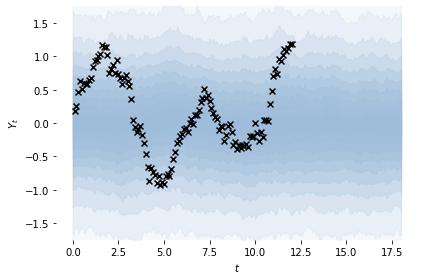

  0%|          | 0/500 [00:00<?, ?it/s]

tensor(4834.3682, grad_fn=<MeanBackward0>)


  0%|          | 1/500 [00:00<03:53,  2.14it/s]

tensor(3752.8564, grad_fn=<MeanBackward0>)


  1%|          | 3/500 [00:01<03:41,  2.24it/s]

tensor(1861.9055, grad_fn=<MeanBackward0>)


  1%|          | 4/500 [00:01<03:31,  2.34it/s]

tensor(1360.8547, grad_fn=<MeanBackward0>)


  1%|          | 5/500 [00:02<03:24,  2.42it/s]

tensor(1138.5597, grad_fn=<MeanBackward0>)


  1%|          | 6/500 [00:02<03:23,  2.43it/s]

tensor(1063.5026, grad_fn=<MeanBackward0>)


  1%|▏         | 7/500 [00:02<03:20,  2.46it/s]

tensor(1019.6647, grad_fn=<MeanBackward0>)


  2%|▏         | 8/500 [00:03<03:19,  2.47it/s]

tensor(1005.2410, grad_fn=<MeanBackward0>)


  2%|▏         | 9/500 [00:03<03:15,  2.52it/s]

tensor(1003.4965, grad_fn=<MeanBackward0>)


  2%|▏         | 10/500 [00:04<03:09,  2.58it/s]

tensor(1024.1721, grad_fn=<MeanBackward0>)


  2%|▏         | 11/500 [00:04<03:07,  2.61it/s]

tensor(1061.3940, grad_fn=<MeanBackward0>)


  2%|▏         | 12/500 [00:04<03:08,  2.59it/s]

tensor(1096.9612, grad_fn=<MeanBackward0>)


  3%|▎         | 13/500 [00:05<03:06,  2.61it/s]

tensor(1121.8601, grad_fn=<MeanBackward0>)


  3%|▎         | 14/500 [00:05<03:05,  2.62it/s]

tensor(1106.6376, grad_fn=<MeanBackward0>)


  3%|▎         | 15/500 [00:05<03:03,  2.65it/s]

tensor(1072.6007, grad_fn=<MeanBackward0>)


  3%|▎         | 16/500 [00:06<03:00,  2.68it/s]

tensor(1055.6752, grad_fn=<MeanBackward0>)


  3%|▎         | 17/500 [00:06<02:59,  2.69it/s]

tensor(1043.0931, grad_fn=<MeanBackward0>)


  4%|▎         | 18/500 [00:07<03:00,  2.67it/s]

tensor(1020.5970, grad_fn=<MeanBackward0>)


  4%|▍         | 19/500 [00:07<03:30,  2.29it/s]

tensor(1006.7878, grad_fn=<MeanBackward0>)
tensor(992.8082, grad_fn=<MeanBackward0>)


  4%|▍         | 21/500 [00:08<03:25,  2.33it/s]

tensor(997.0876, grad_fn=<MeanBackward0>)


  4%|▍         | 22/500 [00:08<03:18,  2.41it/s]

tensor(996.4306, grad_fn=<MeanBackward0>)


  5%|▍         | 23/500 [00:09<03:10,  2.51it/s]

tensor(992.3749, grad_fn=<MeanBackward0>)


  5%|▍         | 24/500 [00:09<03:04,  2.58it/s]

tensor(990.3934, grad_fn=<MeanBackward0>)


  5%|▌         | 25/500 [00:09<03:00,  2.63it/s]

tensor(997.1216, grad_fn=<MeanBackward0>)


  5%|▌         | 26/500 [00:10<03:05,  2.55it/s]

tensor(1008.9598, grad_fn=<MeanBackward0>)


  5%|▌         | 27/500 [00:10<03:02,  2.59it/s]

tensor(1005.1420, grad_fn=<MeanBackward0>)


  6%|▌         | 28/500 [00:11<03:02,  2.59it/s]

tensor(1004.9258, grad_fn=<MeanBackward0>)


  6%|▌         | 29/500 [00:11<03:02,  2.59it/s]

tensor(1007.4514, grad_fn=<MeanBackward0>)


  6%|▌         | 30/500 [00:11<03:00,  2.60it/s]

tensor(1005.1565, grad_fn=<MeanBackward0>)
tensor(1005.6768, grad_fn=<MeanBackward0>)


  6%|▌         | 31/500 [00:12<03:22,  2.32it/s]

tensor(1003.0707, grad_fn=<MeanBackward0>)


  6%|▋         | 32/500 [00:12<03:34,  2.18it/s]

tensor(1001.9499, grad_fn=<MeanBackward0>)


  7%|▋         | 34/500 [00:14<03:57,  1.97it/s]

tensor(995.2632, grad_fn=<MeanBackward0>)


  7%|▋         | 35/500 [00:14<03:42,  2.09it/s]

tensor(999.3340, grad_fn=<MeanBackward0>)
tensor(996.7592, grad_fn=<MeanBackward0>)


  7%|▋         | 37/500 [00:15<03:24,  2.26it/s]

tensor(990.3682, grad_fn=<MeanBackward0>)
tensor(997.7993, grad_fn=<MeanBackward0>)


  8%|▊         | 39/500 [00:16<03:11,  2.41it/s]

tensor(994.5204, grad_fn=<MeanBackward0>)


  8%|▊         | 40/500 [00:16<03:05,  2.48it/s]

tensor(989.5740, grad_fn=<MeanBackward0>)


  8%|▊         | 41/500 [00:16<03:00,  2.54it/s]

tensor(989.5821, grad_fn=<MeanBackward0>)


  8%|▊         | 42/500 [00:17<02:56,  2.60it/s]

tensor(986.8127, grad_fn=<MeanBackward0>)


  9%|▊         | 43/500 [00:17<03:04,  2.47it/s]

tensor(989.8830, grad_fn=<MeanBackward0>)


  9%|▉         | 44/500 [00:18<02:59,  2.54it/s]

tensor(988.6536, grad_fn=<MeanBackward0>)


  9%|▉         | 45/500 [00:18<02:55,  2.60it/s]

tensor(984.6788, grad_fn=<MeanBackward0>)


  9%|▉         | 46/500 [00:18<02:52,  2.63it/s]

tensor(985.4266, grad_fn=<MeanBackward0>)


  9%|▉         | 47/500 [00:19<02:50,  2.65it/s]

tensor(983.8164, grad_fn=<MeanBackward0>)


 10%|▉         | 48/500 [00:19<02:47,  2.69it/s]

tensor(982.7773, grad_fn=<MeanBackward0>)


 10%|▉         | 49/500 [00:19<02:45,  2.72it/s]

tensor(987.3337, grad_fn=<MeanBackward0>)


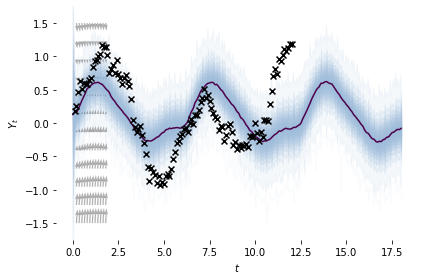

 10%|█         | 50/500 [00:21<05:03,  1.48it/s]

tensor(985.4344, grad_fn=<MeanBackward0>)


 10%|█         | 51/500 [00:21<04:21,  1.72it/s]

tensor(979.1724, grad_fn=<MeanBackward0>)


 10%|█         | 52/500 [00:22<03:52,  1.93it/s]

tensor(982.8052, grad_fn=<MeanBackward0>)


 11%|█         | 53/500 [00:22<03:34,  2.08it/s]

tensor(983.2263, grad_fn=<MeanBackward0>)


 11%|█         | 54/500 [00:22<03:19,  2.24it/s]

tensor(985.4957, grad_fn=<MeanBackward0>)


 11%|█         | 55/500 [00:23<03:11,  2.33it/s]

tensor(983.9697, grad_fn=<MeanBackward0>)


 11%|█         | 56/500 [00:23<03:06,  2.38it/s]

tensor(985.0164, grad_fn=<MeanBackward0>)


 11%|█▏        | 57/500 [00:23<02:58,  2.48it/s]

tensor(981.9391, grad_fn=<MeanBackward0>)


 12%|█▏        | 58/500 [00:24<02:56,  2.51it/s]

tensor(988.1919, grad_fn=<MeanBackward0>)


 12%|█▏        | 59/500 [00:24<02:51,  2.57it/s]

tensor(983.4226, grad_fn=<MeanBackward0>)


 12%|█▏        | 60/500 [00:25<02:48,  2.61it/s]

tensor(983.7808, grad_fn=<MeanBackward0>)


 12%|█▏        | 61/500 [00:25<02:50,  2.58it/s]

tensor(986.3970, grad_fn=<MeanBackward0>)


 12%|█▏        | 62/500 [00:25<02:46,  2.63it/s]

tensor(987.4059, grad_fn=<MeanBackward0>)


 13%|█▎        | 63/500 [00:26<02:43,  2.67it/s]

tensor(987.5762, grad_fn=<MeanBackward0>)


 13%|█▎        | 64/500 [00:26<02:41,  2.71it/s]

tensor(986.8778, grad_fn=<MeanBackward0>)


 13%|█▎        | 65/500 [00:26<02:39,  2.73it/s]

tensor(989.6837, grad_fn=<MeanBackward0>)
tensor(991.1584, grad_fn=<MeanBackward0>)


 13%|█▎        | 67/500 [00:27<02:44,  2.64it/s]

tensor(988.3787, grad_fn=<MeanBackward0>)


 14%|█▎        | 68/500 [00:28<02:46,  2.59it/s]

tensor(984.7021, grad_fn=<MeanBackward0>)


 14%|█▍        | 69/500 [00:28<02:47,  2.57it/s]

tensor(980.6437, grad_fn=<MeanBackward0>)
tensor(992.3768, grad_fn=<MeanBackward0>)


 14%|█▍        | 71/500 [00:29<02:50,  2.51it/s]

tensor(982.1265, grad_fn=<MeanBackward0>)


 14%|█▍        | 72/500 [00:29<02:46,  2.57it/s]

tensor(987.9714, grad_fn=<MeanBackward0>)


 15%|█▍        | 73/500 [00:30<02:44,  2.60it/s]

tensor(986.3782, grad_fn=<MeanBackward0>)


 15%|█▍        | 74/500 [00:30<02:45,  2.57it/s]

tensor(984.1107, grad_fn=<MeanBackward0>)


 15%|█▌        | 75/500 [00:30<02:47,  2.54it/s]

tensor(987.9739, grad_fn=<MeanBackward0>)


 15%|█▌        | 76/500 [00:31<02:45,  2.55it/s]

tensor(986.1773, grad_fn=<MeanBackward0>)


 15%|█▌        | 77/500 [00:31<02:42,  2.60it/s]

tensor(990.0496, grad_fn=<MeanBackward0>)


 16%|█▌        | 78/500 [00:31<02:39,  2.65it/s]

tensor(984.0165, grad_fn=<MeanBackward0>)


 16%|█▌        | 79/500 [00:32<02:37,  2.68it/s]

tensor(987.7383, grad_fn=<MeanBackward0>)


 16%|█▌        | 80/500 [00:32<02:41,  2.61it/s]

tensor(988.8991, grad_fn=<MeanBackward0>)


 16%|█▌        | 81/500 [00:33<02:38,  2.64it/s]

tensor(985.6284, grad_fn=<MeanBackward0>)


 16%|█▋        | 82/500 [00:33<02:37,  2.66it/s]

tensor(986.2733, grad_fn=<MeanBackward0>)


 17%|█▋        | 83/500 [00:33<02:34,  2.70it/s]

tensor(989.9671, grad_fn=<MeanBackward0>)


 17%|█▋        | 84/500 [00:34<02:32,  2.72it/s]

tensor(982.7863, grad_fn=<MeanBackward0>)


 17%|█▋        | 85/500 [00:34<02:31,  2.74it/s]

tensor(984.8039, grad_fn=<MeanBackward0>)


 17%|█▋        | 86/500 [00:34<02:30,  2.75it/s]

tensor(986.8513, grad_fn=<MeanBackward0>)


 17%|█▋        | 87/500 [00:35<02:29,  2.76it/s]

tensor(984.2902, grad_fn=<MeanBackward0>)


 18%|█▊        | 88/500 [00:35<02:32,  2.71it/s]

tensor(981.3259, grad_fn=<MeanBackward0>)


 18%|█▊        | 89/500 [00:35<02:30,  2.73it/s]

tensor(989.7139, grad_fn=<MeanBackward0>)


 18%|█▊        | 90/500 [00:36<02:31,  2.70it/s]

tensor(981.8854, grad_fn=<MeanBackward0>)


 18%|█▊        | 91/500 [00:36<02:29,  2.73it/s]

tensor(989.3881, grad_fn=<MeanBackward0>)


 18%|█▊        | 92/500 [00:37<02:28,  2.75it/s]

tensor(988.8193, grad_fn=<MeanBackward0>)


 19%|█▊        | 93/500 [00:37<02:26,  2.77it/s]

tensor(985.0120, grad_fn=<MeanBackward0>)


 19%|█▉        | 94/500 [00:37<02:26,  2.77it/s]

tensor(988.8969, grad_fn=<MeanBackward0>)


 19%|█▉        | 95/500 [00:38<02:25,  2.78it/s]

tensor(985.4529, grad_fn=<MeanBackward0>)


 19%|█▉        | 96/500 [00:38<02:24,  2.79it/s]

tensor(988.6952, grad_fn=<MeanBackward0>)


 19%|█▉        | 97/500 [00:38<02:24,  2.79it/s]

tensor(984.9736, grad_fn=<MeanBackward0>)


 20%|█▉        | 98/500 [00:39<02:23,  2.80it/s]

tensor(990.7282, grad_fn=<MeanBackward0>)


 20%|█▉        | 99/500 [00:39<02:23,  2.80it/s]

tensor(987.9173, grad_fn=<MeanBackward0>)


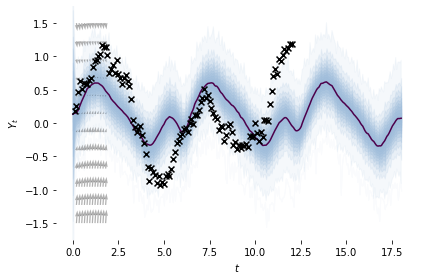

 20%|██        | 100/500 [00:40<04:26,  1.50it/s]

tensor(991.4469, grad_fn=<MeanBackward0>)
tensor(985.6527, grad_fn=<MeanBackward0>)


 20%|██        | 102/500 [00:41<03:30,  1.89it/s]

tensor(988.9670, grad_fn=<MeanBackward0>)


 21%|██        | 103/500 [00:42<03:12,  2.06it/s]

tensor(984.3531, grad_fn=<MeanBackward0>)


 21%|██        | 104/500 [00:42<03:01,  2.18it/s]

tensor(986.2084, grad_fn=<MeanBackward0>)
tensor(992.9906, grad_fn=<MeanBackward0>)


 21%|██        | 106/500 [00:43<02:53,  2.28it/s]

tensor(987.8560, grad_fn=<MeanBackward0>)


 21%|██▏       | 107/500 [00:43<02:44,  2.40it/s]

tensor(991.4080, grad_fn=<MeanBackward0>)


 22%|██▏       | 108/500 [00:44<02:36,  2.50it/s]

tensor(986.1300, grad_fn=<MeanBackward0>)


 22%|██▏       | 109/500 [00:44<02:32,  2.56it/s]

tensor(990.5017, grad_fn=<MeanBackward0>)


 22%|██▏       | 110/500 [00:44<02:31,  2.58it/s]

tensor(987.5815, grad_fn=<MeanBackward0>)


 22%|██▏       | 111/500 [00:45<02:28,  2.62it/s]

tensor(993.8491, grad_fn=<MeanBackward0>)


 22%|██▏       | 112/500 [00:45<02:25,  2.67it/s]

tensor(995.0601, grad_fn=<MeanBackward0>)


 23%|██▎       | 113/500 [00:45<02:22,  2.71it/s]

tensor(987.8644, grad_fn=<MeanBackward0>)


 23%|██▎       | 114/500 [00:46<02:20,  2.74it/s]

tensor(987.9401, grad_fn=<MeanBackward0>)


 23%|██▎       | 115/500 [00:46<02:21,  2.72it/s]

tensor(989.5675, grad_fn=<MeanBackward0>)


 23%|██▎       | 116/500 [00:47<02:20,  2.74it/s]

tensor(989.5720, grad_fn=<MeanBackward0>)


 23%|██▎       | 117/500 [00:47<02:19,  2.75it/s]

tensor(986.9525, grad_fn=<MeanBackward0>)


 24%|██▎       | 118/500 [00:47<02:18,  2.77it/s]

tensor(986.2375, grad_fn=<MeanBackward0>)


 24%|██▍       | 119/500 [00:48<02:18,  2.76it/s]

tensor(990.0182, grad_fn=<MeanBackward0>)


 24%|██▍       | 120/500 [00:48<02:17,  2.77it/s]

tensor(984.2366, grad_fn=<MeanBackward0>)


 24%|██▍       | 121/500 [00:48<02:16,  2.78it/s]

tensor(988.0841, grad_fn=<MeanBackward0>)


 24%|██▍       | 122/500 [00:49<02:15,  2.79it/s]

tensor(990.2973, grad_fn=<MeanBackward0>)


 25%|██▍       | 123/500 [00:49<02:15,  2.79it/s]

tensor(988.3608, grad_fn=<MeanBackward0>)


 25%|██▍       | 124/500 [00:49<02:14,  2.80it/s]

tensor(988.4573, grad_fn=<MeanBackward0>)


 25%|██▌       | 125/500 [00:50<02:13,  2.81it/s]

tensor(992.4100, grad_fn=<MeanBackward0>)


 25%|██▌       | 126/500 [00:50<02:13,  2.81it/s]

tensor(984.1756, grad_fn=<MeanBackward0>)


 25%|██▌       | 127/500 [00:50<02:12,  2.81it/s]

tensor(991.8541, grad_fn=<MeanBackward0>)


 26%|██▌       | 128/500 [00:51<02:12,  2.81it/s]

tensor(989.5089, grad_fn=<MeanBackward0>)


 26%|██▌       | 129/500 [00:51<02:12,  2.81it/s]

tensor(983.0757, grad_fn=<MeanBackward0>)


 26%|██▌       | 130/500 [00:52<02:11,  2.81it/s]

tensor(987.2737, grad_fn=<MeanBackward0>)


 26%|██▌       | 131/500 [00:52<02:11,  2.80it/s]

tensor(989.4084, grad_fn=<MeanBackward0>)


 26%|██▋       | 132/500 [00:52<02:11,  2.79it/s]

tensor(985.0457, grad_fn=<MeanBackward0>)


 27%|██▋       | 133/500 [00:53<02:11,  2.78it/s]

tensor(989.7366, grad_fn=<MeanBackward0>)


 27%|██▋       | 134/500 [00:53<02:11,  2.78it/s]

tensor(987.4690, grad_fn=<MeanBackward0>)


 27%|██▋       | 135/500 [00:53<02:11,  2.77it/s]

tensor(988.7077, grad_fn=<MeanBackward0>)


 27%|██▋       | 136/500 [00:54<02:11,  2.78it/s]

tensor(994.6282, grad_fn=<MeanBackward0>)


 27%|██▋       | 137/500 [00:54<02:11,  2.77it/s]

tensor(985.6638, grad_fn=<MeanBackward0>)


 28%|██▊       | 138/500 [00:54<02:10,  2.77it/s]

tensor(987.8333, grad_fn=<MeanBackward0>)


 28%|██▊       | 139/500 [00:55<02:09,  2.78it/s]

tensor(985.4470, grad_fn=<MeanBackward0>)


 28%|██▊       | 140/500 [00:55<02:09,  2.78it/s]

tensor(985.9861, grad_fn=<MeanBackward0>)


 28%|██▊       | 141/500 [00:56<02:08,  2.79it/s]

tensor(993.1790, grad_fn=<MeanBackward0>)


 28%|██▊       | 142/500 [00:56<02:08,  2.79it/s]

tensor(979.5775, grad_fn=<MeanBackward0>)


 29%|██▊       | 143/500 [00:56<02:07,  2.79it/s]

tensor(986.0036, grad_fn=<MeanBackward0>)


 29%|██▉       | 144/500 [00:57<02:07,  2.80it/s]

tensor(988.6450, grad_fn=<MeanBackward0>)


 29%|██▉       | 145/500 [00:57<02:09,  2.74it/s]

tensor(983.8331, grad_fn=<MeanBackward0>)


 29%|██▉       | 146/500 [00:57<02:11,  2.70it/s]

tensor(980.8035, grad_fn=<MeanBackward0>)


 29%|██▉       | 147/500 [00:58<02:11,  2.68it/s]

tensor(984.6257, grad_fn=<MeanBackward0>)


 30%|██▉       | 148/500 [00:58<02:11,  2.68it/s]

tensor(986.9490, grad_fn=<MeanBackward0>)


 30%|██▉       | 149/500 [00:58<02:11,  2.66it/s]

tensor(987.7611, grad_fn=<MeanBackward0>)


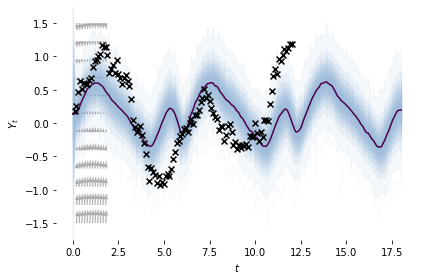

 30%|███       | 150/500 [01:00<04:12,  1.38it/s]

tensor(993.3968, grad_fn=<MeanBackward0>)


 30%|███       | 151/500 [01:00<03:37,  1.60it/s]

tensor(994.4857, grad_fn=<MeanBackward0>)


 30%|███       | 152/500 [01:01<03:14,  1.79it/s]

tensor(984.7216, grad_fn=<MeanBackward0>)


 31%|███       | 153/500 [01:01<02:58,  1.94it/s]

tensor(986.8480, grad_fn=<MeanBackward0>)


 31%|███       | 154/500 [01:02<02:46,  2.08it/s]

tensor(995.9161, grad_fn=<MeanBackward0>)


 31%|███       | 155/500 [01:02<02:37,  2.18it/s]

tensor(982.6429, grad_fn=<MeanBackward0>)
tensor(982.9672, grad_fn=<MeanBackward0>)


 31%|███       | 156/500 [01:02<02:34,  2.23it/s]

tensor(984.6261, grad_fn=<MeanBackward0>)


 32%|███▏      | 158/500 [01:03<02:25,  2.35it/s]

tensor(982.7349, grad_fn=<MeanBackward0>)


 32%|███▏      | 159/500 [01:04<02:23,  2.38it/s]

tensor(982.7632, grad_fn=<MeanBackward0>)


 32%|███▏      | 160/500 [01:04<02:21,  2.40it/s]

tensor(988.1436, grad_fn=<MeanBackward0>)


 32%|███▏      | 161/500 [01:04<02:18,  2.45it/s]

tensor(984.0780, grad_fn=<MeanBackward0>)


 32%|███▏      | 162/500 [01:05<02:20,  2.41it/s]

tensor(987.8111, grad_fn=<MeanBackward0>)


 33%|███▎      | 163/500 [01:05<02:14,  2.51it/s]

tensor(987.1021, grad_fn=<MeanBackward0>)


 33%|███▎      | 164/500 [01:06<02:09,  2.59it/s]

tensor(983.8782, grad_fn=<MeanBackward0>)


 33%|███▎      | 165/500 [01:06<02:06,  2.64it/s]

tensor(991.2707, grad_fn=<MeanBackward0>)


 33%|███▎      | 166/500 [01:06<02:05,  2.67it/s]

tensor(983.0789, grad_fn=<MeanBackward0>)


 33%|███▎      | 167/500 [01:07<02:03,  2.70it/s]

tensor(984.0154, grad_fn=<MeanBackward0>)


 34%|███▎      | 168/500 [01:07<02:02,  2.72it/s]

tensor(983.9602, grad_fn=<MeanBackward0>)


 34%|███▍      | 169/500 [01:07<02:01,  2.74it/s]

tensor(983.6932, grad_fn=<MeanBackward0>)


 34%|███▍      | 170/500 [01:08<02:00,  2.75it/s]

tensor(985.1069, grad_fn=<MeanBackward0>)


 34%|███▍      | 171/500 [01:08<01:59,  2.76it/s]

tensor(980.4544, grad_fn=<MeanBackward0>)


 34%|███▍      | 172/500 [01:09<01:58,  2.77it/s]

tensor(989.5774, grad_fn=<MeanBackward0>)


 35%|███▍      | 173/500 [01:09<01:58,  2.77it/s]

tensor(988.4419, grad_fn=<MeanBackward0>)


 35%|███▍      | 174/500 [01:09<01:57,  2.77it/s]

tensor(984.5162, grad_fn=<MeanBackward0>)


 35%|███▌      | 175/500 [01:10<01:57,  2.77it/s]

tensor(989.2277, grad_fn=<MeanBackward0>)


 35%|███▌      | 176/500 [01:10<01:57,  2.76it/s]

tensor(986.8601, grad_fn=<MeanBackward0>)


 35%|███▌      | 177/500 [01:10<01:56,  2.77it/s]

tensor(992.3319, grad_fn=<MeanBackward0>)


 36%|███▌      | 178/500 [01:11<01:56,  2.77it/s]

tensor(985.6044, grad_fn=<MeanBackward0>)


 36%|███▌      | 179/500 [01:11<01:55,  2.78it/s]

tensor(985.2318, grad_fn=<MeanBackward0>)


 36%|███▌      | 180/500 [01:11<01:55,  2.78it/s]

tensor(979.7109, grad_fn=<MeanBackward0>)


 36%|███▌      | 181/500 [01:12<01:54,  2.78it/s]

tensor(991.5502, grad_fn=<MeanBackward0>)


 36%|███▋      | 182/500 [01:12<01:54,  2.78it/s]

tensor(982.4425, grad_fn=<MeanBackward0>)


 37%|███▋      | 183/500 [01:12<01:53,  2.79it/s]

tensor(988.6284, grad_fn=<MeanBackward0>)


 37%|███▋      | 184/500 [01:13<01:55,  2.73it/s]

tensor(994.0867, grad_fn=<MeanBackward0>)


 37%|███▋      | 185/500 [01:13<01:56,  2.71it/s]

tensor(983.4122, grad_fn=<MeanBackward0>)


 37%|███▋      | 186/500 [01:14<01:55,  2.73it/s]

tensor(987.8510, grad_fn=<MeanBackward0>)


 37%|███▋      | 187/500 [01:14<01:54,  2.74it/s]

tensor(977.3503, grad_fn=<MeanBackward0>)


 38%|███▊      | 188/500 [01:14<01:53,  2.76it/s]

tensor(983.8478, grad_fn=<MeanBackward0>)


 38%|███▊      | 189/500 [01:15<01:52,  2.76it/s]

tensor(986.6143, grad_fn=<MeanBackward0>)


 38%|███▊      | 190/500 [01:15<01:51,  2.78it/s]

tensor(990.9528, grad_fn=<MeanBackward0>)


 38%|███▊      | 191/500 [01:15<01:51,  2.78it/s]

tensor(990.5064, grad_fn=<MeanBackward0>)


 38%|███▊      | 192/500 [01:16<01:50,  2.78it/s]

tensor(990.1025, grad_fn=<MeanBackward0>)


 39%|███▊      | 193/500 [01:16<01:50,  2.79it/s]

tensor(989.1835, grad_fn=<MeanBackward0>)


 39%|███▉      | 194/500 [01:16<01:49,  2.79it/s]

tensor(984.0115, grad_fn=<MeanBackward0>)


 39%|███▉      | 195/500 [01:17<01:49,  2.79it/s]

tensor(988.3629, grad_fn=<MeanBackward0>)


 39%|███▉      | 196/500 [01:17<01:48,  2.79it/s]

tensor(984.5950, grad_fn=<MeanBackward0>)


 39%|███▉      | 197/500 [01:18<01:48,  2.79it/s]

tensor(993.3100, grad_fn=<MeanBackward0>)


 40%|███▉      | 198/500 [01:18<01:48,  2.79it/s]

tensor(980.9429, grad_fn=<MeanBackward0>)


 40%|███▉      | 199/500 [01:18<01:47,  2.79it/s]

tensor(990.0714, grad_fn=<MeanBackward0>)


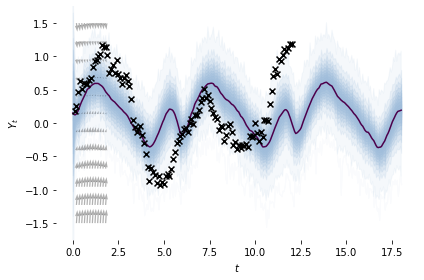

 40%|████      | 200/500 [01:20<03:20,  1.50it/s]

tensor(982.8552, grad_fn=<MeanBackward0>)


 40%|████      | 201/500 [01:20<02:54,  1.72it/s]

tensor(983.8604, grad_fn=<MeanBackward0>)


 40%|████      | 202/500 [01:20<02:35,  1.91it/s]

tensor(984.8843, grad_fn=<MeanBackward0>)


 41%|████      | 203/500 [01:21<02:22,  2.08it/s]

tensor(983.3739, grad_fn=<MeanBackward0>)


 41%|████      | 204/500 [01:21<02:12,  2.24it/s]

tensor(992.0582, grad_fn=<MeanBackward0>)


 41%|████      | 205/500 [01:22<02:06,  2.32it/s]

tensor(988.1384, grad_fn=<MeanBackward0>)


 41%|████      | 206/500 [01:22<02:01,  2.41it/s]

tensor(991.5600, grad_fn=<MeanBackward0>)


 41%|████▏     | 207/500 [01:22<01:58,  2.47it/s]

tensor(988.3378, grad_fn=<MeanBackward0>)


 42%|████▏     | 208/500 [01:23<01:54,  2.55it/s]

tensor(984.5619, grad_fn=<MeanBackward0>)


 42%|████▏     | 209/500 [01:23<01:51,  2.61it/s]

tensor(982.9573, grad_fn=<MeanBackward0>)


 42%|████▏     | 210/500 [01:23<01:49,  2.65it/s]

tensor(982.9862, grad_fn=<MeanBackward0>)


 42%|████▏     | 211/500 [01:24<01:48,  2.67it/s]

tensor(982.9041, grad_fn=<MeanBackward0>)


 42%|████▏     | 212/500 [01:24<01:47,  2.67it/s]

tensor(984.8376, grad_fn=<MeanBackward0>)


 43%|████▎     | 213/500 [01:24<01:45,  2.72it/s]

tensor(984.0356, grad_fn=<MeanBackward0>)


 43%|████▎     | 214/500 [01:25<01:44,  2.75it/s]

tensor(981.9304, grad_fn=<MeanBackward0>)


 43%|████▎     | 215/500 [01:25<01:43,  2.76it/s]

tensor(985.1373, grad_fn=<MeanBackward0>)


 43%|████▎     | 216/500 [01:26<01:42,  2.78it/s]

tensor(991.5089, grad_fn=<MeanBackward0>)


 43%|████▎     | 217/500 [01:26<01:41,  2.78it/s]

tensor(984.0660, grad_fn=<MeanBackward0>)


 44%|████▎     | 218/500 [01:26<01:40,  2.79it/s]

tensor(981.1074, grad_fn=<MeanBackward0>)


 44%|████▍     | 219/500 [01:27<01:40,  2.79it/s]

tensor(987.5527, grad_fn=<MeanBackward0>)


 44%|████▍     | 220/500 [01:27<01:39,  2.80it/s]

tensor(992.1331, grad_fn=<MeanBackward0>)


 44%|████▍     | 221/500 [01:27<01:39,  2.81it/s]

tensor(984.6993, grad_fn=<MeanBackward0>)


 44%|████▍     | 222/500 [01:28<01:38,  2.81it/s]

tensor(988.8618, grad_fn=<MeanBackward0>)


 45%|████▍     | 223/500 [01:28<01:38,  2.81it/s]

tensor(979.1182, grad_fn=<MeanBackward0>)


 45%|████▍     | 224/500 [01:28<01:38,  2.81it/s]

tensor(983.1821, grad_fn=<MeanBackward0>)


 45%|████▌     | 225/500 [01:29<01:37,  2.82it/s]

tensor(987.5192, grad_fn=<MeanBackward0>)


 45%|████▌     | 226/500 [01:29<01:37,  2.81it/s]

tensor(988.1062, grad_fn=<MeanBackward0>)


 45%|████▌     | 227/500 [01:29<01:36,  2.82it/s]

tensor(982.9308, grad_fn=<MeanBackward0>)


 46%|████▌     | 228/500 [01:30<01:36,  2.82it/s]

tensor(984.8983, grad_fn=<MeanBackward0>)


 46%|████▌     | 229/500 [01:30<01:36,  2.82it/s]

tensor(989.7198, grad_fn=<MeanBackward0>)


 46%|████▌     | 230/500 [01:31<01:35,  2.82it/s]

tensor(985.2059, grad_fn=<MeanBackward0>)


 46%|████▌     | 231/500 [01:31<01:35,  2.81it/s]

tensor(986.2020, grad_fn=<MeanBackward0>)


 46%|████▋     | 232/500 [01:31<01:35,  2.81it/s]

tensor(982.7253, grad_fn=<MeanBackward0>)


 47%|████▋     | 233/500 [01:32<01:34,  2.81it/s]

tensor(986.3549, grad_fn=<MeanBackward0>)


 47%|████▋     | 234/500 [01:32<01:35,  2.78it/s]

tensor(979.5830, grad_fn=<MeanBackward0>)


 47%|████▋     | 235/500 [01:32<01:35,  2.77it/s]

tensor(983.6420, grad_fn=<MeanBackward0>)


 47%|████▋     | 236/500 [01:33<01:34,  2.78it/s]

tensor(985.5176, grad_fn=<MeanBackward0>)


 47%|████▋     | 237/500 [01:33<01:34,  2.79it/s]

tensor(987.9518, grad_fn=<MeanBackward0>)


 48%|████▊     | 238/500 [01:33<01:33,  2.79it/s]

tensor(987.8807, grad_fn=<MeanBackward0>)


 48%|████▊     | 239/500 [01:34<01:33,  2.80it/s]

tensor(988.7001, grad_fn=<MeanBackward0>)


 48%|████▊     | 240/500 [01:34<01:32,  2.80it/s]

tensor(984.9269, grad_fn=<MeanBackward0>)


 48%|████▊     | 241/500 [01:34<01:32,  2.80it/s]

tensor(987.9722, grad_fn=<MeanBackward0>)


 48%|████▊     | 242/500 [01:35<01:32,  2.80it/s]

tensor(991.8773, grad_fn=<MeanBackward0>)


 49%|████▊     | 243/500 [01:35<01:31,  2.80it/s]

tensor(984.2726, grad_fn=<MeanBackward0>)


 49%|████▉     | 244/500 [01:36<01:31,  2.80it/s]

tensor(985.5811, grad_fn=<MeanBackward0>)


 49%|████▉     | 245/500 [01:36<01:31,  2.79it/s]

tensor(991.0936, grad_fn=<MeanBackward0>)


 49%|████▉     | 246/500 [01:36<01:30,  2.80it/s]

tensor(984.5169, grad_fn=<MeanBackward0>)


 49%|████▉     | 247/500 [01:37<01:30,  2.79it/s]

tensor(983.2449, grad_fn=<MeanBackward0>)


 50%|████▉     | 248/500 [01:37<01:30,  2.80it/s]

tensor(982.8661, grad_fn=<MeanBackward0>)


 50%|████▉     | 249/500 [01:37<01:29,  2.80it/s]

tensor(981.1077, grad_fn=<MeanBackward0>)


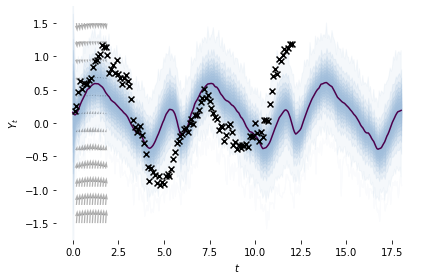

 50%|█████     | 250/500 [01:39<02:45,  1.51it/s]

tensor(985.5450, grad_fn=<MeanBackward0>)


 50%|█████     | 251/500 [01:39<02:22,  1.74it/s]

tensor(980.0833, grad_fn=<MeanBackward0>)


 50%|█████     | 252/500 [01:39<02:06,  1.95it/s]

tensor(982.8138, grad_fn=<MeanBackward0>)


 51%|█████     | 253/500 [01:40<01:56,  2.12it/s]

tensor(978.1946, grad_fn=<MeanBackward0>)


 51%|█████     | 254/500 [01:40<01:48,  2.27it/s]

tensor(985.5197, grad_fn=<MeanBackward0>)


 51%|█████     | 255/500 [01:41<01:44,  2.35it/s]

tensor(983.9069, grad_fn=<MeanBackward0>)


 51%|█████     | 256/500 [01:41<01:40,  2.44it/s]

tensor(982.5360, grad_fn=<MeanBackward0>)
tensor(982.5387, grad_fn=<MeanBackward0>)


 52%|█████▏    | 258/500 [01:42<01:37,  2.47it/s]

tensor(982.0538, grad_fn=<MeanBackward0>)


 52%|█████▏    | 259/500 [01:42<01:34,  2.55it/s]

tensor(981.0650, grad_fn=<MeanBackward0>)


 52%|█████▏    | 260/500 [01:42<01:32,  2.61it/s]

tensor(984.9497, grad_fn=<MeanBackward0>)


 52%|█████▏    | 261/500 [01:43<01:30,  2.64it/s]

tensor(993.3900, grad_fn=<MeanBackward0>)


 52%|█████▏    | 262/500 [01:43<01:29,  2.67it/s]

tensor(989.7667, grad_fn=<MeanBackward0>)


 53%|█████▎    | 263/500 [01:44<01:28,  2.67it/s]

tensor(980.6401, grad_fn=<MeanBackward0>)


 53%|█████▎    | 264/500 [01:44<01:28,  2.68it/s]

tensor(987.3672, grad_fn=<MeanBackward0>)


 53%|█████▎    | 265/500 [01:44<01:27,  2.69it/s]

tensor(989.2427, grad_fn=<MeanBackward0>)


 53%|█████▎    | 266/500 [01:45<01:26,  2.71it/s]

tensor(981.8278, grad_fn=<MeanBackward0>)


 53%|█████▎    | 267/500 [01:45<01:25,  2.72it/s]

tensor(981.8578, grad_fn=<MeanBackward0>)


 54%|█████▎    | 268/500 [01:45<01:24,  2.74it/s]

tensor(980.4481, grad_fn=<MeanBackward0>)


 54%|█████▍    | 269/500 [01:46<01:23,  2.75it/s]

tensor(984.5009, grad_fn=<MeanBackward0>)


 54%|█████▍    | 270/500 [01:46<01:23,  2.76it/s]

tensor(978.8881, grad_fn=<MeanBackward0>)


 54%|█████▍    | 271/500 [01:46<01:22,  2.77it/s]

tensor(988.1627, grad_fn=<MeanBackward0>)


 54%|█████▍    | 272/500 [01:47<01:22,  2.76it/s]

tensor(985.0558, grad_fn=<MeanBackward0>)


 55%|█████▍    | 273/500 [01:47<01:22,  2.76it/s]

tensor(987.8084, grad_fn=<MeanBackward0>)


 55%|█████▍    | 274/500 [01:48<01:21,  2.77it/s]

tensor(988.7592, grad_fn=<MeanBackward0>)


 55%|█████▌    | 275/500 [01:48<01:21,  2.77it/s]

tensor(986.8649, grad_fn=<MeanBackward0>)


 55%|█████▌    | 276/500 [01:48<01:20,  2.78it/s]

tensor(986.8699, grad_fn=<MeanBackward0>)


 55%|█████▌    | 277/500 [01:49<01:20,  2.76it/s]

tensor(980.3829, grad_fn=<MeanBackward0>)


 56%|█████▌    | 278/500 [01:49<01:20,  2.76it/s]

tensor(981.8885, grad_fn=<MeanBackward0>)


 56%|█████▌    | 279/500 [01:49<01:20,  2.76it/s]

tensor(981.5435, grad_fn=<MeanBackward0>)


 56%|█████▌    | 280/500 [01:50<01:23,  2.63it/s]

tensor(981.1461, grad_fn=<MeanBackward0>)


 56%|█████▌    | 281/500 [01:50<01:21,  2.68it/s]

tensor(975.8589, grad_fn=<MeanBackward0>)


 56%|█████▋    | 282/500 [01:51<01:20,  2.71it/s]

tensor(992.2302, grad_fn=<MeanBackward0>)


 57%|█████▋    | 283/500 [01:51<01:20,  2.69it/s]

tensor(983.6104, grad_fn=<MeanBackward0>)


 57%|█████▋    | 284/500 [01:51<01:19,  2.72it/s]

tensor(984.2738, grad_fn=<MeanBackward0>)


 57%|█████▋    | 285/500 [01:52<01:18,  2.74it/s]

tensor(986.9411, grad_fn=<MeanBackward0>)


 57%|█████▋    | 286/500 [01:52<01:17,  2.75it/s]

tensor(985.1539, grad_fn=<MeanBackward0>)


 57%|█████▋    | 287/500 [01:52<01:17,  2.76it/s]

tensor(985.9535, grad_fn=<MeanBackward0>)


 58%|█████▊    | 288/500 [01:53<01:16,  2.77it/s]

tensor(991.8105, grad_fn=<MeanBackward0>)


 58%|█████▊    | 289/500 [01:53<01:16,  2.78it/s]

tensor(985.1711, grad_fn=<MeanBackward0>)


 58%|█████▊    | 290/500 [01:53<01:15,  2.78it/s]

tensor(989.5311, grad_fn=<MeanBackward0>)


 58%|█████▊    | 291/500 [01:54<01:15,  2.78it/s]

tensor(985.8187, grad_fn=<MeanBackward0>)
tensor(987.4769, grad_fn=<MeanBackward0>)


 59%|█████▊    | 293/500 [01:55<01:19,  2.61it/s]

tensor(985.8782, grad_fn=<MeanBackward0>)


 59%|█████▉    | 294/500 [01:55<01:21,  2.53it/s]

tensor(982.5602, grad_fn=<MeanBackward0>)


 59%|█████▉    | 295/500 [01:55<01:20,  2.56it/s]

tensor(981.9728, grad_fn=<MeanBackward0>)


 59%|█████▉    | 296/500 [01:56<01:19,  2.58it/s]

tensor(984.1932, grad_fn=<MeanBackward0>)


 59%|█████▉    | 297/500 [01:56<01:18,  2.59it/s]

tensor(982.1932, grad_fn=<MeanBackward0>)


 60%|█████▉    | 298/500 [01:57<01:17,  2.61it/s]

tensor(986.7412, grad_fn=<MeanBackward0>)


 60%|█████▉    | 299/500 [01:57<01:16,  2.61it/s]

tensor(985.3008, grad_fn=<MeanBackward0>)


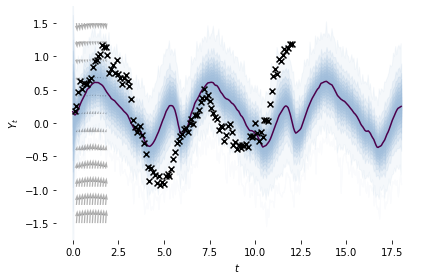

 60%|██████    | 300/500 [01:58<02:21,  1.41it/s]

tensor(986.9258, grad_fn=<MeanBackward0>)


 60%|██████    | 301/500 [01:59<02:03,  1.61it/s]

tensor(983.6769, grad_fn=<MeanBackward0>)


 60%|██████    | 302/500 [01:59<01:49,  1.81it/s]

tensor(979.2358, grad_fn=<MeanBackward0>)


 61%|██████    | 303/500 [02:00<01:41,  1.94it/s]

tensor(981.8568, grad_fn=<MeanBackward0>)


 61%|██████    | 304/500 [02:00<01:34,  2.08it/s]

tensor(984.3455, grad_fn=<MeanBackward0>)


 61%|██████    | 305/500 [02:00<01:29,  2.18it/s]

tensor(983.1973, grad_fn=<MeanBackward0>)


 61%|██████    | 306/500 [02:01<01:25,  2.28it/s]

tensor(994.1849, grad_fn=<MeanBackward0>)
tensor(985.8240, grad_fn=<MeanBackward0>)


 62%|██████▏   | 308/500 [02:02<01:21,  2.35it/s]

tensor(980.9849, grad_fn=<MeanBackward0>)


 62%|██████▏   | 309/500 [02:02<01:19,  2.39it/s]

tensor(976.4527, grad_fn=<MeanBackward0>)


 62%|██████▏   | 310/500 [02:02<01:18,  2.42it/s]

tensor(986.1632, grad_fn=<MeanBackward0>)


 62%|██████▏   | 311/500 [02:03<01:17,  2.44it/s]

tensor(987.3903, grad_fn=<MeanBackward0>)


 62%|██████▏   | 312/500 [02:03<01:15,  2.48it/s]

tensor(978.3706, grad_fn=<MeanBackward0>)


 63%|██████▎   | 313/500 [02:04<01:14,  2.52it/s]

tensor(983.2943, grad_fn=<MeanBackward0>)


 63%|██████▎   | 314/500 [02:04<01:12,  2.55it/s]

tensor(980.2260, grad_fn=<MeanBackward0>)


 63%|██████▎   | 315/500 [02:04<01:11,  2.58it/s]

tensor(993.2975, grad_fn=<MeanBackward0>)


 63%|██████▎   | 316/500 [02:05<01:11,  2.59it/s]

tensor(978.6177, grad_fn=<MeanBackward0>)


 63%|██████▎   | 317/500 [02:05<01:10,  2.59it/s]

tensor(973.7847, grad_fn=<MeanBackward0>)


 64%|██████▎   | 318/500 [02:06<01:10,  2.60it/s]

tensor(992.1392, grad_fn=<MeanBackward0>)


 64%|██████▍   | 319/500 [02:06<01:10,  2.58it/s]

tensor(983.0573, grad_fn=<MeanBackward0>)


 64%|██████▍   | 320/500 [02:06<01:08,  2.61it/s]

tensor(991.8530, grad_fn=<MeanBackward0>)


 64%|██████▍   | 321/500 [02:07<01:08,  2.61it/s]

tensor(985.8419, grad_fn=<MeanBackward0>)


 64%|██████▍   | 322/500 [02:07<01:09,  2.57it/s]

tensor(982.7526, grad_fn=<MeanBackward0>)


 65%|██████▍   | 323/500 [02:07<01:08,  2.59it/s]

tensor(982.2971, grad_fn=<MeanBackward0>)


 65%|██████▍   | 324/500 [02:08<01:07,  2.61it/s]

tensor(984.8928, grad_fn=<MeanBackward0>)


 65%|██████▌   | 325/500 [02:08<01:06,  2.62it/s]

tensor(983.9050, grad_fn=<MeanBackward0>)


 65%|██████▌   | 326/500 [02:09<01:05,  2.64it/s]

tensor(979.6229, grad_fn=<MeanBackward0>)


 65%|██████▌   | 327/500 [02:09<01:05,  2.65it/s]

tensor(990.9538, grad_fn=<MeanBackward0>)


 66%|██████▌   | 328/500 [02:09<01:04,  2.65it/s]

tensor(978.9724, grad_fn=<MeanBackward0>)


 66%|██████▌   | 329/500 [02:10<01:04,  2.66it/s]

tensor(983.3561, grad_fn=<MeanBackward0>)


 66%|██████▌   | 330/500 [02:10<01:03,  2.68it/s]

tensor(982.3248, grad_fn=<MeanBackward0>)


 66%|██████▌   | 331/500 [02:10<01:03,  2.67it/s]

tensor(987.6299, grad_fn=<MeanBackward0>)


 66%|██████▋   | 332/500 [02:11<01:02,  2.68it/s]

tensor(976.7787, grad_fn=<MeanBackward0>)


 67%|██████▋   | 333/500 [02:11<01:02,  2.66it/s]

tensor(978.9451, grad_fn=<MeanBackward0>)


 67%|██████▋   | 334/500 [02:12<01:02,  2.65it/s]

tensor(981.1793, grad_fn=<MeanBackward0>)


 67%|██████▋   | 335/500 [02:12<01:02,  2.63it/s]

tensor(982.1371, grad_fn=<MeanBackward0>)


 67%|██████▋   | 336/500 [02:12<01:02,  2.63it/s]

tensor(984.0913, grad_fn=<MeanBackward0>)
tensor(984.6865, grad_fn=<MeanBackward0>)


 68%|██████▊   | 338/500 [02:13<01:06,  2.44it/s]

tensor(988.1879, grad_fn=<MeanBackward0>)


 68%|██████▊   | 339/500 [02:14<01:04,  2.51it/s]

tensor(994.0738, grad_fn=<MeanBackward0>)


 68%|██████▊   | 340/500 [02:14<01:02,  2.54it/s]

tensor(989.9453, grad_fn=<MeanBackward0>)


 68%|██████▊   | 341/500 [02:14<01:01,  2.59it/s]

tensor(990.6977, grad_fn=<MeanBackward0>)


 68%|██████▊   | 342/500 [02:15<01:00,  2.63it/s]

tensor(989.1957, grad_fn=<MeanBackward0>)


 69%|██████▊   | 343/500 [02:15<00:59,  2.66it/s]

tensor(985.6383, grad_fn=<MeanBackward0>)


 69%|██████▉   | 344/500 [02:15<00:58,  2.65it/s]

tensor(981.9261, grad_fn=<MeanBackward0>)


 69%|██████▉   | 345/500 [02:16<00:58,  2.64it/s]

tensor(983.4635, grad_fn=<MeanBackward0>)


 69%|██████▉   | 346/500 [02:16<00:58,  2.64it/s]

tensor(987.7605, grad_fn=<MeanBackward0>)


 69%|██████▉   | 347/500 [02:17<00:57,  2.64it/s]

tensor(986.0979, grad_fn=<MeanBackward0>)


 70%|██████▉   | 348/500 [02:17<00:57,  2.65it/s]

tensor(982.4827, grad_fn=<MeanBackward0>)


 70%|██████▉   | 349/500 [02:17<00:57,  2.64it/s]

tensor(980.9943, grad_fn=<MeanBackward0>)


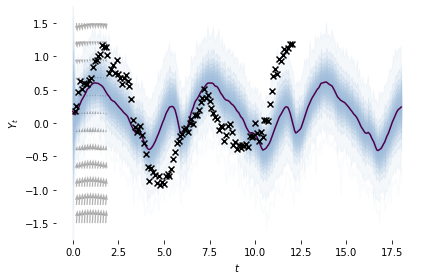

 70%|███████   | 350/500 [02:19<01:44,  1.44it/s]

tensor(984.6016, grad_fn=<MeanBackward0>)


 70%|███████   | 351/500 [02:19<01:29,  1.67it/s]

tensor(983.8660, grad_fn=<MeanBackward0>)


 70%|███████   | 352/500 [02:20<01:19,  1.86it/s]

tensor(983.3754, grad_fn=<MeanBackward0>)


 71%|███████   | 353/500 [02:20<01:12,  2.04it/s]

tensor(994.4907, grad_fn=<MeanBackward0>)


 71%|███████   | 354/500 [02:20<01:06,  2.19it/s]

tensor(990.2377, grad_fn=<MeanBackward0>)


 71%|███████   | 355/500 [02:21<01:03,  2.30it/s]

tensor(986.2930, grad_fn=<MeanBackward0>)


 71%|███████   | 356/500 [02:21<01:00,  2.37it/s]

tensor(986.2974, grad_fn=<MeanBackward0>)


 71%|███████▏  | 357/500 [02:22<00:58,  2.43it/s]

tensor(977.7628, grad_fn=<MeanBackward0>)


 72%|███████▏  | 358/500 [02:22<00:56,  2.51it/s]

tensor(985.4949, grad_fn=<MeanBackward0>)


 72%|███████▏  | 359/500 [02:22<00:55,  2.56it/s]

tensor(984.0672, grad_fn=<MeanBackward0>)


 72%|███████▏  | 360/500 [02:23<00:54,  2.58it/s]

tensor(985.7083, grad_fn=<MeanBackward0>)


 72%|███████▏  | 361/500 [02:23<00:53,  2.60it/s]

tensor(986.6658, grad_fn=<MeanBackward0>)


 72%|███████▏  | 362/500 [02:23<00:52,  2.64it/s]

tensor(979.1658, grad_fn=<MeanBackward0>)


 73%|███████▎  | 363/500 [02:24<00:51,  2.67it/s]

tensor(985.7514, grad_fn=<MeanBackward0>)


 73%|███████▎  | 364/500 [02:24<00:50,  2.70it/s]

tensor(985.4155, grad_fn=<MeanBackward0>)


 73%|███████▎  | 365/500 [02:24<00:49,  2.72it/s]

tensor(992.1267, grad_fn=<MeanBackward0>)


 73%|███████▎  | 366/500 [02:25<00:48,  2.74it/s]

tensor(983.8212, grad_fn=<MeanBackward0>)


 73%|███████▎  | 367/500 [02:25<00:48,  2.75it/s]

tensor(982.1793, grad_fn=<MeanBackward0>)


 74%|███████▎  | 368/500 [02:26<00:47,  2.76it/s]

tensor(983.2285, grad_fn=<MeanBackward0>)


 74%|███████▍  | 369/500 [02:26<00:47,  2.77it/s]

tensor(982.1946, grad_fn=<MeanBackward0>)
tensor(991.5891, grad_fn=<MeanBackward0>)


 74%|███████▍  | 371/500 [02:27<00:48,  2.64it/s]

tensor(983.4069, grad_fn=<MeanBackward0>)


 74%|███████▍  | 372/500 [02:27<00:49,  2.59it/s]

tensor(977.8567, grad_fn=<MeanBackward0>)


 75%|███████▍  | 373/500 [02:28<00:50,  2.52it/s]

tensor(986.2712, grad_fn=<MeanBackward0>)


 75%|███████▍  | 374/500 [02:28<00:49,  2.52it/s]

tensor(991.0201, grad_fn=<MeanBackward0>)


 75%|███████▌  | 375/500 [02:28<00:49,  2.51it/s]

tensor(980.8849, grad_fn=<MeanBackward0>)


 75%|███████▌  | 376/500 [02:29<00:48,  2.56it/s]

tensor(983.5023, grad_fn=<MeanBackward0>)


 75%|███████▌  | 377/500 [02:29<00:47,  2.58it/s]

tensor(989.2458, grad_fn=<MeanBackward0>)


 76%|███████▌  | 378/500 [02:29<00:47,  2.55it/s]

tensor(979.2519, grad_fn=<MeanBackward0>)


 76%|███████▌  | 379/500 [02:30<00:47,  2.54it/s]

tensor(978.6159, grad_fn=<MeanBackward0>)


 76%|███████▌  | 380/500 [02:30<00:47,  2.54it/s]

tensor(983.3439, grad_fn=<MeanBackward0>)


 76%|███████▌  | 381/500 [02:31<00:46,  2.55it/s]

tensor(981.2419, grad_fn=<MeanBackward0>)


 76%|███████▋  | 382/500 [02:31<00:47,  2.51it/s]

tensor(991.4405, grad_fn=<MeanBackward0>)


 77%|███████▋  | 383/500 [02:31<00:45,  2.56it/s]

tensor(987.9230, grad_fn=<MeanBackward0>)


 77%|███████▋  | 384/500 [02:32<00:44,  2.62it/s]

tensor(989.3738, grad_fn=<MeanBackward0>)


 77%|███████▋  | 385/500 [02:32<00:43,  2.65it/s]

tensor(985.1830, grad_fn=<MeanBackward0>)


 77%|███████▋  | 386/500 [02:33<00:42,  2.66it/s]

tensor(980.4621, grad_fn=<MeanBackward0>)


 77%|███████▋  | 387/500 [02:33<00:43,  2.57it/s]

tensor(982.4388, grad_fn=<MeanBackward0>)
tensor(980.3768, grad_fn=<MeanBackward0>)


 78%|███████▊  | 389/500 [02:34<00:44,  2.50it/s]

tensor(983.2960, grad_fn=<MeanBackward0>)


 78%|███████▊  | 390/500 [02:34<00:43,  2.53it/s]

tensor(990.4764, grad_fn=<MeanBackward0>)


 78%|███████▊  | 391/500 [02:35<00:43,  2.51it/s]

tensor(984.2958, grad_fn=<MeanBackward0>)


 78%|███████▊  | 392/500 [02:35<00:42,  2.54it/s]

tensor(985.7338, grad_fn=<MeanBackward0>)


 79%|███████▊  | 393/500 [02:35<00:41,  2.55it/s]

tensor(980.1725, grad_fn=<MeanBackward0>)


 79%|███████▉  | 394/500 [02:36<00:40,  2.60it/s]

tensor(984.8235, grad_fn=<MeanBackward0>)


 79%|███████▉  | 395/500 [02:36<00:39,  2.64it/s]

tensor(977.9053, grad_fn=<MeanBackward0>)


 79%|███████▉  | 396/500 [02:36<00:38,  2.67it/s]

tensor(975.9146, grad_fn=<MeanBackward0>)


 79%|███████▉  | 397/500 [02:37<00:38,  2.70it/s]

tensor(983.4775, grad_fn=<MeanBackward0>)


 80%|███████▉  | 398/500 [02:37<00:37,  2.71it/s]

tensor(981.1791, grad_fn=<MeanBackward0>)


 80%|███████▉  | 399/500 [02:38<00:37,  2.73it/s]

tensor(984.3610, grad_fn=<MeanBackward0>)


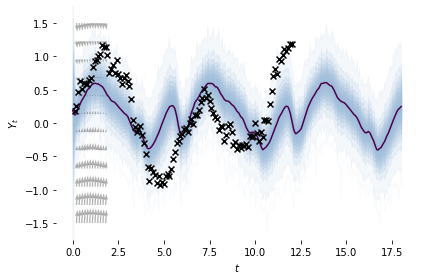

 80%|████████  | 400/500 [02:39<01:09,  1.44it/s]

tensor(985.0847, grad_fn=<MeanBackward0>)
tensor(993.0640, grad_fn=<MeanBackward0>)


 80%|████████  | 402/500 [02:40<00:56,  1.72it/s]

tensor(983.3991, grad_fn=<MeanBackward0>)


 81%|████████  | 403/500 [02:40<00:50,  1.92it/s]

tensor(987.5758, grad_fn=<MeanBackward0>)


 81%|████████  | 404/500 [02:41<00:45,  2.09it/s]

tensor(988.4941, grad_fn=<MeanBackward0>)


 81%|████████  | 405/500 [02:41<00:43,  2.21it/s]

tensor(981.4582, grad_fn=<MeanBackward0>)


 81%|████████  | 406/500 [02:41<00:40,  2.30it/s]

tensor(981.6715, grad_fn=<MeanBackward0>)


 81%|████████▏ | 407/500 [02:42<00:39,  2.37it/s]

tensor(990.1662, grad_fn=<MeanBackward0>)


 82%|████████▏ | 408/500 [02:42<00:37,  2.45it/s]

tensor(985.6467, grad_fn=<MeanBackward0>)


 82%|████████▏ | 409/500 [02:43<00:36,  2.51it/s]

tensor(986.5280, grad_fn=<MeanBackward0>)


 82%|████████▏ | 410/500 [02:43<00:35,  2.55it/s]

tensor(980.0561, grad_fn=<MeanBackward0>)


 82%|████████▏ | 411/500 [02:43<00:34,  2.58it/s]

tensor(974.4568, grad_fn=<MeanBackward0>)


 82%|████████▏ | 412/500 [02:44<00:33,  2.63it/s]

tensor(979.0801, grad_fn=<MeanBackward0>)


 83%|████████▎ | 413/500 [02:44<00:33,  2.62it/s]

tensor(984.3344, grad_fn=<MeanBackward0>)


 83%|████████▎ | 414/500 [02:45<00:33,  2.60it/s]

tensor(990.0621, grad_fn=<MeanBackward0>)


 83%|████████▎ | 415/500 [02:45<00:32,  2.64it/s]

tensor(974.6132, grad_fn=<MeanBackward0>)


 83%|████████▎ | 416/500 [02:45<00:31,  2.65it/s]

tensor(987.3632, grad_fn=<MeanBackward0>)


 83%|████████▎ | 417/500 [02:46<00:31,  2.67it/s]

tensor(980.8810, grad_fn=<MeanBackward0>)


 84%|████████▎ | 418/500 [02:46<00:30,  2.70it/s]

tensor(978.3622, grad_fn=<MeanBackward0>)


 84%|████████▍ | 419/500 [02:46<00:29,  2.72it/s]

tensor(985.9145, grad_fn=<MeanBackward0>)


 84%|████████▍ | 420/500 [02:47<00:29,  2.74it/s]

tensor(987.3249, grad_fn=<MeanBackward0>)


 84%|████████▍ | 421/500 [02:47<00:28,  2.75it/s]

tensor(982.7830, grad_fn=<MeanBackward0>)


 84%|████████▍ | 422/500 [02:47<00:28,  2.75it/s]

tensor(988.4684, grad_fn=<MeanBackward0>)


 85%|████████▍ | 423/500 [02:48<00:27,  2.76it/s]

tensor(989.3349, grad_fn=<MeanBackward0>)


 85%|████████▍ | 424/500 [02:48<00:30,  2.51it/s]

tensor(982.0512, grad_fn=<MeanBackward0>)


 85%|████████▌ | 425/500 [02:49<00:28,  2.59it/s]

tensor(983.2964, grad_fn=<MeanBackward0>)
tensor(982.3700, grad_fn=<MeanBackward0>)


 85%|████████▌ | 427/500 [02:49<00:29,  2.52it/s]

tensor(976.8781, grad_fn=<MeanBackward0>)


 86%|████████▌ | 428/500 [02:50<00:27,  2.58it/s]

tensor(981.6637, grad_fn=<MeanBackward0>)


 86%|████████▌ | 429/500 [02:50<00:26,  2.63it/s]

tensor(974.9287, grad_fn=<MeanBackward0>)


 86%|████████▌ | 430/500 [02:51<00:26,  2.68it/s]

tensor(986.8279, grad_fn=<MeanBackward0>)


 86%|████████▌ | 431/500 [02:51<00:25,  2.72it/s]

tensor(988.7234, grad_fn=<MeanBackward0>)


 86%|████████▋ | 432/500 [02:51<00:24,  2.74it/s]

tensor(985.2939, grad_fn=<MeanBackward0>)


 87%|████████▋ | 433/500 [02:52<00:24,  2.76it/s]

tensor(982.4778, grad_fn=<MeanBackward0>)


 87%|████████▋ | 434/500 [02:52<00:23,  2.78it/s]

tensor(979.8303, grad_fn=<MeanBackward0>)


 87%|████████▋ | 435/500 [02:52<00:23,  2.78it/s]

tensor(985.2000, grad_fn=<MeanBackward0>)


 87%|████████▋ | 436/500 [02:53<00:22,  2.79it/s]

tensor(984.3339, grad_fn=<MeanBackward0>)


 87%|████████▋ | 437/500 [02:53<00:22,  2.79it/s]

tensor(986.3049, grad_fn=<MeanBackward0>)


 88%|████████▊ | 438/500 [02:53<00:22,  2.80it/s]

tensor(982.8107, grad_fn=<MeanBackward0>)


 88%|████████▊ | 439/500 [02:54<00:21,  2.79it/s]

tensor(984.1915, grad_fn=<MeanBackward0>)


 88%|████████▊ | 440/500 [02:54<00:21,  2.79it/s]

tensor(982.6410, grad_fn=<MeanBackward0>)


 88%|████████▊ | 441/500 [02:54<00:21,  2.79it/s]

tensor(988.4550, grad_fn=<MeanBackward0>)


 88%|████████▊ | 442/500 [02:55<00:21,  2.75it/s]

tensor(982.4061, grad_fn=<MeanBackward0>)


 89%|████████▊ | 443/500 [02:55<00:20,  2.74it/s]

tensor(977.5760, grad_fn=<MeanBackward0>)


 89%|████████▉ | 444/500 [02:56<00:20,  2.72it/s]

tensor(981.7524, grad_fn=<MeanBackward0>)


 89%|████████▉ | 445/500 [02:56<00:20,  2.71it/s]

tensor(984.9961, grad_fn=<MeanBackward0>)


 89%|████████▉ | 446/500 [02:56<00:19,  2.70it/s]

tensor(980.7785, grad_fn=<MeanBackward0>)


 89%|████████▉ | 447/500 [02:57<00:19,  2.68it/s]

tensor(989.0445, grad_fn=<MeanBackward0>)


 90%|████████▉ | 448/500 [02:57<00:19,  2.68it/s]

tensor(985.8992, grad_fn=<MeanBackward0>)


 90%|████████▉ | 449/500 [02:57<00:19,  2.67it/s]

tensor(970.4479, grad_fn=<MeanBackward0>)


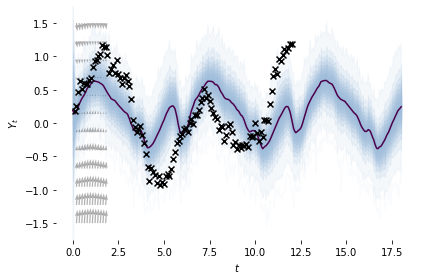

 90%|█████████ | 450/500 [02:59<00:34,  1.46it/s]

tensor(981.7198, grad_fn=<MeanBackward0>)


 90%|█████████ | 451/500 [02:59<00:29,  1.69it/s]

tensor(987.2162, grad_fn=<MeanBackward0>)


 90%|█████████ | 452/500 [03:00<00:25,  1.91it/s]

tensor(986.6630, grad_fn=<MeanBackward0>)


 91%|█████████ | 453/500 [03:00<00:22,  2.09it/s]

tensor(979.3204, grad_fn=<MeanBackward0>)


 91%|█████████ | 454/500 [03:00<00:20,  2.24it/s]

tensor(981.4602, grad_fn=<MeanBackward0>)


 91%|█████████ | 455/500 [03:01<00:19,  2.36it/s]

tensor(978.1730, grad_fn=<MeanBackward0>)


 91%|█████████ | 456/500 [03:01<00:18,  2.44it/s]

tensor(975.4602, grad_fn=<MeanBackward0>)


 91%|█████████▏| 457/500 [03:01<00:17,  2.52it/s]

tensor(979.3898, grad_fn=<MeanBackward0>)


 92%|█████████▏| 458/500 [03:02<00:16,  2.51it/s]

tensor(989.0640, grad_fn=<MeanBackward0>)


 92%|█████████▏| 459/500 [03:02<00:15,  2.57it/s]

tensor(986.1617, grad_fn=<MeanBackward0>)


 92%|█████████▏| 460/500 [03:03<00:15,  2.63it/s]

tensor(985.9467, grad_fn=<MeanBackward0>)


 92%|█████████▏| 461/500 [03:03<00:14,  2.63it/s]

tensor(979.9543, grad_fn=<MeanBackward0>)


 92%|█████████▏| 462/500 [03:03<00:14,  2.65it/s]

tensor(986.9133, grad_fn=<MeanBackward0>)


 93%|█████████▎| 463/500 [03:04<00:13,  2.67it/s]

tensor(981.9717, grad_fn=<MeanBackward0>)


 93%|█████████▎| 464/500 [03:04<00:13,  2.69it/s]

tensor(988.9705, grad_fn=<MeanBackward0>)


 93%|█████████▎| 465/500 [03:04<00:12,  2.71it/s]

tensor(979.9730, grad_fn=<MeanBackward0>)


 93%|█████████▎| 466/500 [03:05<00:12,  2.73it/s]

tensor(982.0746, grad_fn=<MeanBackward0>)


 93%|█████████▎| 467/500 [03:05<00:12,  2.74it/s]

tensor(981.8334, grad_fn=<MeanBackward0>)


 94%|█████████▎| 468/500 [03:06<00:11,  2.75it/s]

tensor(980.9774, grad_fn=<MeanBackward0>)


 94%|█████████▍| 469/500 [03:06<00:11,  2.75it/s]

tensor(984.0956, grad_fn=<MeanBackward0>)


 94%|█████████▍| 470/500 [03:06<00:10,  2.76it/s]

tensor(972.9897, grad_fn=<MeanBackward0>)


 94%|█████████▍| 471/500 [03:07<00:10,  2.76it/s]

tensor(980.6492, grad_fn=<MeanBackward0>)


 94%|█████████▍| 472/500 [03:07<00:10,  2.76it/s]

tensor(983.5098, grad_fn=<MeanBackward0>)


 95%|█████████▍| 473/500 [03:07<00:09,  2.71it/s]

tensor(982.2539, grad_fn=<MeanBackward0>)


 95%|█████████▍| 474/500 [03:08<00:09,  2.72it/s]

tensor(987.7726, grad_fn=<MeanBackward0>)


 95%|█████████▌| 475/500 [03:08<00:09,  2.73it/s]

tensor(984.3026, grad_fn=<MeanBackward0>)


 95%|█████████▌| 476/500 [03:08<00:08,  2.75it/s]

tensor(989.1837, grad_fn=<MeanBackward0>)


 95%|█████████▌| 477/500 [03:09<00:08,  2.76it/s]

tensor(986.0020, grad_fn=<MeanBackward0>)


 96%|█████████▌| 478/500 [03:09<00:07,  2.76it/s]

tensor(990.9886, grad_fn=<MeanBackward0>)


 96%|█████████▌| 479/500 [03:10<00:07,  2.76it/s]

tensor(983.5229, grad_fn=<MeanBackward0>)


 96%|█████████▌| 480/500 [03:10<00:07,  2.77it/s]

tensor(981.0603, grad_fn=<MeanBackward0>)


 96%|█████████▌| 481/500 [03:10<00:06,  2.77it/s]

tensor(983.9327, grad_fn=<MeanBackward0>)


 96%|█████████▋| 482/500 [03:11<00:06,  2.77it/s]

tensor(980.4127, grad_fn=<MeanBackward0>)


 97%|█████████▋| 483/500 [03:11<00:06,  2.76it/s]

tensor(983.0409, grad_fn=<MeanBackward0>)


 97%|█████████▋| 484/500 [03:11<00:05,  2.78it/s]

tensor(983.4984, grad_fn=<MeanBackward0>)


 97%|█████████▋| 485/500 [03:12<00:05,  2.78it/s]

tensor(982.8422, grad_fn=<MeanBackward0>)


 97%|█████████▋| 486/500 [03:12<00:05,  2.78it/s]

tensor(981.2736, grad_fn=<MeanBackward0>)


 97%|█████████▋| 487/500 [03:12<00:04,  2.78it/s]

tensor(985.7709, grad_fn=<MeanBackward0>)


 98%|█████████▊| 488/500 [03:13<00:04,  2.78it/s]

tensor(982.4301, grad_fn=<MeanBackward0>)


 98%|█████████▊| 489/500 [03:13<00:03,  2.77it/s]

tensor(983.6108, grad_fn=<MeanBackward0>)


 98%|█████████▊| 490/500 [03:14<00:03,  2.65it/s]

tensor(977.0432, grad_fn=<MeanBackward0>)


 98%|█████████▊| 491/500 [03:14<00:03,  2.61it/s]

tensor(985.0179, grad_fn=<MeanBackward0>)


 98%|█████████▊| 492/500 [03:14<00:03,  2.66it/s]

tensor(977.1169, grad_fn=<MeanBackward0>)


 99%|█████████▊| 493/500 [03:15<00:02,  2.69it/s]

tensor(981.8801, grad_fn=<MeanBackward0>)


 99%|█████████▉| 494/500 [03:15<00:02,  2.71it/s]

tensor(991.8789, grad_fn=<MeanBackward0>)


 99%|█████████▉| 495/500 [03:15<00:01,  2.73it/s]

tensor(992.3047, grad_fn=<MeanBackward0>)


 99%|█████████▉| 496/500 [03:16<00:01,  2.75it/s]

tensor(979.5581, grad_fn=<MeanBackward0>)


 99%|█████████▉| 497/500 [03:16<00:01,  2.75it/s]

tensor(984.5319, grad_fn=<MeanBackward0>)


100%|█████████▉| 498/500 [03:16<00:00,  2.76it/s]

tensor(980.2249, grad_fn=<MeanBackward0>)


100%|█████████▉| 499/500 [03:17<00:00,  2.77it/s]

tensor(979.3212, grad_fn=<MeanBackward0>)


100%|██████████| 500/500 [03:18<00:00,  2.52it/s]

tensor(986.5412, grad_fn=<MeanBackward0>)


In [225]:
model_testing = LatentSDE_testing().to(device)
l2_only_list = main_2(model_testing)

## plot the logpy 

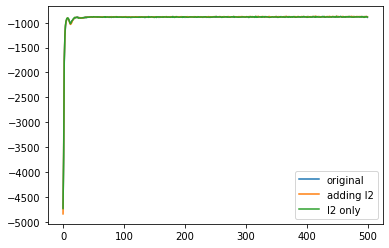

In [226]:
plt.plot(original_logpy,label="original")
plt.plot(l2_logpy_list, label="adding l2")
plt.plot(l2_only_list, label="l2 only")
plt.legend()
plt.show()
plt.close()

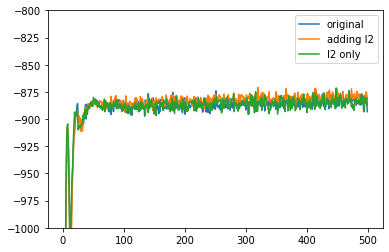

In [229]:
plt.plot(original_logpy,label="original")
plt.plot(l2_logpy_list, label="adding l2")
plt.plot(l2_only_list, label="l2 only")
plt.legend()
plt.ylim((-1000,-800))
plt.show()
plt.close()

## exclude the logpy and only using the l2 loss

# (Part 3)

# force the model to act like a AR(1)

In [246]:
class LatentSDE(torchsde.SDEIto):

    def __init__(self, theta=0.5, mu=0.0, sigma=1.0):
        super(LatentSDE, self).__init__(noise_type="diagonal")
        logvar = math.log(sigma ** 2 / (2. * theta))

        # Prior drift.
        self.register_buffer("theta", torch.tensor([[theta]]))
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma", torch.tensor([[sigma]]))

        # p(y0).
        self.register_buffer("py0_mean", torch.tensor([[mu]]))
        self.register_buffer("py0_logvar", torch.tensor([[logvar]]))

        # Approximate posterior drift: Takes in 2 positional encodings and the state.
        self.net = nn.Sequential(
            nn.Linear(3, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 1)
        )
        # Initialization trick from Glow.
        self.net[-1].weight.data.fill_(0.)
        self.net[-1].bias.data.fill_(0.)

        # q(y0).
        self.qy0_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=True)
        self.qy0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True)

        self.A = nn.Parameter(torch.tensor(1.),requires_grad=True)
        self.w = nn.Parameter(torch.tensor(1.),requires_grad=True)
        self.phi = nn.Parameter(torch.tensor(0.),requires_grad=True)
        self.k = nn.Parameter(torch.tensor(0.),requires_grad=True)
        
    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            #t = torch.full_like(y, fill_value=t*100.0/132.0 )
            t = torch.full_like(y, fill_value=t )

        # Positional encoding in transformers for time-inhomogeneous posterior.
        return self.net(torch.cat((torch.sin(t), torch.cos(t),  y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), torch.sin(t**3), torch.cos(t**3), y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), y), dim=-1))
    
    def g(self, t, y):  # Shared diffusion.
        return self.sigma.repeat(y.size(0), 1)



    def h(self, t, y):  # Prior drift.
        #sin = self.A*torch.sin(self.w*t+self.phi) + self.k
        #sin.repeat(y.size(0),1)
        return self.theta * (self.mu - y)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1]
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y)
        u = _stable_division(f - h, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y)
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=args.method,
            dt=args.dt,
            adaptive=args.adaptive,
            rtol=args.rtol,
            atol=args.atol,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt, names={'drift': 'h'})
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt, names={'drift': 'h'})

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt)
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt)

    @property
    def py0_std(self):
        return torch.exp(.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return torch.exp(.5 * self.qy0_logvar)

In [247]:
torch.pi = torch.acos(torch.zeros(1)).item() * 2
def log_likelihood_batch(p,rm):
    T = rm.shape[1]
    t = torch.linspace(1,T,T)
    c = 0.1*torch.sin(2*torch.pi*t/s)
    lls = torch.zeros(rm.shape[0])
    for i in range(len(rm)):
        r = rm[i]
        epsilon = torch.zeros(T)
        for i in range(1,T):
            epsilon[i] = r[i] - phi*r[i-1] - c[i]
        sigma = torch.std(epsilon)
        ll = -0.5 * (T - p) * math.log(2 * torch.pi) - 0.5 * (T - p) * math.log(sigma ** 2) 
        ll = ll - 0.5 * torch.dot(epsilon, epsilon) * sigma ** (-2)
        lls[i] = ll
    return lls

In [252]:
def main_1(model,is_logpy=True, conditional=False):
    # Dataset.
    ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()
    llg = log_likelihood(1,ys)
    # Plotting parameters.
    vis_batch_size = 1024
    ylims = (-1.75, 1.75)
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = np.random.permutation(vis_batch_size)
    original_logpy_list = []
    # From https://colorbrewer2.org/.
    if args.color == "blue":
        sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
        fill_color = '#9ebcda'
        mean_color = '#4d004b'
        num_samples = len(sample_colors)
    else:
        sample_colors = ('#fc4e2a', '#e31a1c', '#bd0026')
        fill_color = '#fd8d3c'
        mean_color = '#800026'
        num_samples = len(sample_colors)

    eps = torch.randn(vis_batch_size, 1).to(device)  # Fix seed for the random draws used in the plots.
    bm = torchsde.BrownianInterval(
        t0=ts_vis[0],
        t1=ts_vis[-1],
        size=(vis_batch_size, 1),
        device=device,
        levy_area_approximation='space-time'
    )  # We need space-time Levy area to use the SRK solver

    # Model.
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
    kl_scheduler = LinearScheduler(iters=args.kl_anneal_iters)
    criterion = nn.MSELoss()

    logpy_metric = EMAMetric()
    kl_metric = EMAMetric()
    loss_metric = EMAMetric()

    if args.show_prior:
        with torch.no_grad():
            zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
            ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
            zs_ = np.sort(zs_, axis=1)

            img_dir = os.path.join(args.train_dir, 'prior.png')
            plt.subplot(frameon=False)
            for alpha, percentile in zip(alphas, percentiles):
                idx = int((1 - percentile) / 2. * vis_batch_size)
                zs_bot_ = zs_[:, idx]
                zs_top_ = zs_[:, -idx]
                plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

            # `zorder` determines who's on top; the larger the more at the top.
            plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')
            plt.tight_layout()
            plt.savefig(img_dir, dpi=args.dpi)
            plt.show()
            plt.close()
            logging.info(f'Saved prior figure at: {img_dir}')

    for global_step in tqdm.tqdm(range(args.train_iters)):
        # Plot and save.
        if (global_step+1) % args.pause_iters == 0:
            img_path = os.path.join(args.train_dir, f'global_step_{global_step+1}.png')

            with torch.no_grad():
                zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
                samples = zs[:, vis_idx]
                ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
                zs_ = np.sort(zs_, axis=1)
                plt.subplot(frameon=False)

                if args.show_percentiles:
                    for alpha, percentile in zip(alphas, percentiles):
                        idx = int((1 - percentile) / 2. * vis_batch_size)
                        zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
                        plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

                if args.show_mean:
                    plt.plot(ts_vis_, zs_.mean(axis=1), color=mean_color)

                if args.show_samples:
                    for j in range(num_samples):
                        plt.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=1.0)

                if args.show_arrows:
                    num, dt = 12, 0.12
                    t, y = torch.meshgrid(
                        [torch.linspace(0.2, 1.8, num).to(device), torch.linspace(-1.5, 1.5, num).to(device)]
                    )
                    t, y = t.reshape(-1, 1), y.reshape(-1, 1)
                    fty = model.f(t=t, y=y).reshape(num, num)
                    dt = torch.zeros(num, num).fill_(dt).to(device)
                    dy = fty * dt
                    dt_, dy_, t_, y_ = dt.cpu().numpy(), dy.cpu().numpy(), t.cpu().numpy(), y.cpu().numpy()
                    plt.quiver(t_, y_, dt_, dy_, alpha=0.3, edgecolors='k', width=0.0035, scale=50)

                if args.hide_ticks:
                    plt.xticks([], [])
                    plt.yticks([], [])

                plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
                plt.ylim(ylims)
                plt.xlabel('$t$')
                plt.ylabel('$Y_t$')
                plt.tight_layout()
                plt.savefig(img_path, dpi=args.dpi)
                plt.show()
                plt.close()
                logging.info(f'Saved figure at: {img_path}')

                if args.save_ckpt:
                    torch.save(
                        {'model': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'kl_scheduler': kl_scheduler},
                        os.path.join(ckpt_dir, f'global_step_{global_step}.ckpt')
                    )

        # Train.
        optimizer.zero_grad()
        zs, kl = model(ts=ts_ext, batch_size=args.batch_size)
        zs = zs.squeeze()
        zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.

        likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
        likelihood = likelihood_constructor(loc=zs, scale=args.scale)
        logpy = likelihood.log_prob(ys).sum(dim=0).mean(dim=0)

        original_logpy_list.append(logpy.item())
        #llg = log_likelihood(1,zs.permute([1,0]).squeeze(),120).mean()
        llg_loss = log_likelihood_batch(1,zs.permute([1,0])).mean()
        print(llg_loss)
        #print(likelihood.log_prob(ys).mean(dim=1).shape)
        if conditional:
            loss = kl*kl_scheduler.val - llg_loss
        else:
            loss =kl* kl_scheduler.val
        if is_logpy:
            loss -= logpy
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

        logpy_metric.step(logpy)
        kl_metric.step(kl)
        loss_metric.step(loss)

        logging.info(
            f'global_step: {global_step}, '
            f'logpy: {logpy_metric.val:.3f}, '
            f'kl: {kl_metric.val:.3f}, '
            f'llg_loss: {llg_loss.item():.3f}, '
            f'loss: {loss_metric.val:.3f}'
        )
    return original_logpy_list

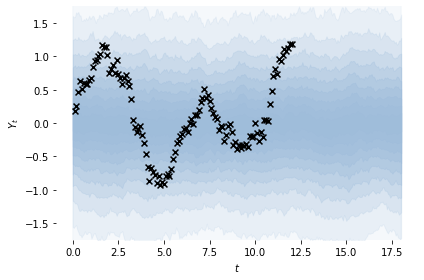

  0%|          | 1/200 [00:01<05:45,  1.74s/it]

tensor(-0.0923, grad_fn=<MeanBackward0>)


  1%|          | 2/200 [00:03<06:04,  1.84s/it]

tensor(-0.0623, grad_fn=<MeanBackward0>)


  2%|▏         | 3/200 [00:05<06:15,  1.90s/it]

tensor(-0.0636, grad_fn=<MeanBackward0>)


  2%|▏         | 4/200 [00:07<06:07,  1.87s/it]

tensor(-0.0654, grad_fn=<MeanBackward0>)


  2%|▎         | 5/200 [00:09<05:55,  1.82s/it]

tensor(-0.0744, grad_fn=<MeanBackward0>)


  3%|▎         | 6/200 [00:11<05:47,  1.79s/it]

tensor(-0.0905, grad_fn=<MeanBackward0>)


  4%|▎         | 7/200 [00:12<05:42,  1.77s/it]

tensor(-0.1158, grad_fn=<MeanBackward0>)


  4%|▍         | 8/200 [00:14<05:36,  1.75s/it]

tensor(-0.1346, grad_fn=<MeanBackward0>)


  4%|▍         | 9/200 [00:16<05:32,  1.74s/it]

tensor(-0.1345, grad_fn=<MeanBackward0>)


  5%|▌         | 10/200 [00:17<05:28,  1.73s/it]

tensor(-0.1675, grad_fn=<MeanBackward0>)


  6%|▌         | 11/200 [00:19<05:26,  1.73s/it]

tensor(-0.2228, grad_fn=<MeanBackward0>)


  6%|▌         | 12/200 [00:21<05:27,  1.74s/it]

tensor(-0.2760, grad_fn=<MeanBackward0>)


  6%|▋         | 13/200 [00:23<05:29,  1.76s/it]

tensor(-0.2493, grad_fn=<MeanBackward0>)


  7%|▋         | 14/200 [00:25<05:28,  1.77s/it]

tensor(-0.2614, grad_fn=<MeanBackward0>)


  8%|▊         | 15/200 [00:26<05:22,  1.74s/it]

tensor(-0.2284, grad_fn=<MeanBackward0>)


  8%|▊         | 16/200 [00:28<05:17,  1.73s/it]

tensor(-0.1806, grad_fn=<MeanBackward0>)


  8%|▊         | 17/200 [00:30<05:13,  1.72s/it]

tensor(-0.1722, grad_fn=<MeanBackward0>)


  9%|▉         | 18/200 [00:31<05:10,  1.70s/it]

tensor(-0.1627, grad_fn=<MeanBackward0>)


 10%|▉         | 19/200 [00:33<05:09,  1.71s/it]

tensor(-0.1550, grad_fn=<MeanBackward0>)


 10%|█         | 20/200 [00:35<05:07,  1.71s/it]

tensor(-0.1374, grad_fn=<MeanBackward0>)


 10%|█         | 21/200 [00:36<05:07,  1.72s/it]

tensor(-0.1238, grad_fn=<MeanBackward0>)


 11%|█         | 22/200 [00:38<05:10,  1.74s/it]

tensor(-0.1350, grad_fn=<MeanBackward0>)


 12%|█▏        | 23/200 [00:40<05:05,  1.72s/it]

tensor(-0.1178, grad_fn=<MeanBackward0>)


 12%|█▏        | 24/200 [00:42<05:01,  1.71s/it]

tensor(-0.1064, grad_fn=<MeanBackward0>)


 12%|█▎        | 25/200 [00:43<04:59,  1.71s/it]

tensor(-0.1477, grad_fn=<MeanBackward0>)


 13%|█▎        | 26/200 [00:45<04:56,  1.71s/it]

tensor(-0.1387, grad_fn=<MeanBackward0>)


 14%|█▎        | 27/200 [00:47<04:53,  1.70s/it]

tensor(-0.1043, grad_fn=<MeanBackward0>)


 14%|█▍        | 28/200 [00:48<04:51,  1.70s/it]

tensor(-0.0985, grad_fn=<MeanBackward0>)


 14%|█▍        | 29/200 [00:50<04:50,  1.70s/it]

tensor(-0.1060, grad_fn=<MeanBackward0>)


 15%|█▌        | 30/200 [00:52<04:47,  1.69s/it]

tensor(-0.1057, grad_fn=<MeanBackward0>)


 16%|█▌        | 31/200 [00:53<04:45,  1.69s/it]

tensor(-0.1144, grad_fn=<MeanBackward0>)


 16%|█▌        | 32/200 [00:55<04:46,  1.70s/it]

tensor(-0.1340, grad_fn=<MeanBackward0>)


 16%|█▋        | 33/200 [00:57<04:43,  1.70s/it]

tensor(-0.1201, grad_fn=<MeanBackward0>)


 17%|█▋        | 34/200 [00:59<04:41,  1.69s/it]

tensor(-0.1120, grad_fn=<MeanBackward0>)


 18%|█▊        | 35/200 [01:00<04:38,  1.69s/it]

tensor(-0.0937, grad_fn=<MeanBackward0>)


 18%|█▊        | 36/200 [01:02<04:36,  1.69s/it]

tensor(-0.0929, grad_fn=<MeanBackward0>)


 18%|█▊        | 37/200 [01:04<04:34,  1.68s/it]

tensor(-0.0927, grad_fn=<MeanBackward0>)


 19%|█▉        | 38/200 [01:05<04:34,  1.69s/it]

tensor(-0.1462, grad_fn=<MeanBackward0>)


 20%|█▉        | 39/200 [01:07<04:32,  1.70s/it]

tensor(-0.1253, grad_fn=<MeanBackward0>)


 20%|██        | 40/200 [01:09<04:30,  1.69s/it]

tensor(-0.1217, grad_fn=<MeanBackward0>)


 20%|██        | 41/200 [01:10<04:28,  1.69s/it]

tensor(-0.1080, grad_fn=<MeanBackward0>)


 21%|██        | 42/200 [01:12<04:26,  1.69s/it]

tensor(-0.1021, grad_fn=<MeanBackward0>)


 22%|██▏       | 43/200 [01:14<04:24,  1.68s/it]

tensor(-0.1264, grad_fn=<MeanBackward0>)


 22%|██▏       | 44/200 [01:15<04:22,  1.68s/it]

tensor(-0.1236, grad_fn=<MeanBackward0>)


 22%|██▎       | 45/200 [01:17<04:21,  1.69s/it]

tensor(-0.1766, grad_fn=<MeanBackward0>)


 23%|██▎       | 46/200 [01:19<04:21,  1.70s/it]

tensor(-0.1352, grad_fn=<MeanBackward0>)


 24%|██▎       | 47/200 [01:21<04:25,  1.74s/it]

tensor(-0.1357, grad_fn=<MeanBackward0>)


 24%|██▍       | 48/200 [01:22<04:25,  1.75s/it]

tensor(-0.1486, grad_fn=<MeanBackward0>)


 24%|██▍       | 49/200 [01:24<04:26,  1.77s/it]

tensor(-0.1521, grad_fn=<MeanBackward0>)


 25%|██▌       | 50/200 [01:27<05:14,  2.09s/it]

tensor(-0.1305, grad_fn=<MeanBackward0>)


 26%|██▌       | 51/200 [01:29<04:58,  2.00s/it]

tensor(-0.1443, grad_fn=<MeanBackward0>)


 26%|██▌       | 52/200 [01:31<04:43,  1.91s/it]

tensor(-0.1160, grad_fn=<MeanBackward0>)


 26%|██▋       | 53/200 [01:32<04:31,  1.85s/it]

tensor(-0.1405, grad_fn=<MeanBackward0>)


 27%|██▋       | 54/200 [01:34<04:22,  1.80s/it]

tensor(-0.1451, grad_fn=<MeanBackward0>)


 28%|██▊       | 55/200 [01:36<04:16,  1.77s/it]

tensor(-0.1324, grad_fn=<MeanBackward0>)


 28%|██▊       | 56/200 [01:37<04:10,  1.74s/it]

tensor(-0.1531, grad_fn=<MeanBackward0>)


 28%|██▊       | 57/200 [01:39<04:10,  1.75s/it]

tensor(-0.1082, grad_fn=<MeanBackward0>)


 29%|██▉       | 58/200 [01:41<04:05,  1.73s/it]

tensor(-0.1226, grad_fn=<MeanBackward0>)


 30%|██▉       | 59/200 [01:42<04:02,  1.72s/it]

tensor(-0.1040, grad_fn=<MeanBackward0>)


 30%|███       | 60/200 [01:44<03:58,  1.71s/it]

tensor(-0.1479, grad_fn=<MeanBackward0>)


 30%|███       | 61/200 [01:46<03:57,  1.71s/it]

tensor(-0.1174, grad_fn=<MeanBackward0>)


 31%|███       | 62/200 [01:48<03:54,  1.70s/it]

tensor(-0.1253, grad_fn=<MeanBackward0>)


 32%|███▏      | 63/200 [01:49<03:52,  1.70s/it]

tensor(-0.1035, grad_fn=<MeanBackward0>)


 32%|███▏      | 64/200 [01:51<03:51,  1.70s/it]

tensor(-0.0984, grad_fn=<MeanBackward0>)


 32%|███▎      | 65/200 [01:53<03:48,  1.70s/it]

tensor(-0.1181, grad_fn=<MeanBackward0>)


 33%|███▎      | 66/200 [01:54<03:46,  1.69s/it]

tensor(-0.1185, grad_fn=<MeanBackward0>)


 34%|███▎      | 67/200 [01:56<03:44,  1.69s/it]

tensor(-0.0813, grad_fn=<MeanBackward0>)


 34%|███▍      | 68/200 [01:58<03:43,  1.69s/it]

tensor(-0.0957, grad_fn=<MeanBackward0>)


 34%|███▍      | 69/200 [01:59<03:41,  1.69s/it]

tensor(-0.0885, grad_fn=<MeanBackward0>)


 35%|███▌      | 70/200 [02:01<03:39,  1.69s/it]

tensor(-0.1015, grad_fn=<MeanBackward0>)


 36%|███▌      | 71/200 [02:03<03:37,  1.69s/it]

tensor(-0.0855, grad_fn=<MeanBackward0>)


 36%|███▌      | 72/200 [02:04<03:35,  1.69s/it]

tensor(-0.1101, grad_fn=<MeanBackward0>)


 36%|███▋      | 73/200 [02:06<03:34,  1.69s/it]

tensor(-0.0745, grad_fn=<MeanBackward0>)


 37%|███▋      | 74/200 [02:08<03:32,  1.69s/it]

tensor(-0.1082, grad_fn=<MeanBackward0>)


 38%|███▊      | 75/200 [02:09<03:30,  1.69s/it]

tensor(-0.1341, grad_fn=<MeanBackward0>)


 38%|███▊      | 76/200 [02:11<03:28,  1.69s/it]

tensor(-0.0727, grad_fn=<MeanBackward0>)


 38%|███▊      | 77/200 [02:13<03:27,  1.69s/it]

tensor(-0.1012, grad_fn=<MeanBackward0>)


 39%|███▉      | 78/200 [02:15<03:32,  1.75s/it]

tensor(-0.0766, grad_fn=<MeanBackward0>)


 40%|███▉      | 79/200 [02:17<03:31,  1.75s/it]

tensor(-0.1059, grad_fn=<MeanBackward0>)


 40%|████      | 80/200 [02:18<03:27,  1.73s/it]

tensor(-0.1278, grad_fn=<MeanBackward0>)


 40%|████      | 81/200 [02:20<03:24,  1.72s/it]

tensor(-0.1378, grad_fn=<MeanBackward0>)


 41%|████      | 82/200 [02:22<03:25,  1.74s/it]

tensor(-0.1004, grad_fn=<MeanBackward0>)


 42%|████▏     | 83/200 [02:23<03:24,  1.75s/it]

tensor(-0.1008, grad_fn=<MeanBackward0>)
tensor(-0.1481, grad_fn=<MeanBackward0>)


 42%|████▏     | 84/200 [02:25<03:26,  1.78s/it]

tensor(-0.0773, grad_fn=<MeanBackward0>)


 42%|████▎     | 85/200 [02:27<03:25,  1.79s/it]

tensor(-0.1203, grad_fn=<MeanBackward0>)


 44%|████▎     | 87/200 [02:31<03:32,  1.88s/it]

tensor(-0.1342, grad_fn=<MeanBackward0>)


 44%|████▍     | 88/200 [02:33<03:29,  1.87s/it]

tensor(-0.1389, grad_fn=<MeanBackward0>)


 44%|████▍     | 89/200 [02:35<03:24,  1.84s/it]

tensor(-0.1156, grad_fn=<MeanBackward0>)


 45%|████▌     | 90/200 [02:37<03:21,  1.83s/it]

tensor(-0.1208, grad_fn=<MeanBackward0>)


 46%|████▌     | 91/200 [02:38<03:17,  1.81s/it]

tensor(-0.1168, grad_fn=<MeanBackward0>)


 46%|████▌     | 92/200 [02:40<03:14,  1.80s/it]

tensor(-0.1070, grad_fn=<MeanBackward0>)


 46%|████▋     | 93/200 [02:42<03:12,  1.80s/it]

tensor(-0.0984, grad_fn=<MeanBackward0>)


 47%|████▋     | 94/200 [02:44<03:10,  1.80s/it]

tensor(-0.1060, grad_fn=<MeanBackward0>)


 48%|████▊     | 95/200 [02:45<03:09,  1.81s/it]

tensor(-0.1181, grad_fn=<MeanBackward0>)


 48%|████▊     | 96/200 [02:47<03:06,  1.80s/it]

tensor(-0.0767, grad_fn=<MeanBackward0>)


 48%|████▊     | 97/200 [02:49<03:03,  1.78s/it]

tensor(-0.1168, grad_fn=<MeanBackward0>)


 49%|████▉     | 98/200 [02:51<03:01,  1.78s/it]

tensor(-0.1083, grad_fn=<MeanBackward0>)


 50%|████▉     | 99/200 [02:53<02:59,  1.78s/it]

tensor(-0.1353, grad_fn=<MeanBackward0>)


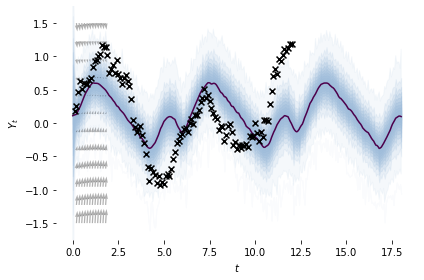

tensor(-0.0933, grad_fn=<MeanBackward0>)


 50%|█████     | 101/200 [02:57<03:21,  2.03s/it]

tensor(-0.1240, grad_fn=<MeanBackward0>)


 51%|█████     | 102/200 [02:59<03:14,  1.98s/it]

tensor(-0.1258, grad_fn=<MeanBackward0>)


 52%|█████▏    | 103/200 [03:01<03:08,  1.95s/it]

tensor(-0.1082, grad_fn=<MeanBackward0>)


 52%|█████▏    | 104/200 [03:03<03:02,  1.90s/it]

tensor(-0.0880, grad_fn=<MeanBackward0>)


 52%|█████▎    | 105/200 [03:05<02:59,  1.89s/it]

tensor(-0.0794, grad_fn=<MeanBackward0>)


 53%|█████▎    | 106/200 [03:06<02:55,  1.87s/it]

tensor(-0.1061, grad_fn=<MeanBackward0>)


 54%|█████▎    | 107/200 [03:08<02:51,  1.84s/it]

tensor(-0.0943, grad_fn=<MeanBackward0>)


 54%|█████▍    | 108/200 [03:10<02:47,  1.82s/it]

tensor(-0.0826, grad_fn=<MeanBackward0>)


 55%|█████▍    | 109/200 [03:12<02:43,  1.80s/it]

tensor(-0.0805, grad_fn=<MeanBackward0>)


 55%|█████▌    | 110/200 [03:13<02:40,  1.78s/it]

tensor(-0.0928, grad_fn=<MeanBackward0>)


 56%|█████▌    | 111/200 [03:15<02:36,  1.76s/it]

tensor(-0.0943, grad_fn=<MeanBackward0>)


 56%|█████▌    | 112/200 [03:17<02:34,  1.75s/it]

tensor(-0.0827, grad_fn=<MeanBackward0>)


 56%|█████▋    | 113/200 [03:19<02:32,  1.75s/it]

tensor(-0.0963, grad_fn=<MeanBackward0>)


 57%|█████▋    | 114/200 [03:21<02:34,  1.79s/it]

tensor(-0.1030, grad_fn=<MeanBackward0>)


 57%|█████▊    | 115/200 [03:22<02:32,  1.80s/it]

tensor(-0.0924, grad_fn=<MeanBackward0>)


 58%|█████▊    | 116/200 [03:24<02:30,  1.79s/it]

tensor(-0.1066, grad_fn=<MeanBackward0>)


 58%|█████▊    | 117/200 [03:26<02:27,  1.78s/it]

tensor(-0.1049, grad_fn=<MeanBackward0>)


 59%|█████▉    | 118/200 [03:28<02:24,  1.77s/it]

tensor(-0.0665, grad_fn=<MeanBackward0>)


 60%|█████▉    | 119/200 [03:29<02:24,  1.78s/it]

tensor(-0.1210, grad_fn=<MeanBackward0>)


 60%|██████    | 120/200 [03:31<02:20,  1.75s/it]

tensor(-0.1277, grad_fn=<MeanBackward0>)


 60%|██████    | 121/200 [03:33<02:16,  1.73s/it]

tensor(-0.1285, grad_fn=<MeanBackward0>)


 61%|██████    | 122/200 [03:35<02:13,  1.72s/it]

tensor(-0.1136, grad_fn=<MeanBackward0>)


 62%|██████▏   | 123/200 [03:36<02:12,  1.71s/it]

tensor(-0.1320, grad_fn=<MeanBackward0>)


 62%|██████▏   | 124/200 [03:38<02:09,  1.71s/it]

tensor(-0.1198, grad_fn=<MeanBackward0>)


 62%|██████▎   | 125/200 [03:40<02:07,  1.70s/it]

tensor(-0.1036, grad_fn=<MeanBackward0>)


 63%|██████▎   | 126/200 [03:41<02:05,  1.70s/it]

tensor(-0.1083, grad_fn=<MeanBackward0>)


 64%|██████▎   | 127/200 [03:43<02:03,  1.69s/it]

tensor(-0.0737, grad_fn=<MeanBackward0>)


 64%|██████▍   | 128/200 [03:45<02:01,  1.69s/it]

tensor(-0.1256, grad_fn=<MeanBackward0>)


 64%|██████▍   | 129/200 [03:46<02:00,  1.69s/it]

tensor(-0.1287, grad_fn=<MeanBackward0>)


 65%|██████▌   | 130/200 [03:48<01:58,  1.69s/it]

tensor(-0.0931, grad_fn=<MeanBackward0>)


 66%|██████▌   | 131/200 [03:50<01:56,  1.69s/it]

tensor(-0.1521, grad_fn=<MeanBackward0>)


 66%|██████▌   | 132/200 [03:51<01:54,  1.68s/it]

tensor(-0.0869, grad_fn=<MeanBackward0>)


 66%|██████▋   | 133/200 [03:53<01:52,  1.68s/it]

tensor(-0.0772, grad_fn=<MeanBackward0>)


 67%|██████▋   | 134/200 [03:55<01:51,  1.69s/it]

tensor(-0.1163, grad_fn=<MeanBackward0>)


 68%|██████▊   | 135/200 [03:56<01:50,  1.69s/it]

tensor(-0.0921, grad_fn=<MeanBackward0>)


 68%|██████▊   | 136/200 [03:58<01:48,  1.69s/it]

tensor(-0.1440, grad_fn=<MeanBackward0>)


 68%|██████▊   | 137/200 [04:00<01:46,  1.69s/it]

tensor(-0.0755, grad_fn=<MeanBackward0>)


 69%|██████▉   | 138/200 [04:02<01:46,  1.71s/it]

tensor(-0.1042, grad_fn=<MeanBackward0>)


 70%|██████▉   | 139/200 [04:03<01:45,  1.72s/it]

tensor(-0.1088, grad_fn=<MeanBackward0>)


 70%|███████   | 140/200 [04:05<01:43,  1.72s/it]

tensor(-0.1034, grad_fn=<MeanBackward0>)


 70%|███████   | 141/200 [04:07<01:42,  1.74s/it]

tensor(-0.0971, grad_fn=<MeanBackward0>)


 71%|███████   | 142/200 [04:09<01:40,  1.73s/it]

tensor(-0.1511, grad_fn=<MeanBackward0>)


 72%|███████▏  | 143/200 [04:10<01:38,  1.72s/it]

tensor(-0.1051, grad_fn=<MeanBackward0>)


 72%|███████▏  | 144/200 [04:12<01:35,  1.71s/it]

tensor(-0.1233, grad_fn=<MeanBackward0>)


 72%|███████▎  | 145/200 [04:14<01:33,  1.70s/it]

tensor(-0.0926, grad_fn=<MeanBackward0>)


 73%|███████▎  | 146/200 [04:15<01:31,  1.70s/it]

tensor(-0.0982, grad_fn=<MeanBackward0>)


 74%|███████▎  | 147/200 [04:17<01:30,  1.70s/it]

tensor(-0.1003, grad_fn=<MeanBackward0>)


 74%|███████▍  | 148/200 [04:19<01:28,  1.70s/it]

tensor(-0.0658, grad_fn=<MeanBackward0>)


 74%|███████▍  | 149/200 [04:20<01:26,  1.70s/it]

tensor(-0.1236, grad_fn=<MeanBackward0>)


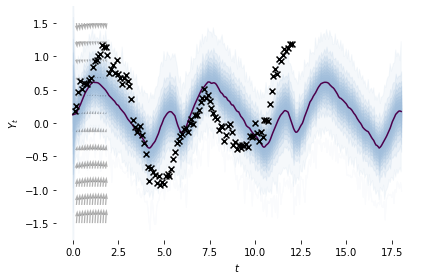

 75%|███████▌  | 150/200 [04:23<01:40,  2.02s/it]

tensor(-0.1220, grad_fn=<MeanBackward0>)


 76%|███████▌  | 151/200 [04:25<01:36,  1.96s/it]

tensor(-0.1053, grad_fn=<MeanBackward0>)


 76%|███████▌  | 152/200 [04:27<01:32,  1.94s/it]

tensor(-0.0855, grad_fn=<MeanBackward0>)


 76%|███████▋  | 153/200 [04:29<01:29,  1.90s/it]

tensor(-0.1153, grad_fn=<MeanBackward0>)


 77%|███████▋  | 154/200 [04:31<01:26,  1.88s/it]

tensor(-0.1298, grad_fn=<MeanBackward0>)


 78%|███████▊  | 155/200 [04:32<01:23,  1.86s/it]

tensor(-0.1101, grad_fn=<MeanBackward0>)


 78%|███████▊  | 156/200 [04:34<01:19,  1.81s/it]

tensor(-0.1145, grad_fn=<MeanBackward0>)


 78%|███████▊  | 157/200 [04:36<01:16,  1.77s/it]

tensor(-0.1381, grad_fn=<MeanBackward0>)


 79%|███████▉  | 158/200 [04:37<01:13,  1.74s/it]

tensor(-0.1341, grad_fn=<MeanBackward0>)


 80%|███████▉  | 159/200 [04:39<01:10,  1.72s/it]

tensor(-0.1119, grad_fn=<MeanBackward0>)


 80%|████████  | 160/200 [04:41<01:08,  1.72s/it]

tensor(-0.1033, grad_fn=<MeanBackward0>)


 80%|████████  | 161/200 [04:43<01:06,  1.71s/it]

tensor(-0.0836, grad_fn=<MeanBackward0>)


 81%|████████  | 162/200 [04:44<01:05,  1.71s/it]

tensor(-0.0915, grad_fn=<MeanBackward0>)


 82%|████████▏ | 163/200 [04:46<01:03,  1.70s/it]

tensor(-0.1153, grad_fn=<MeanBackward0>)


 82%|████████▏ | 164/200 [04:48<01:00,  1.69s/it]

tensor(-0.0950, grad_fn=<MeanBackward0>)


 82%|████████▎ | 165/200 [04:49<00:59,  1.70s/it]

tensor(-0.1088, grad_fn=<MeanBackward0>)


 83%|████████▎ | 166/200 [04:51<00:59,  1.74s/it]

tensor(-0.0855, grad_fn=<MeanBackward0>)


 84%|████████▎ | 167/200 [04:53<00:58,  1.77s/it]

tensor(-0.1308, grad_fn=<MeanBackward0>)


 84%|████████▍ | 168/200 [04:55<00:56,  1.78s/it]

tensor(-0.1048, grad_fn=<MeanBackward0>)


 84%|████████▍ | 169/200 [04:57<00:55,  1.78s/it]

tensor(-0.1298, grad_fn=<MeanBackward0>)


 85%|████████▌ | 170/200 [04:58<00:53,  1.79s/it]

tensor(-0.0930, grad_fn=<MeanBackward0>)


 86%|████████▌ | 171/200 [05:00<00:51,  1.77s/it]

tensor(-0.1090, grad_fn=<MeanBackward0>)


 86%|████████▌ | 172/200 [05:02<00:49,  1.78s/it]

tensor(-0.1199, grad_fn=<MeanBackward0>)


 86%|████████▋ | 173/200 [05:04<00:47,  1.77s/it]

tensor(-0.0898, grad_fn=<MeanBackward0>)


 87%|████████▋ | 174/200 [05:05<00:45,  1.75s/it]

tensor(-0.1106, grad_fn=<MeanBackward0>)


 88%|████████▊ | 175/200 [05:07<00:43,  1.73s/it]

tensor(-0.0808, grad_fn=<MeanBackward0>)


 88%|████████▊ | 176/200 [05:09<00:41,  1.74s/it]

tensor(-0.1236, grad_fn=<MeanBackward0>)


 88%|████████▊ | 177/200 [05:11<00:40,  1.76s/it]

tensor(-0.1313, grad_fn=<MeanBackward0>)


 89%|████████▉ | 178/200 [05:12<00:39,  1.79s/it]

tensor(-0.0861, grad_fn=<MeanBackward0>)


 90%|████████▉ | 179/200 [05:14<00:37,  1.80s/it]

tensor(-0.0854, grad_fn=<MeanBackward0>)


 90%|█████████ | 180/200 [05:16<00:36,  1.80s/it]

tensor(-0.1189, grad_fn=<MeanBackward0>)
tensor(-0.0931, grad_fn=<MeanBackward0>)


 90%|█████████ | 181/200 [05:18<00:34,  1.79s/it]

tensor(-0.0841, grad_fn=<MeanBackward0>)


 91%|█████████ | 182/200 [05:20<00:33,  1.86s/it]

tensor(-0.0746, grad_fn=<MeanBackward0>)


 92%|█████████▏| 184/200 [05:24<00:30,  1.88s/it]

tensor(-0.1122, grad_fn=<MeanBackward0>)


 92%|█████████▎| 185/200 [05:25<00:27,  1.85s/it]

tensor(-0.0992, grad_fn=<MeanBackward0>)


 93%|█████████▎| 186/200 [05:27<00:25,  1.81s/it]

tensor(-0.1057, grad_fn=<MeanBackward0>)


 94%|█████████▎| 187/200 [05:29<00:22,  1.77s/it]

tensor(-0.1046, grad_fn=<MeanBackward0>)


 94%|█████████▍| 188/200 [05:31<00:21,  1.76s/it]

tensor(-0.0967, grad_fn=<MeanBackward0>)


 94%|█████████▍| 189/200 [05:32<00:19,  1.75s/it]

tensor(-0.1149, grad_fn=<MeanBackward0>)


 95%|█████████▌| 190/200 [05:34<00:17,  1.77s/it]

tensor(-0.1219, grad_fn=<MeanBackward0>)


 96%|█████████▌| 191/200 [05:36<00:15,  1.77s/it]

tensor(-0.0940, grad_fn=<MeanBackward0>)


 96%|█████████▌| 192/200 [05:38<00:14,  1.77s/it]

tensor(-0.1058, grad_fn=<MeanBackward0>)


 96%|█████████▋| 193/200 [05:39<00:12,  1.75s/it]

tensor(-0.0900, grad_fn=<MeanBackward0>)


 97%|█████████▋| 194/200 [05:41<00:10,  1.74s/it]

tensor(-0.0829, grad_fn=<MeanBackward0>)


 98%|█████████▊| 195/200 [05:43<00:08,  1.78s/it]

tensor(-0.1227, grad_fn=<MeanBackward0>)


 98%|█████████▊| 196/200 [05:45<00:07,  1.79s/it]

tensor(-0.0703, grad_fn=<MeanBackward0>)


 98%|█████████▊| 197/200 [05:46<00:05,  1.77s/it]

tensor(-0.1143, grad_fn=<MeanBackward0>)


 99%|█████████▉| 198/200 [05:48<00:03,  1.76s/it]

tensor(-0.0829, grad_fn=<MeanBackward0>)


100%|█████████▉| 199/200 [05:50<00:01,  1.78s/it]

tensor(-0.0916, grad_fn=<MeanBackward0>)


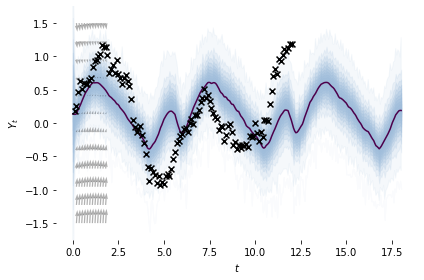

100%|██████████| 200/200 [05:53<00:00,  1.77s/it]

tensor(-0.1019, grad_fn=<MeanBackward0>)


In [251]:
model_1 = LatentSDE().to(device)
original_logpy_list = main_1(model_1)

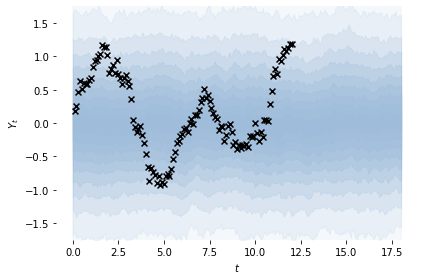

  0%|          | 0/200 [00:00<?, ?it/s]

tensor(-0.0835, grad_fn=<MeanBackward0>)


  0%|          | 1/200 [00:04<13:17,  4.01s/it]

tensor(-0.0845, grad_fn=<MeanBackward0>)


  1%|          | 2/200 [00:08<13:36,  4.12s/it]

tensor(-0.0580, grad_fn=<MeanBackward0>)


  2%|▏         | 3/200 [00:12<13:30,  4.12s/it]

tensor(-0.0799, grad_fn=<MeanBackward0>)


  2%|▏         | 4/200 [00:16<13:23,  4.10s/it]

tensor(-0.0641, grad_fn=<MeanBackward0>)


  2%|▎         | 5/200 [00:20<13:13,  4.07s/it]

tensor(-0.0684, grad_fn=<MeanBackward0>)


  3%|▎         | 6/200 [00:24<13:07,  4.06s/it]

tensor(-0.1346, grad_fn=<MeanBackward0>)


  4%|▎         | 7/200 [00:28<13:02,  4.05s/it]

tensor(-0.1308, grad_fn=<MeanBackward0>)


  4%|▍         | 8/200 [00:32<12:56,  4.04s/it]

tensor(-0.1189, grad_fn=<MeanBackward0>)


  4%|▍         | 9/200 [00:36<12:52,  4.04s/it]

tensor(-0.1830, grad_fn=<MeanBackward0>)


  5%|▌         | 10/200 [00:40<12:44,  4.02s/it]

tensor(-0.2298, grad_fn=<MeanBackward0>)


  6%|▌         | 11/200 [00:44<12:40,  4.03s/it]

tensor(-0.2301, grad_fn=<MeanBackward0>)


  6%|▌         | 12/200 [00:48<12:35,  4.02s/it]

tensor(-0.3193, grad_fn=<MeanBackward0>)


  6%|▋         | 13/200 [00:52<12:31,  4.02s/it]

tensor(-0.2545, grad_fn=<MeanBackward0>)


  7%|▋         | 14/200 [00:56<12:28,  4.02s/it]

tensor(-0.2134, grad_fn=<MeanBackward0>)


  8%|▊         | 15/200 [01:00<12:24,  4.02s/it]

tensor(-0.2098, grad_fn=<MeanBackward0>)


  8%|▊         | 16/200 [01:04<12:25,  4.05s/it]

tensor(-0.1616, grad_fn=<MeanBackward0>)


  8%|▊         | 17/200 [01:08<12:20,  4.04s/it]

tensor(-0.1442, grad_fn=<MeanBackward0>)


  9%|▉         | 18/200 [01:13<12:49,  4.23s/it]

tensor(-0.1386, grad_fn=<MeanBackward0>)


 10%|▉         | 19/200 [01:17<12:46,  4.24s/it]

tensor(-0.1419, grad_fn=<MeanBackward0>)


 10%|█         | 20/200 [01:22<12:40,  4.22s/it]

tensor(-0.1267, grad_fn=<MeanBackward0>)


 10%|█         | 21/200 [01:26<12:27,  4.17s/it]

tensor(-0.1471, grad_fn=<MeanBackward0>)


 11%|█         | 22/200 [01:30<12:18,  4.15s/it]

tensor(-0.1535, grad_fn=<MeanBackward0>)


 12%|█▏        | 23/200 [01:34<12:08,  4.12s/it]

tensor(-0.1170, grad_fn=<MeanBackward0>)


 12%|█▏        | 24/200 [01:38<12:13,  4.17s/it]

tensor(-0.0885, grad_fn=<MeanBackward0>)


 12%|█▎        | 25/200 [01:42<12:05,  4.14s/it]

tensor(-0.1289, grad_fn=<MeanBackward0>)


 13%|█▎        | 26/200 [01:46<11:56,  4.12s/it]

tensor(-0.1020, grad_fn=<MeanBackward0>)


 14%|█▎        | 27/200 [01:50<11:49,  4.10s/it]

tensor(-0.1316, grad_fn=<MeanBackward0>)


 14%|█▍        | 28/200 [01:54<11:52,  4.14s/it]

tensor(-0.1041, grad_fn=<MeanBackward0>)


 14%|█▍        | 29/200 [01:58<11:43,  4.11s/it]

tensor(-0.0665, grad_fn=<MeanBackward0>)


 15%|█▌        | 30/200 [02:03<11:36,  4.10s/it]

tensor(-0.1096, grad_fn=<MeanBackward0>)


 16%|█▌        | 31/200 [02:07<11:40,  4.14s/it]

tensor(-0.1144, grad_fn=<MeanBackward0>)


 16%|█▌        | 32/200 [02:11<11:40,  4.17s/it]

tensor(-0.1275, grad_fn=<MeanBackward0>)


 16%|█▋        | 33/200 [02:15<11:31,  4.14s/it]

tensor(-0.1186, grad_fn=<MeanBackward0>)


 17%|█▋        | 34/200 [02:19<11:19,  4.10s/it]

tensor(-0.0876, grad_fn=<MeanBackward0>)


 18%|█▊        | 35/200 [02:23<11:14,  4.09s/it]

tensor(-0.1338, grad_fn=<MeanBackward0>)


 18%|█▊        | 36/200 [02:27<11:11,  4.09s/it]

tensor(-0.1084, grad_fn=<MeanBackward0>)


 18%|█▊        | 37/200 [02:31<11:12,  4.13s/it]

tensor(-0.1146, grad_fn=<MeanBackward0>)


 19%|█▉        | 38/200 [02:35<11:03,  4.09s/it]

tensor(-0.1280, grad_fn=<MeanBackward0>)


 20%|█▉        | 39/200 [02:40<10:56,  4.08s/it]

tensor(-0.0875, grad_fn=<MeanBackward0>)


 20%|██        | 40/200 [02:44<10:47,  4.05s/it]

tensor(-0.1706, grad_fn=<MeanBackward0>)


 20%|██        | 41/200 [02:48<10:42,  4.04s/it]

tensor(-0.1282, grad_fn=<MeanBackward0>)


 21%|██        | 42/200 [02:52<10:38,  4.04s/it]

tensor(-0.1314, grad_fn=<MeanBackward0>)


 22%|██▏       | 43/200 [02:56<10:34,  4.04s/it]

tensor(-0.1129, grad_fn=<MeanBackward0>)


 22%|██▏       | 44/200 [03:00<10:30,  4.04s/it]

tensor(-0.1188, grad_fn=<MeanBackward0>)


 22%|██▎       | 45/200 [03:04<10:31,  4.07s/it]

tensor(-0.1300, grad_fn=<MeanBackward0>)


 23%|██▎       | 46/200 [03:08<10:26,  4.07s/it]

tensor(-0.1364, grad_fn=<MeanBackward0>)


 24%|██▎       | 47/200 [03:12<10:23,  4.08s/it]

tensor(-0.1318, grad_fn=<MeanBackward0>)


 24%|██▍       | 48/200 [03:16<10:18,  4.07s/it]

tensor(-0.1204, grad_fn=<MeanBackward0>)


 24%|██▍       | 49/200 [03:20<10:10,  4.04s/it]

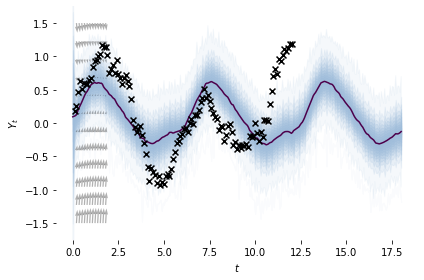

tensor(-0.1084, grad_fn=<MeanBackward0>)


 25%|██▌       | 50/200 [03:25<11:04,  4.43s/it]

tensor(-0.1477, grad_fn=<MeanBackward0>)


 26%|██▌       | 51/200 [03:30<10:49,  4.36s/it]

tensor(-0.1117, grad_fn=<MeanBackward0>)


 26%|██▌       | 52/200 [03:34<10:41,  4.34s/it]

tensor(-0.1493, grad_fn=<MeanBackward0>)


 26%|██▋       | 53/200 [03:38<10:25,  4.26s/it]

tensor(-0.0965, grad_fn=<MeanBackward0>)


 27%|██▋       | 54/200 [03:42<10:13,  4.20s/it]

tensor(-0.1213, grad_fn=<MeanBackward0>)


 28%|██▊       | 55/200 [03:46<10:00,  4.14s/it]

tensor(-0.0949, grad_fn=<MeanBackward0>)


 28%|██▊       | 56/200 [03:50<09:52,  4.11s/it]

tensor(-0.1115, grad_fn=<MeanBackward0>)


 28%|██▊       | 57/200 [03:54<09:44,  4.09s/it]

tensor(-0.0825, grad_fn=<MeanBackward0>)


 29%|██▉       | 58/200 [03:58<09:39,  4.08s/it]

tensor(-0.1242, grad_fn=<MeanBackward0>)


 30%|██▉       | 59/200 [04:02<09:34,  4.07s/it]

tensor(-0.1134, grad_fn=<MeanBackward0>)


 30%|███       | 60/200 [04:06<09:36,  4.12s/it]

tensor(-0.1371, grad_fn=<MeanBackward0>)


 30%|███       | 61/200 [04:11<09:38,  4.16s/it]

tensor(-0.1012, grad_fn=<MeanBackward0>)


 31%|███       | 62/200 [04:15<09:29,  4.12s/it]

tensor(-0.1323, grad_fn=<MeanBackward0>)


 32%|███▏      | 63/200 [04:19<09:21,  4.10s/it]

tensor(-0.1236, grad_fn=<MeanBackward0>)


 32%|███▏      | 64/200 [04:23<09:16,  4.09s/it]

tensor(-0.1269, grad_fn=<MeanBackward0>)


 32%|███▎      | 65/200 [04:27<09:11,  4.08s/it]

tensor(-0.1060, grad_fn=<MeanBackward0>)


 33%|███▎      | 66/200 [04:31<09:06,  4.08s/it]

tensor(-0.1178, grad_fn=<MeanBackward0>)


 34%|███▎      | 67/200 [04:35<09:01,  4.07s/it]

tensor(-0.1412, grad_fn=<MeanBackward0>)


 34%|███▍      | 68/200 [04:39<08:53,  4.04s/it]

tensor(-0.1109, grad_fn=<MeanBackward0>)


 34%|███▍      | 69/200 [04:43<08:50,  4.05s/it]

tensor(-0.1015, grad_fn=<MeanBackward0>)


 35%|███▌      | 70/200 [04:47<08:47,  4.05s/it]

tensor(-0.0933, grad_fn=<MeanBackward0>)


 36%|███▌      | 71/200 [04:51<08:44,  4.06s/it]

tensor(-0.0719, grad_fn=<MeanBackward0>)


 36%|███▌      | 72/200 [04:55<08:39,  4.06s/it]

tensor(-0.1133, grad_fn=<MeanBackward0>)


 36%|███▋      | 73/200 [04:59<08:35,  4.06s/it]

tensor(-0.1211, grad_fn=<MeanBackward0>)


 37%|███▋      | 74/200 [05:03<08:31,  4.06s/it]

tensor(-0.1052, grad_fn=<MeanBackward0>)


 38%|███▊      | 75/200 [05:07<08:25,  4.05s/it]

tensor(-0.1187, grad_fn=<MeanBackward0>)


 38%|███▊      | 76/200 [05:11<08:20,  4.04s/it]

tensor(-0.1517, grad_fn=<MeanBackward0>)


 38%|███▊      | 77/200 [05:15<08:15,  4.03s/it]

tensor(-0.1079, grad_fn=<MeanBackward0>)


 39%|███▉      | 78/200 [05:19<08:12,  4.04s/it]

tensor(-0.1202, grad_fn=<MeanBackward0>)


 40%|███▉      | 79/200 [05:24<08:08,  4.04s/it]

tensor(-0.0796, grad_fn=<MeanBackward0>)


 40%|████      | 80/200 [05:28<08:03,  4.03s/it]

tensor(-0.1072, grad_fn=<MeanBackward0>)


 40%|████      | 81/200 [05:31<07:57,  4.01s/it]

tensor(-0.1247, grad_fn=<MeanBackward0>)


 41%|████      | 82/200 [05:36<07:55,  4.03s/it]

tensor(-0.1212, grad_fn=<MeanBackward0>)


 42%|████▏     | 83/200 [05:40<07:52,  4.04s/it]

tensor(-0.1040, grad_fn=<MeanBackward0>)


 42%|████▏     | 84/200 [05:44<07:49,  4.05s/it]

tensor(-0.1114, grad_fn=<MeanBackward0>)


 42%|████▎     | 85/200 [05:48<07:43,  4.03s/it]

tensor(-0.0971, grad_fn=<MeanBackward0>)


 43%|████▎     | 86/200 [05:52<07:37,  4.02s/it]

tensor(-0.1164, grad_fn=<MeanBackward0>)


 44%|████▎     | 87/200 [05:56<07:34,  4.02s/it]

tensor(-0.1018, grad_fn=<MeanBackward0>)


 44%|████▍     | 88/200 [06:00<07:34,  4.06s/it]

tensor(-0.0973, grad_fn=<MeanBackward0>)


 44%|████▍     | 89/200 [06:04<07:32,  4.08s/it]

tensor(-0.1171, grad_fn=<MeanBackward0>)


 45%|████▌     | 90/200 [06:08<07:29,  4.09s/it]

tensor(-0.0955, grad_fn=<MeanBackward0>)


 46%|████▌     | 91/200 [06:12<07:25,  4.09s/it]

tensor(-0.1492, grad_fn=<MeanBackward0>)


 46%|████▌     | 92/200 [06:16<07:27,  4.14s/it]

tensor(-0.1177, grad_fn=<MeanBackward0>)


 46%|████▋     | 93/200 [06:21<07:21,  4.13s/it]

tensor(-0.1379, grad_fn=<MeanBackward0>)


 47%|████▋     | 94/200 [06:25<07:14,  4.10s/it]

tensor(-0.0773, grad_fn=<MeanBackward0>)


 48%|████▊     | 95/200 [06:29<07:12,  4.12s/it]

tensor(-0.1112, grad_fn=<MeanBackward0>)


 48%|████▊     | 96/200 [06:33<07:15,  4.19s/it]

tensor(-0.1304, grad_fn=<MeanBackward0>)


 48%|████▊     | 97/200 [06:37<07:10,  4.17s/it]

tensor(-0.1227, grad_fn=<MeanBackward0>)


 49%|████▉     | 98/200 [06:41<07:07,  4.19s/it]

tensor(-0.1474, grad_fn=<MeanBackward0>)


 50%|████▉     | 99/200 [06:46<07:00,  4.16s/it]

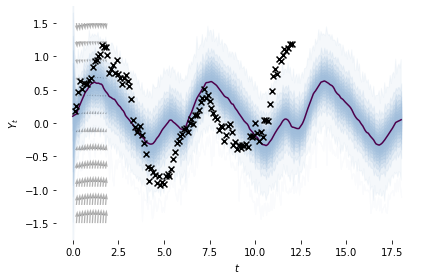

tensor(-0.1251, grad_fn=<MeanBackward0>)


 50%|█████     | 100/200 [06:51<07:28,  4.49s/it]

tensor(-0.0919, grad_fn=<MeanBackward0>)


 50%|█████     | 101/200 [06:55<07:20,  4.45s/it]

tensor(-0.1022, grad_fn=<MeanBackward0>)


 51%|█████     | 102/200 [06:59<07:07,  4.37s/it]

tensor(-0.0913, grad_fn=<MeanBackward0>)


 52%|█████▏    | 103/200 [07:03<06:54,  4.27s/it]

tensor(-0.1164, grad_fn=<MeanBackward0>)


 52%|█████▏    | 104/200 [07:07<06:46,  4.23s/it]

tensor(-0.1019, grad_fn=<MeanBackward0>)


 52%|█████▎    | 105/200 [07:12<06:40,  4.21s/it]

tensor(-0.0939, grad_fn=<MeanBackward0>)


 53%|█████▎    | 106/200 [07:16<06:35,  4.21s/it]

tensor(-0.1134, grad_fn=<MeanBackward0>)


 54%|█████▎    | 107/200 [07:20<06:28,  4.18s/it]

tensor(-0.0714, grad_fn=<MeanBackward0>)


 54%|█████▍    | 108/200 [07:24<06:21,  4.14s/it]

tensor(-0.1324, grad_fn=<MeanBackward0>)


 55%|█████▍    | 109/200 [07:28<06:13,  4.11s/it]

tensor(-0.0996, grad_fn=<MeanBackward0>)


 55%|█████▌    | 110/200 [07:32<06:10,  4.12s/it]

tensor(-0.1167, grad_fn=<MeanBackward0>)


 56%|█████▌    | 111/200 [07:36<06:08,  4.14s/it]

tensor(-0.1003, grad_fn=<MeanBackward0>)


 56%|█████▌    | 112/200 [07:40<06:02,  4.12s/it]

tensor(-0.0685, grad_fn=<MeanBackward0>)


 56%|█████▋    | 113/200 [07:45<06:03,  4.18s/it]

tensor(-0.1146, grad_fn=<MeanBackward0>)


 57%|█████▋    | 114/200 [07:49<05:58,  4.17s/it]

tensor(-0.1261, grad_fn=<MeanBackward0>)


 57%|█████▊    | 115/200 [07:53<05:55,  4.18s/it]

tensor(-0.1024, grad_fn=<MeanBackward0>)


 58%|█████▊    | 116/200 [07:57<05:48,  4.15s/it]

tensor(-0.1231, grad_fn=<MeanBackward0>)


 58%|█████▊    | 117/200 [08:01<05:42,  4.12s/it]

tensor(-0.1060, grad_fn=<MeanBackward0>)


 59%|█████▉    | 118/200 [08:05<05:38,  4.13s/it]

tensor(-0.1210, grad_fn=<MeanBackward0>)


 60%|█████▉    | 119/200 [08:10<05:34,  4.13s/it]

tensor(-0.0715, grad_fn=<MeanBackward0>)


 60%|██████    | 120/200 [08:14<05:30,  4.13s/it]

tensor(-0.1043, grad_fn=<MeanBackward0>)


 60%|██████    | 121/200 [08:18<05:25,  4.12s/it]

tensor(-0.1218, grad_fn=<MeanBackward0>)


 61%|██████    | 122/200 [08:22<05:21,  4.12s/it]

tensor(-0.0939, grad_fn=<MeanBackward0>)


 62%|██████▏   | 123/200 [08:26<05:17,  4.12s/it]

tensor(-0.1414, grad_fn=<MeanBackward0>)


 62%|██████▏   | 124/200 [08:30<05:11,  4.10s/it]

tensor(-0.1466, grad_fn=<MeanBackward0>)


 62%|██████▎   | 125/200 [08:34<05:07,  4.10s/it]

tensor(-0.1170, grad_fn=<MeanBackward0>)


 63%|██████▎   | 126/200 [08:38<05:03,  4.10s/it]

tensor(-0.0915, grad_fn=<MeanBackward0>)


 64%|██████▎   | 127/200 [08:43<05:04,  4.17s/it]

tensor(-0.1251, grad_fn=<MeanBackward0>)


 64%|██████▍   | 128/200 [08:47<04:58,  4.15s/it]

tensor(-0.1162, grad_fn=<MeanBackward0>)


 64%|██████▍   | 129/200 [08:51<04:55,  4.16s/it]

tensor(-0.1187, grad_fn=<MeanBackward0>)


 65%|██████▌   | 130/200 [08:55<04:51,  4.17s/it]

tensor(-0.1163, grad_fn=<MeanBackward0>)


 66%|██████▌   | 131/200 [08:59<04:46,  4.14s/it]

tensor(-0.0997, grad_fn=<MeanBackward0>)


 66%|██████▌   | 132/200 [09:03<04:41,  4.15s/it]

tensor(-0.1121, grad_fn=<MeanBackward0>)


 66%|██████▋   | 133/200 [09:07<04:37,  4.14s/it]

tensor(-0.1121, grad_fn=<MeanBackward0>)


 67%|██████▋   | 134/200 [09:12<04:33,  4.15s/it]

tensor(-0.1125, grad_fn=<MeanBackward0>)


 68%|██████▊   | 135/200 [09:16<04:28,  4.14s/it]

tensor(-0.0993, grad_fn=<MeanBackward0>)


 68%|██████▊   | 136/200 [09:20<04:23,  4.12s/it]

tensor(-0.0950, grad_fn=<MeanBackward0>)


 68%|██████▊   | 137/200 [09:24<04:17,  4.09s/it]

tensor(-0.1143, grad_fn=<MeanBackward0>)


 69%|██████▉   | 138/200 [09:28<04:12,  4.07s/it]

tensor(-0.0998, grad_fn=<MeanBackward0>)


 70%|██████▉   | 139/200 [09:32<04:07,  4.06s/it]

tensor(-0.0966, grad_fn=<MeanBackward0>)


 70%|███████   | 140/200 [09:36<04:08,  4.14s/it]

tensor(-0.0910, grad_fn=<MeanBackward0>)


 70%|███████   | 141/200 [09:40<04:02,  4.11s/it]

tensor(-0.1142, grad_fn=<MeanBackward0>)


 71%|███████   | 142/200 [09:45<04:00,  4.15s/it]

tensor(-0.1247, grad_fn=<MeanBackward0>)


 72%|███████▏  | 143/200 [09:51<04:31,  4.76s/it]

tensor(-0.0933, grad_fn=<MeanBackward0>)


 72%|███████▏  | 144/200 [09:55<04:15,  4.56s/it]

tensor(-0.1032, grad_fn=<MeanBackward0>)


 72%|███████▎  | 145/200 [09:59<04:02,  4.42s/it]

tensor(-0.1138, grad_fn=<MeanBackward0>)


 73%|███████▎  | 146/200 [10:03<03:53,  4.32s/it]

tensor(-0.1054, grad_fn=<MeanBackward0>)


 74%|███████▎  | 147/200 [10:07<03:49,  4.33s/it]

tensor(-0.0936, grad_fn=<MeanBackward0>)


 74%|███████▍  | 148/200 [10:12<03:44,  4.31s/it]

tensor(-0.0852, grad_fn=<MeanBackward0>)


 74%|███████▍  | 149/200 [10:16<03:36,  4.25s/it]

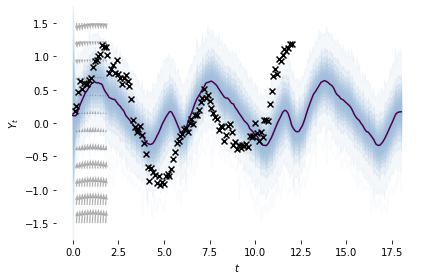

tensor(-0.0905, grad_fn=<MeanBackward0>)


 75%|███████▌  | 150/200 [10:21<03:48,  4.57s/it]

tensor(-0.0886, grad_fn=<MeanBackward0>)


 76%|███████▌  | 151/200 [10:25<03:36,  4.42s/it]

tensor(-0.1146, grad_fn=<MeanBackward0>)


 76%|███████▌  | 152/200 [10:29<03:26,  4.30s/it]

tensor(-0.1264, grad_fn=<MeanBackward0>)


 76%|███████▋  | 153/200 [10:33<03:18,  4.22s/it]

tensor(-0.1206, grad_fn=<MeanBackward0>)


 77%|███████▋  | 154/200 [10:37<03:11,  4.16s/it]

tensor(-0.1189, grad_fn=<MeanBackward0>)


 78%|███████▊  | 155/200 [10:41<03:04,  4.11s/it]

tensor(-0.1378, grad_fn=<MeanBackward0>)


 78%|███████▊  | 156/200 [10:45<02:59,  4.09s/it]

tensor(-0.1164, grad_fn=<MeanBackward0>)


 78%|███████▊  | 157/200 [10:49<02:54,  4.05s/it]

tensor(-0.1199, grad_fn=<MeanBackward0>)


 79%|███████▉  | 158/200 [10:53<02:49,  4.04s/it]

tensor(-0.1016, grad_fn=<MeanBackward0>)


 80%|███████▉  | 159/200 [10:57<02:45,  4.03s/it]

tensor(-0.1384, grad_fn=<MeanBackward0>)


 80%|████████  | 160/200 [11:01<02:41,  4.03s/it]

tensor(-0.1038, grad_fn=<MeanBackward0>)


 80%|████████  | 161/200 [11:05<02:37,  4.04s/it]

tensor(-0.1063, grad_fn=<MeanBackward0>)


 81%|████████  | 162/200 [11:09<02:33,  4.03s/it]

tensor(-0.0948, grad_fn=<MeanBackward0>)


 82%|████████▏ | 163/200 [11:13<02:28,  4.02s/it]

tensor(-0.1300, grad_fn=<MeanBackward0>)


 82%|████████▏ | 164/200 [11:17<02:24,  4.02s/it]

tensor(-0.1367, grad_fn=<MeanBackward0>)


 82%|████████▎ | 165/200 [11:21<02:20,  4.02s/it]

tensor(-0.1004, grad_fn=<MeanBackward0>)


 83%|████████▎ | 166/200 [11:25<02:16,  4.01s/it]

tensor(-0.1183, grad_fn=<MeanBackward0>)


 84%|████████▎ | 167/200 [11:29<02:13,  4.05s/it]

tensor(-0.1031, grad_fn=<MeanBackward0>)


 84%|████████▍ | 168/200 [11:33<02:09,  4.04s/it]

tensor(-0.1192, grad_fn=<MeanBackward0>)


 84%|████████▍ | 169/200 [11:37<02:04,  4.03s/it]

tensor(-0.0690, grad_fn=<MeanBackward0>)


 85%|████████▌ | 170/200 [11:41<02:00,  4.02s/it]

tensor(-0.0907, grad_fn=<MeanBackward0>)


 86%|████████▌ | 171/200 [11:45<01:56,  4.01s/it]

tensor(-0.1006, grad_fn=<MeanBackward0>)


 86%|████████▌ | 172/200 [11:49<01:52,  4.01s/it]

tensor(-0.1277, grad_fn=<MeanBackward0>)


 86%|████████▋ | 173/200 [11:54<01:48,  4.02s/it]

tensor(-0.0853, grad_fn=<MeanBackward0>)


 87%|████████▋ | 174/200 [11:58<01:44,  4.02s/it]

tensor(-0.1079, grad_fn=<MeanBackward0>)


 88%|████████▊ | 175/200 [12:02<01:40,  4.02s/it]

tensor(-0.1528, grad_fn=<MeanBackward0>)


 88%|████████▊ | 176/200 [12:06<01:37,  4.06s/it]

tensor(-0.1043, grad_fn=<MeanBackward0>)


 88%|████████▊ | 177/200 [12:10<01:34,  4.11s/it]

tensor(-0.1069, grad_fn=<MeanBackward0>)


 89%|████████▉ | 178/200 [12:14<01:30,  4.12s/it]

tensor(-0.1187, grad_fn=<MeanBackward0>)


 90%|████████▉ | 179/200 [12:18<01:26,  4.10s/it]

tensor(-0.1047, grad_fn=<MeanBackward0>)


 90%|█████████ | 180/200 [12:22<01:21,  4.08s/it]

tensor(-0.0950, grad_fn=<MeanBackward0>)


 90%|█████████ | 181/200 [12:26<01:17,  4.07s/it]

tensor(-0.1198, grad_fn=<MeanBackward0>)


 91%|█████████ | 182/200 [12:30<01:13,  4.06s/it]

tensor(-0.1214, grad_fn=<MeanBackward0>)


 92%|█████████▏| 183/200 [12:34<01:08,  4.05s/it]

tensor(-0.0772, grad_fn=<MeanBackward0>)


 92%|█████████▏| 184/200 [12:38<01:04,  4.04s/it]

tensor(-0.0986, grad_fn=<MeanBackward0>)


 92%|█████████▎| 185/200 [12:42<01:00,  4.04s/it]

tensor(-0.1059, grad_fn=<MeanBackward0>)


 93%|█████████▎| 186/200 [12:46<00:56,  4.03s/it]

tensor(-0.1376, grad_fn=<MeanBackward0>)


 94%|█████████▎| 187/200 [12:50<00:52,  4.01s/it]

tensor(-0.1251, grad_fn=<MeanBackward0>)


 94%|█████████▍| 188/200 [12:54<00:48,  4.05s/it]

tensor(-0.1000, grad_fn=<MeanBackward0>)


 94%|█████████▍| 189/200 [12:59<00:44,  4.07s/it]

tensor(-0.0966, grad_fn=<MeanBackward0>)


 95%|█████████▌| 190/200 [13:03<00:40,  4.05s/it]

tensor(-0.1093, grad_fn=<MeanBackward0>)


 96%|█████████▌| 191/200 [13:07<00:36,  4.03s/it]

tensor(-0.0889, grad_fn=<MeanBackward0>)


 96%|█████████▌| 192/200 [13:11<00:32,  4.06s/it]

tensor(-0.1294, grad_fn=<MeanBackward0>)


 96%|█████████▋| 193/200 [13:15<00:28,  4.12s/it]

tensor(-0.1057, grad_fn=<MeanBackward0>)


 97%|█████████▋| 194/200 [13:19<00:24,  4.11s/it]

tensor(-0.1110, grad_fn=<MeanBackward0>)


 98%|█████████▊| 195/200 [13:23<00:20,  4.15s/it]

tensor(-0.0983, grad_fn=<MeanBackward0>)


 98%|█████████▊| 196/200 [13:27<00:16,  4.12s/it]

tensor(-0.0961, grad_fn=<MeanBackward0>)


 98%|█████████▊| 197/200 [13:31<00:12,  4.07s/it]

tensor(-0.1036, grad_fn=<MeanBackward0>)


 99%|█████████▉| 198/200 [13:35<00:08,  4.06s/it]

tensor(-0.1275, grad_fn=<MeanBackward0>)


100%|█████████▉| 199/200 [13:39<00:04,  4.03s/it]

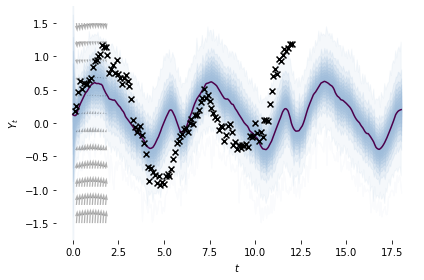

tensor(-0.1064, grad_fn=<MeanBackward0>)


100%|██████████| 200/200 [13:44<00:00,  4.12s/it]


In [253]:
model_1 = LatentSDE().to(device)
l2_logpy_list = main_1(model_1,conditional=True)

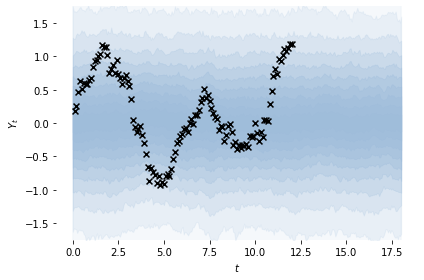

  0%|          | 0/200 [00:00<?, ?it/s]

tensor(-0.1112, grad_fn=<MeanBackward0>)


  0%|          | 1/200 [00:04<13:22,  4.03s/it]

tensor(-0.0415, grad_fn=<MeanBackward0>)


  1%|          | 2/200 [00:08<13:30,  4.09s/it]

tensor(-0.0637, grad_fn=<MeanBackward0>)


  2%|▏         | 3/200 [00:12<13:32,  4.12s/it]

tensor(-0.0589, grad_fn=<MeanBackward0>)


  2%|▏         | 4/200 [00:16<13:42,  4.20s/it]

tensor(-0.0646, grad_fn=<MeanBackward0>)


  2%|▎         | 5/200 [00:21<13:47,  4.25s/it]

tensor(-0.0486, grad_fn=<MeanBackward0>)


  3%|▎         | 6/200 [00:25<13:35,  4.20s/it]

tensor(-0.0860, grad_fn=<MeanBackward0>)


  4%|▎         | 7/200 [00:29<13:39,  4.25s/it]

tensor(-0.0483, grad_fn=<MeanBackward0>)


  4%|▍         | 8/200 [00:33<13:34,  4.24s/it]

tensor(-0.0469, grad_fn=<MeanBackward0>)


  4%|▍         | 9/200 [00:38<13:51,  4.36s/it]

tensor(-0.0581, grad_fn=<MeanBackward0>)


  5%|▌         | 10/200 [00:43<14:12,  4.49s/it]

tensor(-0.0392, grad_fn=<MeanBackward0>)


  6%|▌         | 11/200 [00:47<13:59,  4.44s/it]

tensor(-0.0505, grad_fn=<MeanBackward0>)


  6%|▌         | 12/200 [00:52<13:58,  4.46s/it]

tensor(-0.0616, grad_fn=<MeanBackward0>)


  6%|▋         | 13/200 [00:56<13:34,  4.36s/it]

tensor(-0.0823, grad_fn=<MeanBackward0>)


  7%|▋         | 14/200 [01:00<13:15,  4.28s/it]

tensor(-0.0994, grad_fn=<MeanBackward0>)


  8%|▊         | 15/200 [01:04<12:59,  4.21s/it]

tensor(-0.0717, grad_fn=<MeanBackward0>)


  8%|▊         | 16/200 [01:08<12:54,  4.21s/it]

tensor(-0.0593, grad_fn=<MeanBackward0>)


  8%|▊         | 17/200 [01:13<13:40,  4.48s/it]

tensor(-0.0665, grad_fn=<MeanBackward0>)


  9%|▉         | 18/200 [01:17<13:12,  4.35s/it]

tensor(-0.0791, grad_fn=<MeanBackward0>)


 10%|▉         | 19/200 [01:21<12:52,  4.27s/it]

tensor(-0.0672, grad_fn=<MeanBackward0>)


 10%|█         | 20/200 [01:25<12:37,  4.21s/it]

tensor(-0.0614, grad_fn=<MeanBackward0>)


 10%|█         | 21/200 [01:29<12:26,  4.17s/it]

tensor(-0.0725, grad_fn=<MeanBackward0>)


 11%|█         | 22/200 [01:34<12:15,  4.13s/it]

tensor(-0.0911, grad_fn=<MeanBackward0>)


 12%|█▏        | 23/200 [01:38<12:08,  4.11s/it]

tensor(-0.0785, grad_fn=<MeanBackward0>)


 12%|█▏        | 24/200 [01:42<12:00,  4.10s/it]

tensor(-0.0655, grad_fn=<MeanBackward0>)


 12%|█▎        | 25/200 [01:46<11:56,  4.09s/it]

tensor(-0.0614, grad_fn=<MeanBackward0>)


 13%|█▎        | 26/200 [01:50<11:50,  4.08s/it]

tensor(-0.0821, grad_fn=<MeanBackward0>)


 14%|█▎        | 27/200 [01:54<11:43,  4.07s/it]

tensor(-0.0674, grad_fn=<MeanBackward0>)


 14%|█▍        | 28/200 [01:58<11:38,  4.06s/it]

tensor(-0.0728, grad_fn=<MeanBackward0>)


 14%|█▍        | 29/200 [02:02<11:35,  4.07s/it]

tensor(-0.0682, grad_fn=<MeanBackward0>)


 15%|█▌        | 30/200 [02:06<11:33,  4.08s/it]

tensor(-0.0539, grad_fn=<MeanBackward0>)


 16%|█▌        | 31/200 [02:10<11:29,  4.08s/it]

tensor(-0.0722, grad_fn=<MeanBackward0>)


 16%|█▌        | 32/200 [02:14<11:35,  4.14s/it]

tensor(-0.0328, grad_fn=<MeanBackward0>)


 16%|█▋        | 33/200 [02:19<11:38,  4.18s/it]

tensor(-0.0860, grad_fn=<MeanBackward0>)


 17%|█▋        | 34/200 [02:23<11:33,  4.18s/it]

tensor(-0.0789, grad_fn=<MeanBackward0>)


 18%|█▊        | 35/200 [02:27<11:24,  4.15s/it]

tensor(-0.0524, grad_fn=<MeanBackward0>)


 18%|█▊        | 36/200 [02:31<11:17,  4.13s/it]

tensor(-0.0504, grad_fn=<MeanBackward0>)


 18%|█▊        | 37/200 [02:35<11:11,  4.12s/it]

tensor(-0.0636, grad_fn=<MeanBackward0>)


 19%|█▉        | 38/200 [02:39<11:07,  4.12s/it]

tensor(-0.0793, grad_fn=<MeanBackward0>)


 20%|█▉        | 39/200 [02:43<11:02,  4.12s/it]

tensor(-0.0692, grad_fn=<MeanBackward0>)


 20%|██        | 40/200 [02:47<10:57,  4.11s/it]

tensor(-0.0811, grad_fn=<MeanBackward0>)


 20%|██        | 41/200 [02:52<10:52,  4.10s/it]

tensor(-0.0615, grad_fn=<MeanBackward0>)


 21%|██        | 42/200 [02:56<10:45,  4.08s/it]

tensor(-0.1023, grad_fn=<MeanBackward0>)


 22%|██▏       | 43/200 [03:00<10:39,  4.08s/it]

tensor(-0.0881, grad_fn=<MeanBackward0>)


 22%|██▏       | 44/200 [03:04<10:35,  4.07s/it]

tensor(-0.0819, grad_fn=<MeanBackward0>)


 22%|██▎       | 45/200 [03:08<10:29,  4.06s/it]

tensor(-0.0853, grad_fn=<MeanBackward0>)


 23%|██▎       | 46/200 [03:12<10:24,  4.06s/it]

tensor(-0.0492, grad_fn=<MeanBackward0>)


 24%|██▎       | 47/200 [03:16<10:19,  4.05s/it]

tensor(-0.0658, grad_fn=<MeanBackward0>)


 24%|██▍       | 48/200 [03:20<10:14,  4.04s/it]

tensor(-0.0770, grad_fn=<MeanBackward0>)


 24%|██▍       | 49/200 [03:24<10:10,  4.05s/it]

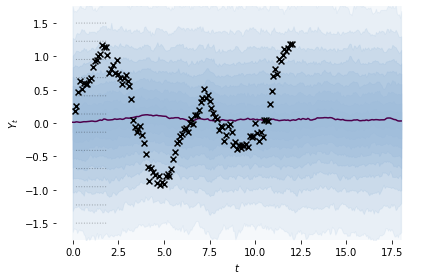

tensor(-0.0405, grad_fn=<MeanBackward0>)


 25%|██▌       | 50/200 [03:29<10:57,  4.38s/it]

tensor(-0.1127, grad_fn=<MeanBackward0>)


 26%|██▌       | 51/200 [03:33<10:38,  4.29s/it]

tensor(-0.0579, grad_fn=<MeanBackward0>)


 26%|██▌       | 52/200 [03:37<10:23,  4.22s/it]

tensor(-0.0773, grad_fn=<MeanBackward0>)


 26%|██▋       | 53/200 [03:41<10:14,  4.18s/it]

tensor(-0.0515, grad_fn=<MeanBackward0>)


 27%|██▋       | 54/200 [03:45<10:05,  4.15s/it]

tensor(-0.0692, grad_fn=<MeanBackward0>)


 28%|██▊       | 55/200 [03:49<09:58,  4.13s/it]

tensor(-0.0648, grad_fn=<MeanBackward0>)


 28%|██▊       | 56/200 [03:54<09:52,  4.12s/it]

tensor(-0.0675, grad_fn=<MeanBackward0>)


 28%|██▊       | 57/200 [03:58<09:45,  4.10s/it]

tensor(-0.0839, grad_fn=<MeanBackward0>)


 29%|██▉       | 58/200 [04:02<09:40,  4.09s/it]

tensor(-0.0649, grad_fn=<MeanBackward0>)


 30%|██▉       | 59/200 [04:06<09:35,  4.08s/it]

tensor(-0.0346, grad_fn=<MeanBackward0>)


 30%|███       | 60/200 [04:10<09:30,  4.07s/it]

tensor(-0.0424, grad_fn=<MeanBackward0>)


 30%|███       | 61/200 [04:14<09:32,  4.12s/it]

tensor(-0.0880, grad_fn=<MeanBackward0>)


 31%|███       | 62/200 [04:18<09:33,  4.16s/it]

tensor(-0.0691, grad_fn=<MeanBackward0>)


 32%|███▏      | 63/200 [04:22<09:25,  4.13s/it]

tensor(-0.0568, grad_fn=<MeanBackward0>)


 32%|███▏      | 64/200 [04:26<09:18,  4.10s/it]

tensor(-0.0659, grad_fn=<MeanBackward0>)


 32%|███▎      | 65/200 [04:30<09:12,  4.09s/it]

tensor(-0.1186, grad_fn=<MeanBackward0>)


 33%|███▎      | 66/200 [04:35<09:14,  4.14s/it]

tensor(-0.0704, grad_fn=<MeanBackward0>)


 34%|███▎      | 67/200 [04:39<09:08,  4.12s/it]

tensor(-0.0518, grad_fn=<MeanBackward0>)


 34%|███▍      | 68/200 [04:43<09:05,  4.13s/it]

tensor(-0.0656, grad_fn=<MeanBackward0>)


 34%|███▍      | 69/200 [04:47<08:59,  4.12s/it]

tensor(-0.0820, grad_fn=<MeanBackward0>)


 35%|███▌      | 70/200 [04:51<08:53,  4.10s/it]

tensor(-0.0924, grad_fn=<MeanBackward0>)


 36%|███▌      | 71/200 [04:56<09:04,  4.22s/it]

tensor(-0.0663, grad_fn=<MeanBackward0>)


 36%|███▌      | 72/200 [05:00<08:59,  4.21s/it]

tensor(-0.0534, grad_fn=<MeanBackward0>)


 36%|███▋      | 73/200 [05:04<08:53,  4.20s/it]

tensor(-0.0953, grad_fn=<MeanBackward0>)


 37%|███▋      | 74/200 [05:08<08:50,  4.21s/it]

tensor(-0.0811, grad_fn=<MeanBackward0>)


 38%|███▊      | 75/200 [05:12<08:45,  4.20s/it]

tensor(-0.0507, grad_fn=<MeanBackward0>)


 38%|███▊      | 76/200 [05:17<09:09,  4.43s/it]

tensor(-0.0577, grad_fn=<MeanBackward0>)


 38%|███▊      | 77/200 [05:23<09:35,  4.68s/it]

tensor(-0.0698, grad_fn=<MeanBackward0>)


 39%|███▉      | 78/200 [05:27<09:27,  4.65s/it]

tensor(-0.0394, grad_fn=<MeanBackward0>)


 40%|███▉      | 79/200 [05:32<09:14,  4.59s/it]

tensor(-0.0757, grad_fn=<MeanBackward0>)


 40%|████      | 80/200 [05:36<09:10,  4.59s/it]

tensor(-0.0924, grad_fn=<MeanBackward0>)


 40%|████      | 81/200 [05:41<09:03,  4.57s/it]

tensor(-0.0725, grad_fn=<MeanBackward0>)


 41%|████      | 82/200 [05:45<08:49,  4.49s/it]

tensor(-0.0435, grad_fn=<MeanBackward0>)


 42%|████▏     | 83/200 [05:50<08:54,  4.57s/it]

tensor(-0.0851, grad_fn=<MeanBackward0>)


 42%|████▏     | 84/200 [05:54<08:42,  4.51s/it]

tensor(-0.0636, grad_fn=<MeanBackward0>)


 42%|████▎     | 85/200 [05:59<08:44,  4.56s/it]

tensor(-0.0790, grad_fn=<MeanBackward0>)


 43%|████▎     | 86/200 [06:03<08:33,  4.51s/it]

tensor(-0.0445, grad_fn=<MeanBackward0>)


 44%|████▎     | 87/200 [06:08<08:35,  4.57s/it]

tensor(-0.0521, grad_fn=<MeanBackward0>)


 44%|████▍     | 88/200 [06:13<09:02,  4.84s/it]

tensor(-0.0735, grad_fn=<MeanBackward0>)


 44%|████▍     | 89/200 [06:19<09:14,  4.99s/it]

tensor(-0.0581, grad_fn=<MeanBackward0>)


 45%|████▌     | 90/200 [06:23<08:45,  4.78s/it]

tensor(-0.0512, grad_fn=<MeanBackward0>)


 46%|████▌     | 91/200 [06:27<08:18,  4.58s/it]

tensor(-0.0587, grad_fn=<MeanBackward0>)


 46%|████▌     | 92/200 [06:31<07:58,  4.43s/it]

tensor(-0.0854, grad_fn=<MeanBackward0>)


 46%|████▋     | 93/200 [06:35<07:41,  4.32s/it]

tensor(-0.1070, grad_fn=<MeanBackward0>)


 47%|████▋     | 94/200 [06:39<07:28,  4.23s/it]

tensor(-0.0805, grad_fn=<MeanBackward0>)


 48%|████▊     | 95/200 [06:44<07:25,  4.25s/it]

tensor(-0.0422, grad_fn=<MeanBackward0>)


 48%|████▊     | 96/200 [06:48<07:20,  4.23s/it]

tensor(-0.0702, grad_fn=<MeanBackward0>)


 48%|████▊     | 97/200 [06:52<07:17,  4.24s/it]

tensor(-0.0765, grad_fn=<MeanBackward0>)


 49%|████▉     | 98/200 [06:56<07:11,  4.23s/it]

tensor(-0.0816, grad_fn=<MeanBackward0>)


 50%|████▉     | 99/200 [07:00<07:03,  4.19s/it]

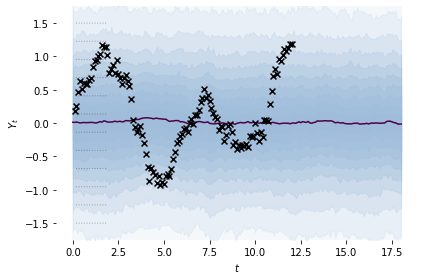

tensor(-0.0795, grad_fn=<MeanBackward0>)


 50%|█████     | 100/200 [07:06<07:32,  4.52s/it]

tensor(-0.0713, grad_fn=<MeanBackward0>)


 50%|█████     | 101/200 [07:10<07:14,  4.39s/it]

tensor(-0.0917, grad_fn=<MeanBackward0>)


 51%|█████     | 102/200 [07:14<06:59,  4.28s/it]

tensor(-0.0780, grad_fn=<MeanBackward0>)


 52%|█████▏    | 103/200 [07:18<06:51,  4.24s/it]

tensor(-0.0808, grad_fn=<MeanBackward0>)


 52%|█████▏    | 104/200 [07:22<06:49,  4.26s/it]

tensor(-0.1055, grad_fn=<MeanBackward0>)


 52%|█████▎    | 105/200 [07:27<06:49,  4.31s/it]

tensor(-0.0787, grad_fn=<MeanBackward0>)


 53%|█████▎    | 106/200 [07:31<06:50,  4.37s/it]

tensor(-0.0755, grad_fn=<MeanBackward0>)


 54%|█████▎    | 107/200 [07:35<06:41,  4.32s/it]

tensor(-0.0775, grad_fn=<MeanBackward0>)


 54%|█████▍    | 108/200 [07:40<06:37,  4.32s/it]

tensor(-0.0925, grad_fn=<MeanBackward0>)


 55%|█████▍    | 109/200 [07:44<06:31,  4.31s/it]

tensor(-0.0716, grad_fn=<MeanBackward0>)


 55%|█████▌    | 110/200 [07:49<06:37,  4.42s/it]

tensor(-0.0687, grad_fn=<MeanBackward0>)


 56%|█████▌    | 111/200 [07:53<06:36,  4.45s/it]

tensor(-0.0761, grad_fn=<MeanBackward0>)


 56%|█████▌    | 112/200 [07:58<06:52,  4.69s/it]

tensor(-0.0941, grad_fn=<MeanBackward0>)


 56%|█████▋    | 113/200 [08:03<06:43,  4.64s/it]

tensor(-0.0724, grad_fn=<MeanBackward0>)


 57%|█████▋    | 114/200 [08:07<06:35,  4.60s/it]

tensor(-0.0862, grad_fn=<MeanBackward0>)


 57%|█████▊    | 115/200 [08:12<06:32,  4.62s/it]

tensor(-0.0655, grad_fn=<MeanBackward0>)


 58%|█████▊    | 116/200 [08:16<06:21,  4.54s/it]

tensor(-0.0759, grad_fn=<MeanBackward0>)


 58%|█████▊    | 117/200 [08:21<06:20,  4.59s/it]

tensor(-0.1003, grad_fn=<MeanBackward0>)


 59%|█████▉    | 118/200 [08:25<06:07,  4.48s/it]

tensor(-0.0611, grad_fn=<MeanBackward0>)


 60%|█████▉    | 119/200 [08:30<05:56,  4.40s/it]

tensor(-0.0799, grad_fn=<MeanBackward0>)


 60%|██████    | 120/200 [08:34<05:53,  4.41s/it]

tensor(-0.0877, grad_fn=<MeanBackward0>)


 60%|██████    | 121/200 [08:38<05:40,  4.31s/it]

tensor(-0.0630, grad_fn=<MeanBackward0>)


 61%|██████    | 122/200 [08:42<05:34,  4.29s/it]

tensor(-0.0567, grad_fn=<MeanBackward0>)


 62%|██████▏   | 123/200 [08:47<05:32,  4.31s/it]

tensor(-0.0802, grad_fn=<MeanBackward0>)


 62%|██████▏   | 124/200 [08:51<05:29,  4.33s/it]

tensor(-0.0601, grad_fn=<MeanBackward0>)


 62%|██████▎   | 125/200 [08:56<05:32,  4.44s/it]

tensor(-0.0834, grad_fn=<MeanBackward0>)


 63%|██████▎   | 126/200 [09:00<05:26,  4.41s/it]

tensor(-0.0983, grad_fn=<MeanBackward0>)


 64%|██████▎   | 127/200 [09:05<05:22,  4.42s/it]

tensor(-0.0980, grad_fn=<MeanBackward0>)


 64%|██████▍   | 128/200 [09:09<05:17,  4.41s/it]

tensor(-0.0671, grad_fn=<MeanBackward0>)


 64%|██████▍   | 129/200 [09:13<05:14,  4.43s/it]

tensor(-0.0672, grad_fn=<MeanBackward0>)


 65%|██████▌   | 130/200 [09:18<05:13,  4.48s/it]

tensor(-0.0787, grad_fn=<MeanBackward0>)


 66%|██████▌   | 131/200 [09:22<05:02,  4.39s/it]

tensor(-0.0615, grad_fn=<MeanBackward0>)


 66%|██████▌   | 132/200 [09:26<04:52,  4.30s/it]

tensor(-0.0786, grad_fn=<MeanBackward0>)


 66%|██████▋   | 133/200 [09:30<04:42,  4.21s/it]

tensor(-0.0533, grad_fn=<MeanBackward0>)


 67%|██████▋   | 134/200 [09:34<04:35,  4.17s/it]

tensor(-0.0619, grad_fn=<MeanBackward0>)


 68%|██████▊   | 135/200 [09:38<04:30,  4.16s/it]

tensor(-0.0821, grad_fn=<MeanBackward0>)


 68%|██████▊   | 136/200 [09:43<04:24,  4.14s/it]

tensor(-0.0963, grad_fn=<MeanBackward0>)


 68%|██████▊   | 137/200 [09:47<04:20,  4.13s/it]

tensor(-0.0572, grad_fn=<MeanBackward0>)


 69%|██████▉   | 138/200 [09:51<04:16,  4.14s/it]

tensor(-0.0755, grad_fn=<MeanBackward0>)


 70%|██████▉   | 139/200 [09:55<04:21,  4.29s/it]

tensor(-0.0847, grad_fn=<MeanBackward0>)


 70%|███████   | 140/200 [10:01<04:37,  4.62s/it]

tensor(-0.0416, grad_fn=<MeanBackward0>)


 70%|███████   | 141/200 [10:05<04:26,  4.52s/it]

tensor(-0.0373, grad_fn=<MeanBackward0>)


 71%|███████   | 142/200 [10:09<04:14,  4.39s/it]

tensor(-0.0828, grad_fn=<MeanBackward0>)


 72%|███████▏  | 143/200 [10:14<04:12,  4.43s/it]

tensor(-0.0847, grad_fn=<MeanBackward0>)


 72%|███████▏  | 144/200 [10:18<04:08,  4.43s/it]

tensor(-0.0873, grad_fn=<MeanBackward0>)


 72%|███████▎  | 145/200 [10:23<04:02,  4.40s/it]

tensor(-0.0774, grad_fn=<MeanBackward0>)


 73%|███████▎  | 146/200 [10:27<03:56,  4.39s/it]

tensor(-0.0892, grad_fn=<MeanBackward0>)


 74%|███████▎  | 147/200 [10:31<03:53,  4.41s/it]

tensor(-0.0854, grad_fn=<MeanBackward0>)


 74%|███████▍  | 148/200 [10:36<03:46,  4.35s/it]

tensor(-0.0887, grad_fn=<MeanBackward0>)


 74%|███████▍  | 149/200 [10:40<03:41,  4.34s/it]

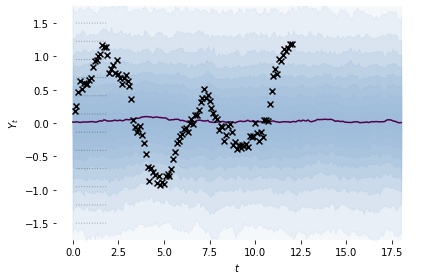

tensor(-0.0452, grad_fn=<MeanBackward0>)


 75%|███████▌  | 150/200 [10:45<03:55,  4.71s/it]

tensor(-0.0630, grad_fn=<MeanBackward0>)


 76%|███████▌  | 151/200 [10:50<03:47,  4.65s/it]

tensor(-0.0559, grad_fn=<MeanBackward0>)


 76%|███████▌  | 152/200 [10:54<03:38,  4.56s/it]

tensor(-0.0822, grad_fn=<MeanBackward0>)


 76%|███████▋  | 153/200 [10:59<03:31,  4.50s/it]

tensor(-0.0636, grad_fn=<MeanBackward0>)


 77%|███████▋  | 154/200 [11:03<03:24,  4.45s/it]

tensor(-0.0229, grad_fn=<MeanBackward0>)


 78%|███████▊  | 155/200 [11:07<03:18,  4.41s/it]

tensor(-0.0613, grad_fn=<MeanBackward0>)


 78%|███████▊  | 156/200 [11:12<03:12,  4.38s/it]

tensor(-0.0701, grad_fn=<MeanBackward0>)


 78%|███████▊  | 157/200 [11:16<03:08,  4.37s/it]

tensor(-0.0636, grad_fn=<MeanBackward0>)


 79%|███████▉  | 158/200 [11:20<03:02,  4.36s/it]

tensor(-0.0659, grad_fn=<MeanBackward0>)


 80%|███████▉  | 159/200 [11:25<03:00,  4.40s/it]

tensor(-0.0626, grad_fn=<MeanBackward0>)


 80%|████████  | 160/200 [11:29<02:58,  4.45s/it]

tensor(-0.0649, grad_fn=<MeanBackward0>)


 80%|████████  | 161/200 [11:34<02:50,  4.37s/it]

tensor(-0.0837, grad_fn=<MeanBackward0>)


 81%|████████  | 162/200 [11:38<02:44,  4.32s/it]

tensor(-0.0667, grad_fn=<MeanBackward0>)


 82%|████████▏ | 163/200 [11:42<02:39,  4.32s/it]

tensor(-0.0728, grad_fn=<MeanBackward0>)


 82%|████████▏ | 164/200 [11:46<02:34,  4.30s/it]

tensor(-0.0912, grad_fn=<MeanBackward0>)


 82%|████████▎ | 165/200 [11:51<02:29,  4.28s/it]

tensor(-0.0899, grad_fn=<MeanBackward0>)


 83%|████████▎ | 166/200 [11:55<02:25,  4.28s/it]

tensor(-0.0501, grad_fn=<MeanBackward0>)


 84%|████████▎ | 167/200 [11:59<02:21,  4.30s/it]

tensor(-0.0679, grad_fn=<MeanBackward0>)


 84%|████████▍ | 168/200 [12:03<02:16,  4.27s/it]

tensor(-0.0669, grad_fn=<MeanBackward0>)


 84%|████████▍ | 169/200 [12:08<02:12,  4.26s/it]

tensor(-0.1145, grad_fn=<MeanBackward0>)


 85%|████████▌ | 170/200 [12:12<02:06,  4.22s/it]

tensor(-0.0405, grad_fn=<MeanBackward0>)


 86%|████████▌ | 171/200 [12:16<02:03,  4.24s/it]

tensor(-0.0864, grad_fn=<MeanBackward0>)


 86%|████████▌ | 172/200 [12:20<01:58,  4.24s/it]

tensor(-0.0739, grad_fn=<MeanBackward0>)


 86%|████████▋ | 173/200 [12:24<01:53,  4.21s/it]

tensor(-0.0768, grad_fn=<MeanBackward0>)


 87%|████████▋ | 174/200 [12:29<01:49,  4.22s/it]

tensor(-0.0968, grad_fn=<MeanBackward0>)


 88%|████████▊ | 175/200 [12:33<01:46,  4.28s/it]

tensor(-0.0883, grad_fn=<MeanBackward0>)


 88%|████████▊ | 176/200 [12:37<01:41,  4.24s/it]

tensor(-0.0728, grad_fn=<MeanBackward0>)


 88%|████████▊ | 177/200 [12:41<01:37,  4.25s/it]

tensor(-0.0590, grad_fn=<MeanBackward0>)


 89%|████████▉ | 178/200 [12:46<01:33,  4.26s/it]

tensor(-0.0998, grad_fn=<MeanBackward0>)


 90%|████████▉ | 179/200 [12:50<01:29,  4.24s/it]

tensor(-0.0853, grad_fn=<MeanBackward0>)


 90%|█████████ | 180/200 [12:54<01:23,  4.19s/it]

tensor(-0.0740, grad_fn=<MeanBackward0>)


 90%|█████████ | 181/200 [12:58<01:19,  4.17s/it]

tensor(-0.0683, grad_fn=<MeanBackward0>)


 91%|█████████ | 182/200 [13:02<01:15,  4.18s/it]

tensor(-0.0986, grad_fn=<MeanBackward0>)


 92%|█████████▏| 183/200 [13:07<01:10,  4.18s/it]

tensor(-0.0736, grad_fn=<MeanBackward0>)


 92%|█████████▏| 184/200 [13:11<01:07,  4.22s/it]

tensor(-0.0870, grad_fn=<MeanBackward0>)


 92%|█████████▎| 185/200 [13:15<01:03,  4.24s/it]

tensor(-0.0963, grad_fn=<MeanBackward0>)


 93%|█████████▎| 186/200 [13:19<00:59,  4.23s/it]

tensor(-0.0619, grad_fn=<MeanBackward0>)


 94%|█████████▎| 187/200 [13:24<00:55,  4.26s/it]

tensor(-0.0834, grad_fn=<MeanBackward0>)


 94%|█████████▍| 188/200 [13:28<00:50,  4.22s/it]

tensor(-0.0385, grad_fn=<MeanBackward0>)


 94%|█████████▍| 189/200 [13:32<00:46,  4.24s/it]

tensor(-0.0833, grad_fn=<MeanBackward0>)


 95%|█████████▌| 190/200 [13:36<00:42,  4.27s/it]

tensor(-0.0920, grad_fn=<MeanBackward0>)


 96%|█████████▌| 191/200 [13:41<00:38,  4.28s/it]

tensor(-0.0764, grad_fn=<MeanBackward0>)


 96%|█████████▌| 192/200 [13:45<00:34,  4.26s/it]

tensor(-0.0522, grad_fn=<MeanBackward0>)


 96%|█████████▋| 193/200 [13:49<00:29,  4.22s/it]

tensor(-0.0775, grad_fn=<MeanBackward0>)


 97%|█████████▋| 194/200 [13:53<00:25,  4.25s/it]

tensor(-0.0965, grad_fn=<MeanBackward0>)


 98%|█████████▊| 195/200 [13:58<00:21,  4.25s/it]

tensor(-0.0646, grad_fn=<MeanBackward0>)


 98%|█████████▊| 196/200 [14:02<00:16,  4.22s/it]

tensor(-0.0893, grad_fn=<MeanBackward0>)


 98%|█████████▊| 197/200 [14:06<00:12,  4.24s/it]

tensor(-0.0868, grad_fn=<MeanBackward0>)


 99%|█████████▉| 198/200 [14:10<00:08,  4.21s/it]

tensor(-0.0661, grad_fn=<MeanBackward0>)


100%|█████████▉| 199/200 [14:15<00:04,  4.24s/it]

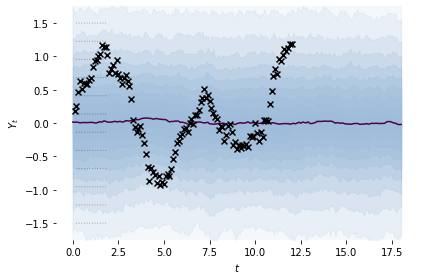

tensor(-0.0687, grad_fn=<MeanBackward0>)


100%|██████████| 200/200 [14:20<00:00,  4.30s/it]


In [255]:
model_1 = LatentSDE().to(device)
l2_only_list = main_1(model_1,is_logpy=False,conditional=True)

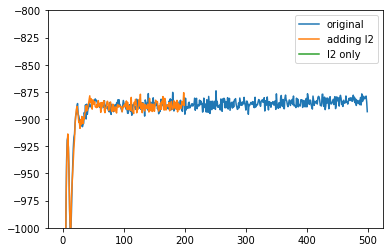

In [256]:
plt.plot(original_logpy,label="original")
plt.plot(l2_logpy_list, label="adding l2")
plt.plot(l2_only_list, label="l2 only")
plt.legend()
plt.ylim((-1000,-800))
plt.show()
plt.close()